In [16]:
%config IPCompleter.use_jedi = False
%pdb off
%load_ext autoreload
%autoreload 3

# required to enable non-blocking interaction:
%gui qt5

import sys
from copy import deepcopy
from typing import Dict, List, Tuple, Optional, Callable, Union, Any
from typing_extensions import TypeAlias
from neuropy.utils.result_context import IdentifyingContext
import nptyping as ND
from nptyping import NDArray
import neuropy.utils.type_aliases as types
from collections import defaultdict
from functools import partial

import numpy as np
import pandas as pd
import re
from pathlib import Path
from datetime import datetime

from neuropy.utils.indexing_helpers import PandasHelpers, NeuroPyDataframeAccessor, UniqueValuesReturnType
from neuropy.utils.result_context import IdentifyingContext

from neuropy.core.user_annotations import UserAnnotationsManager
from pyphocorehelpers.indexing_helpers import partition_df
# Set the maximum number of columns to display
pd.set_option('display.max_columns', 100)

import IPython
from pyphocorehelpers.programming_helpers import IPythonHelpers
from pyphocorehelpers.notebook_helpers import NotebookCellExecutionLogger
from pyphocorehelpers.assertion_helpers import Assert

# Jupyter-lab enable printing for any line on its own (instead of just the last one in the cell)
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

_notebook_path:Path = Path(IPythonHelpers.try_find_notebook_filepath(IPython.extract_module_locals())).resolve() # Finds the path of THIS notebook

# Plotting
# import pylustrator # customization of figures
import matplotlib
import matplotlib as mpl
import matplotlib.pyplot as plt
_bak_rcParams = mpl.rcParams.copy()

matplotlib.use('Qt5Agg')

# Switch to the desired interactivity mode
plt.interactive(True)

from pyphocorehelpers.preferences_helpers import set_pho_preferences

set_pho_preferences(is_concise=False) ## Sets up clean/meaningful pandas and numpy array display

# set_pho_pandas_display_preferences(is_concise=True)


import seaborn as sns

import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.io as pio
template: str = 'plotly_dark' # set plotl template
pio.templates.default = template
from pyphocorehelpers.plotting.media_output_helpers import fig_to_clipboard
from pyphocorehelpers.Filesystem.path_helpers import file_uri_from_path, sanitize_filename_for_Windows
from pyphocorehelpers.gui.Jupyter.simple_widgets import fullwidth_path_widget, simple_path_display_widget
from pyphoplacecellanalysis.Pho2D.plotly.Extensions.plotly_helpers import plotly_helper_save_figures, _helper_build_figure, plotly_pre_post_delta_scatter, plot_across_sessions_scatter_results
from pyphocorehelpers.assertion_helpers import Assert

# from ..PendingNotebookCode import plot_across_sessions_scatter_results, plot_histograms, plot_stacked_histograms
from pyphocorehelpers.Filesystem.path_helpers import find_first_extant_path
from pyphoplacecellanalysis.SpecificResults.AcrossSessionResults import find_csv_files, find_HDF5_files, find_most_recent_files
from pyphoplacecellanalysis.Pho2D.statistics_plotting_helpers import plot_histograms_across_sessions, plot_histograms, plot_stacked_histograms

from pyphoplacecellanalysis.General.Pipeline.Stages.ComputationFunctions.MultiContextComputationFunctions.DirectionalPlacefieldGlobalComputationFunctions import DecoderDecodedEpochsResult
from pyphoplacecellanalysis.SpecificResults.AcrossSessionResults import load_across_sessions_exported_files, _process_and_load_exported_file, _common_cleanup_operations

from pyphocorehelpers.programming_helpers import metadata_attributes
from pyphocorehelpers.function_helpers import function_attributes

from pyphoplacecellanalysis.SpecificResults.AcrossSessionResults import AcrossSessionHelpers, build_session_t_delta, _new_process_csv_files
from pyphoplacecellanalysis.SpecificResults.PhoDiba2023Paper import DataFrameFilter
from pyphocorehelpers.plotting.media_output_helpers import figure_to_pil_image, vertical_image_stack, horizontal_image_stack, image_grid
from neuropy.utils.indexing_helpers import flatten, NumpyHelpers, PandasHelpers
from pyphoplacecellanalysis.SpecificResults.PhoDiba2023Paper import DataFrameFilter, InitialSelectionModeEnum

debug_print: bool = True
enable_neptune: bool = False

_TODAY_DAY_ONLY_DATE: str = "2025-08-11"
TODAY_DAY_DATE: str = f"{_TODAY_DAY_ONLY_DATE}_Apogee"
# TODAY_DAY_DATE: str = f"{_TODAY_DAY_ONLY_DATE}_GL"
# TODAY_DAY_DATE: str = f"{_TODAY_DAY_ONLY_DATE}_Lab"
# TODAY_DAY_DATE: str = f"{_TODAY_DAY_ONLY_DATE}_rMBP"

print(f'TODAY_DAY_DATE: {TODAY_DAY_DATE}')

types.session_str: TypeAlias = str # a unique session identifier

if enable_neptune:
    import neptune # for logging progress and results
    from neptune.types import File
    from pyphoplacecellanalysis.General.Batch.NeptuneAiHelpers import Neptuner, AutoValueConvertingNeptuneRun, set_environment_variables 

    ## Gets the notebook filepath for Neptune:
    import IPython
    from pyphocorehelpers.programming_helpers import IPythonHelpers
    notebook_filepath: str = IPythonHelpers.try_find_notebook_filepath(IPython.extract_module_locals())
    assert Path(notebook_filepath).resolve().exists(), f"found notebook filepath: '{notebook_filepath}' does not exist"
    # notebook_filepath

    neptune_kwargs = {'project':"commander.pho/PhoDibaLongShortAcrossSessions",
    'api_token':"eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vYXBwLm5lcHR1bmUuYWkiLCJhcGlfdXJsIjoiaHR0cHM6Ly9hcHAubmVwdHVuZS5haSIsImFwaV9rZXkiOiIxOGIxODU2My1lZTNhLTQ2ZWMtOTkzNS02ZTRmNzM5YmNjNjIifQ=="}
            
    neptuner = Neptuner(project_name=neptune_kwargs['project'], api_token=neptune_kwargs['api_token'])


    if neptuner.run is None:
        neptuner.run = AutoValueConvertingNeptuneRun(project=neptuner.project_name, api_token=neptuner.api_token, dependencies="infer", source_files=[notebook_filepath])
        params = {"TODAY_DAY_DATE": TODAY_DAY_DATE, "run_workstation": "Apogee"}
        neptuner.run["parameters"] = params
        neptuner.outputs = neptuner.run['outputs']
        neptuner.figures = neptuner.outputs['figures']

    neptuner_run: AutoValueConvertingNeptuneRun = neptuner.run
    
    # run = neptune.init_run(source_files=["**/*.dvc"])

    # # Pre-execution dataframe view:
    # run["dataset/global_batch_run_progress_df"].upload(File.as_html(global_batch_run.to_dataframe(expand_context=True, good_only=False))) # "path/to/test_preds.csv"

else:
    # no neptune:
    neptuner = None    
    neptuner_run = None



known_bad_sessions: List[IdentifyingContext] = UserAnnotationsManager.get_hardcoded_bad_sessions()
# bad_session_df: pd.DataFrame = pd.DataFrame.from_records([v.to_dict() for v in known_bad_sessions], columns=['format_name', 'animal', 'exper_name', 'session_name'])
# bad_session_df

known_bad_session_strs = [str(v.get_description()) for v in known_bad_sessions]
# known_bad_session_strs

Automatic pdb calling has been turned OFF
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
TODAY_DAY_DATE: 2025-08-11_Apogee


# Graphics Imports

In [17]:
import matplotlib
from neuropy.core.user_annotations import UserAnnotationsManager
from pyphocorehelpers.DataStructure.RenderPlots.MatplotLibRenderPlots import MatplotlibRenderPlots
from neuropy.utils.matplotlib_helpers import matplotlib_configuration_update, matplotlib_configuration
# matplotlib.use('Qt5Agg')
from pyphoplacecellanalysis.SpecificResults.AcrossSessionResults import AcrossSessionsResults, AcrossSessionTables, AcrossSessionsVisualizations
from pyphoplacecellanalysis.SpecificResults.PhoDiba2023Paper import PaperFigureTwo

def _save_matplotlib_fig(matplotlib_output_container: MatplotlibRenderPlots):
    """ captures: neptuner_run
    
    """
    a_fig_context = matplotlib_output_container.context
    assert len(matplotlib_output_container.saved_figures) == 1
    a_saved_fig_path = matplotlib_output_container.saved_figures[0][0]
    assert a_saved_fig_path.exists()

    if neptuner_run is not None:
        a_full_figure_path_key: str = a_fig_context.get_description(separator='/', include_property_names=True, key_value_separator=':') # .replace(' ', '_')
        # a_full_figure_path_key: str = a_fig_context.get_description(separator=':', include_property_names=True, key_value_separator='|')
        print(f'a_full_figure_path_key: "{a_full_figure_path_key}"')
        # neptuner_run['outputs']['figures'][f"{a_full_figure_path_key}"].upload(a_fig)
        neptuner_run['outputs']['figures'][f"{a_full_figure_path_key}"].upload(a_saved_fig_path.as_posix())
        # neptuner.figures[f"{a_full_figure_path_key}"].upload(a_fig)
        

# %matplotlib inline


# with matplotlib_configuration_update(is_interactive=False, backend='nbAgg'):
# 'collected_outputs/across_session_result_long_short_recomputed_inst_firing_rate_2024-06-11_GL.pkl'

In [18]:
import plotly.io as pio
import plotly.graph_objects as go
from pyphoplacecellanalysis.Pho2D.plotly.plotly_templates import PlotlyHelpers
from pyphoplacecellanalysis.Pho2D.statistics_plotting_helpers import plot_histograms_across_sessions, plot_stacked_histograms
from pyphoplacecellanalysis.Pho2D.plotly.Extensions.plotly_helpers import plotly_helper_save_figures, _helper_build_figure, plotly_pre_post_delta_scatter, plot_across_sessions_scatter_results, add_copy_save_action_buttons
from pyphoplacecellanalysis.Pho2D.plotly.plotly_templates import PlotlyHelpers
from pyphoplacecellanalysis.Pho2D.plotly.Extensions.plotly_helpers import PlotlyFigureContainer

# fig_size_kwargs = {'width': 1650, 'height': 480}
resolution_multiplier = 1
# fig_size_kwargs = {'width': resolution_multiplier*1650, 'height': resolution_multiplier*480}
 ## set up figure size
fig_size_kwargs = {'width': (resolution_multiplier * 1800), 'height': (resolution_multiplier*480)}
# fig_size_kwargs = {'width': (resolution_multiplier * 1080), 'height': resolution_multiplier*480}
is_dark_mode, template = PlotlyHelpers.get_plotly_template(is_dark_mode=False)
pio.templates.default = template

# figure_export_path = Path(r'E:\Dropbox (Personal)\Active\Kamran Diba Lab\Presentations\2024-05-30 - Pho iNAV Poster\Figures').resolve()
# figure_export_path = Path('/Users/pho/Dropbox (Personal)/Active/Kamran Diba Lab/Presentations/2024-05-30 - Pho iNAV Poster/Figures').resolve()

# assert figure_export_path.exists()

from PIL import Image

from pyphocorehelpers.programming_helpers import copy_image_to_clipboard

def save_plotly(a_fig, a_fig_context):
    """ 
    captures: TODAY_DAY_DATE, figures_folder, neptuner_run
    """
    fig_save_path: Path = figures_folder.joinpath('_'.join([TODAY_DAY_DATE, sanitize_filename_for_Windows(a_fig_context.get_description())])).resolve()
    figure_out_paths = {'.html': fig_save_path.with_suffix('.html'), '.png': fig_save_path.with_suffix('.png')}
    a_fig.write_html(figure_out_paths['.html'])
    display(fullwidth_path_widget(figure_out_paths['.html'], file_name_label='.html'))
    # print(file_uri_from_path(figure_out_paths['.html']))
    a_fig.write_image(figure_out_paths['.png'])
    # print(file_uri_from_path(figure_out_paths['.png']))
    display(fullwidth_path_widget(figure_out_paths['.png'], file_name_label='.png'))

    if neptuner_run is not None:
        a_full_figure_path_key: str = a_fig_context.get_description(separator='/', include_property_names=True, key_value_separator=':') # .replace(' ', '_')
        # a_full_figure_path_key: str = a_fig_context.get_description(separator=':', include_property_names=True, key_value_separator='|')
        print(f'a_full_figure_path_key: "{a_full_figure_path_key}"')
        # neptuner_run['outputs']['figures'][f"{a_full_figure_path_key}"].upload(a_fig)
        neptuner_run['outputs']['figures'][f"{a_full_figure_path_key}"].upload(figure_out_paths['.html'].as_posix())
        # neptuner.figures[f"{a_full_figure_path_key}"].upload(a_fig)
        
    return figure_out_paths


# csv_files

In [4]:
## Load across session t_delta CSV, which contains the t_delta for each session:

## INPUTS: known_bad_session_strs,

# cuttoff_date = datetime(2024, 12, 6)
# cuttoff_date = datetime(2025, 3, 20)
# cuttoff_date = datetime(2025, 3, 27)
# cuttoff_date = datetime(2025, 4, 17)
cuttoff_date = datetime(2025, 6, 1)
# cuttoff_date = datetime(2025, 7, 14)
# cuttoff_date = datetime(2024, 11, 28, 14, 0, 0)

# 2024-11-28 14:00:00
# cuttoff_date = datetime(2024, 11, 24)
# cuttoff_date = datetime(2025, 5, 1)
# cuttoff_date = None


In [19]:

known_collected_outputs_paths = [Path(v).resolve() for v in ['/Users/pho/data/collected_outputs',
                                                            '/Volumes/SwapSSD/Data/collected_outputs', r"K:/scratch/collected_outputs", '/Users/pho/Dropbox (University of Michigan)/MED-DibaLabDropbox/Data/Pho/Outputs/output/collected_outputs', r'C:/Users/pho/repos/Spike3DWorkEnv/Spike3D/output/collected_outputs',
                                                            '/home/halechr/cloud/turbo/Data/Output/collected_outputs',
                                                            '/home/halechr/cloud/turbo/Pho/Output/collected_outputs',
                                                            '/home/halechr/FastData/collected_outputs/',
                                                            ]]
collected_outputs_directory = find_first_extant_path(known_collected_outputs_paths)
assert collected_outputs_directory.exists(), f"collected_outputs_directory: {collected_outputs_directory} does not exist! Is the right computer's config commented out above?"
# fullwidth_path_widget(scripts_output_path, file_name_label='Scripts Output Path:')
print(f'collected_outputs_directory: {collected_outputs_directory}')


# _active_folder_widget = fullwidth_path_widget(collected_outputs_directory)
# display(_active_folder_widget)

# Create a 'figures' subfolder if it doesn't exist
figures_folder: Path = collected_outputs_directory.joinpath('figures').resolve()
figures_folder.mkdir(parents=False, exist_ok=True)
assert figures_folder.exists()
print(f'\tfigures_folder: {file_uri_from_path(figures_folder)}')

# Create an output path for the across session collected results (like the aggregate CSVs built from the individual session CSVs)
across_sessions_output_folder: Path = collected_outputs_directory.joinpath('../across_sessions').resolve()
across_sessions_output_folder.mkdir(parents=False, exist_ok=True)
assert across_sessions_output_folder.exists()
print(f'\tacross_sessions_output_folder: {file_uri_from_path(across_sessions_output_folder)}')


# ## Find the files:
# csv_files = find_csv_files(collected_outputs_directory)
# h5_files = find_HDF5_files(collected_outputs_directory)

# csv_sessions, most_recent_parsed_csv_files_df  = find_most_recent_files(found_session_export_paths=csv_files, cuttoff_date=cuttoff_date) # #TODO 2024-09-27 02:01: - [ ] Note `csv_sessions` is unused, replaced by `most_recent_parsed_csv_files_df`
# h5_sessions, parsed_h5_files_df = find_most_recent_files(found_session_export_paths=h5_files)


collected_outputs_directory: K:\scratch\collected_outputs
	figures_folder: file:///K:/scratch/collected_outputs/figures
	across_sessions_output_folder: file:///K:/scratch/across_sessions


In [ ]:
from pyphoplacecellanalysis.SpecificResults.AcrossSessionResults import ExportValueNameCleaner


new_name_list = ExportValueNameCleaner.clean_all(name_list=all_sessions_MultiMeasure_ripple_df['custom_replay_name'].unique().tolist())
new_name_list

In [6]:
from pyphoplacecellanalysis.SpecificResults.AcrossSessionResults import load_across_sessions_exported_files
from pyphoplacecellanalysis.SpecificResults.AcrossSessionResults import AcrossSessionHelpers

final_sessions, sessions_t_delta_tuple, df_results, (most_recent_parsed_csv_files_df, all_parsed_csv_files_df, csv_files, csv_sessions), (most_recent_parsed_h5_files_df, all_parsed_h5_files_df, h5_files, h5_sessions), excluded_or_outdated_files_list = load_across_sessions_exported_files(collected_outputs_directory=collected_outputs_directory, cuttoff_date=cuttoff_date, debug_print=True)
all_sessions_laps_df, all_sessions_ripple_df, all_sessions_laps_time_bin_df, all_sessions_ripple_time_bin_df, all_sessions_MultiMeasure_laps_df, all_sessions_MultiMeasure_ripple_df, all_sessions_all_scores_ripple_df, all_sessions_merged_complete_epoch_stats_df, *final_sessions_loaded_extra_dfs_list = df_results
t_delta_df, t_delta_dict, (earliest_delta_aligned_t_start, latest_delta_aligned_t_end) = sessions_t_delta_tuple ## UNPACK
# df_result_dfs_dict: Dict[str, pd.DataFrame] = {df.attrs.get('file_type', f'MISSING[{i}]'):df for i, df in enumerate(df_results)} ## use `df_results` as a dict, which is much better than how we currently unpack
# final_sessions_loaded_extra_dfs_dict = {df.attrs.get('file_type', f'MISSING[{i}]'):df for i, df in enumerate(final_sessions_loaded_extra_dfs_list)}

## 1.5mins

collected_outputs_directory: K:\scratch\collected_outputs
earliest_delta_aligned_t_start: -2057.225948, latest_delta_aligned_t_end: 1661.856002
failed to find proper 'is_user_annotated_epoch' and 'is_valid_epoch' columns for the epochs passed with error: Cannot mask with non-boolean array containing NA / NaN values. Skipping.
	Setting "is_valid_epoch" all to True and "is_user_annotated_Epoch" all to False.


In [ ]:
earliest_delta_aligned_t_start

In [ ]:
# most_recent_parsed_csv_files_df # 2024-11-28 14:00:00
most_recent_parsed_csv_files_df
most_recent_parsed_csv_files_df[most_recent_parsed_csv_files_df['export_datetime'] >= cuttoff_date] # 305 

In [ ]:
most_recent_parsed_csv_files_df.neuropy.constrain_columns[most_recent_parsed_csv_files_df['export_datetime'] >= cuttoff_date]

In [ ]:
# all_parsed_csv_files_df
all_parsed_csv_files_df[all_parsed_csv_files_df['export_datetime'] >= cuttoff_date] # 305 


In [ ]:
all_parsed_csv_files_df = all_parsed_csv_files_df.sort_values(['export_datetime', 'session', 'custom_replay_name', 'file_type'], ascending=[False, True, True, True])
all_parsed_csv_files_df = all_parsed_csv_files_df[all_parsed_csv_files_df['export_datetime'] >= cuttoff_date] # filter by cuttoff_date
# _a_df = most_recent_parsed_csv_files_df[most_recent_parsed_csv_files_df['file_type'] == 'ripple_all_scores_merged_df']
_a_df: pd.DataFrame = all_parsed_csv_files_df[all_parsed_csv_files_df['file_type'] == 'ripple_all_scores_merged_df']
# Sort by columns: 'export_datetime' (descending), 'session' (ascending) and 2 other columns
_a_df

# _a_df['path'].to_list()
# excluded_or_outdated_files_list

In [ ]:
# Adjust column width to fit content
# parsed_filtered_csv_files_df = deepcopy(most_recent_parsed_csv_files_df[most_recent_parsed_csv_files_df['file_type'] == 'ripple_all_scores_merged_df'])
parsed_filtered_csv_files_df = deepcopy(all_parsed_csv_files_df[all_parsed_csv_files_df['file_type'] == 'ripple_all_scores_merged_df'])
parsed_filtered_csv_files_df = parsed_filtered_csv_files_df[parsed_filtered_csv_files_df['export_datetime'] >= cuttoff_date] # filter by cuttoff_date
parsed_filtered_csv_files_df = parsed_filtered_csv_files_df.drop_duplicates(subset=['export_datetime', 'session', 'custom_replay_name', 'file_type', 'path', '_comparable_custom_replay_name'], ignore_index=True)

with pd.option_context('display.max_colwidth', None, 'display.max_rows', 100):
    # display(most_recent_parsed_csv_files_df[most_recent_parsed_csv_files_df['file_type'] == 'ripple_all_scores_merged_df'])
    display(parsed_filtered_csv_files_df)

# The versions without the time suffix (only the day date) do not include the time_bin_size it seems _________________ #
## '/home/halechr/FastData/collected_outputs/2024-11-26_GL-kdiba_gor01_one_2006-6-08_14-26-15__withNormalComputedReplays-qclu_[1, 2, 4, 6, 7, 9]-frateThresh_5.0-(ripple_all_scores_merged_df)_tbin-0.025.csv'

# export_datetime	session	custom_replay_name	file_type	decoding_time_bin_size_str	path	_comparable_custom_replay_name
# 913	2024-11-26 00:00:00	kdiba_gor01_one_2006-6-08_14-26-15	withNormalComputedReplays-qclu_[1, 2, 4, 6, 7, 9]-frateThresh_5.0	ripple_all_scores_merged_df		/home/halechr/FastData/collected_outputs/2024-11-26_GL-kdiba_gor01_one_2006-6-08_14-26-15__withNormalComputedReplays-qclu_[1, 2, 4, 6, 7, 9]-frateThresh_5.0-(ripple_all_scores_merged_df)_tbin-0.025.csv	withNormalComputedReplays-qclu-[1, 2, 4, 6, 7, 9]-frateThresh-5.0
# 903	2024-11-26 00:50:00	kdiba_gor01_one_2006-6-08_14-26-15	withNormalComputedReplays-qclu_[1, 2, 4, 6, 7, 9]-frateThresh_5.0	ripple_all_scores_merged_df	0.025	/home/halechr/FastData/collected_outputs/2024-11-26_1250AM-kdiba_gor01_one_2006-6-08_14-26-15__withNormalComputedReplays-qclu_[1, 2, 4, 6, 7, 9]-frateThresh_5.0-(ripple_all_scores_merged_df)_tbin-0.025.csv	withNormalComputedReplays-qclu-[1, 2, 4, 6, 7, 9]-frateThresh-5.0
# 909	2024-11-26 00:50:00	kdiba_gor01_one_2006-6-08_14-26-15	withNormalComputedReplays-qclu_[1, 2, 4, 6, 7, 9]-frateThresh_5.0	ripple_all_scores_merged_df	0.058	/home/halechr/FastData/collected_outputs/2024-11-26_1250AM-kdiba_gor01_one_2006-6-08_14-26-15__withNormalComputedReplays-qclu_[1, 2, 4, 6, 7, 9]-frateThresh_5.0-(ripple_all_scores_merged_df)_tbin-0.058.csv	withNormalComputedReplays-qclu-[1, 2, 4, 6, 7, 9]-frateThresh-5.0

# '/home/halechr/FastData/collected_outputs/2024-11-26_GL-kdiba_gor01_one_2006-6-08_14-26-15__withNormalComputedReplays-qclu_[1, 2, 4, 6, 7, 9]-frateThresh_5.0-(ripple_all_scores_merged_df)_tbin-0.025.csv'
# '/home/halechr/FastData/collected_outputs/2024-11-26_1250AM-kdiba_gor01_one_2006-6-08_14-26-15__withNormalComputedReplays-qclu_[1, 2, 4, 6, 7, 9]-frateThresh_5.0-(ripple_all_scores_merged_df)_tbin-0.025.csv'

In [ ]:
all_sessions_MultiMeasure_ripple_df
all_sessions_merged_complete_epoch_stats_df
all_sessions_ripple_df
all_sessions_all_scores_ripple_df

In [ ]:
print(list(all_sessions_all_scores_ripple_df.columns))


In [ ]:
all_sessions_all_scores_ripple_df['is_valid']

In [ ]:
all_sessions_all_scores_ripple_df
# all_sessions_all_scores_ripple_df['time_bin_size'].unique()
original_n_rows: int = len(all_sessions_all_scores_ripple_df) # 3161 
original_n_rows
# ['longest_sequence_length_ratio_long_LR', 'longest_sequence_length_long_LR', 'longest_sequence_length_ratio_long_LR',]

In [ ]:
all_sessions_all_scores_ripple_df[all_sessions_all_scores_ripple_df['time_bin_size'].notna()] # 1456 

In [ ]:
all_sessions_all_scores_ripple_df[all_sessions_all_scores_ripple_df['time_bin_size'] == 0.025] ## just 934 rows out of 1456
# .unique()


In [ ]:
all_sessions_merged_complete_epoch_stats_df

In [ ]:
## replace inf values with 0.0
all_sessions_all_scores_ripple_df[['ratio_jump_valid_bins_long_LR', 'ratio_jump_valid_bins_long_RL', 'ratio_jump_valid_bins_short_LR', 'ratio_jump_valid_bins_short_RL']] = all_sessions_all_scores_ripple_df[['ratio_jump_valid_bins_long_LR', 'ratio_jump_valid_bins_long_RL', 'ratio_jump_valid_bins_short_LR', 'ratio_jump_valid_bins_short_RL']].replace(np.inf, 0.0)
all_sessions_all_scores_ripple_df['best_overall_ratio_jump_valid_bins'] = np.nanmax(all_sessions_all_scores_ripple_df[['ratio_jump_valid_bins_long_LR', 'ratio_jump_valid_bins_long_RL', 'ratio_jump_valid_bins_short_LR', 'ratio_jump_valid_bins_short_RL']], axis=1) ## is this actually element-wise like I want it to be?
all_sessions_all_scores_ripple_df['best_overall_ratio_jump_valid_bins'].notna().sum()

In [ ]:
## Adds the best_overall_quantile columns in to ['all_sessions_all_scores_ripple_df', 'all_sessions_MultiMeasure_ripple_df']

if all_sessions_merged_complete_epoch_stats_df is not None:
    assert PandasHelpers.require_columns(all_sessions_merged_complete_epoch_stats_df, required_columns=['Long_BestDir_quantile', 'Short_BestDir_quantile'], print_missing_columns=True)
    all_sessions_merged_complete_epoch_stats_df['best_overall_quantile'] = np.nanmax(all_sessions_merged_complete_epoch_stats_df[['Long_BestDir_quantile', 'Short_BestDir_quantile']], axis=1)
    assert PandasHelpers.require_columns(all_sessions_merged_complete_epoch_stats_df, required_columns=['Long_BestDir_quantile', 'Short_BestDir_quantile', 'best_overall_quantile'], print_missing_columns=True)
    all_sessions_merged_complete_epoch_stats_df = all_sessions_merged_complete_epoch_stats_df[all_sessions_merged_complete_epoch_stats_df['custom_replay_name'] != ''] # only non-blank values

    ## Differences in format of 'session_name' for the two dataframes:
    # all_sessions_all_scores_ripple_df['session_name']: 'kdiba_gor01_one_2006-6-08_14-26-15', ...
    # all_sessions_merged_complete_epoch_stats_df['session_name']: 'kdiba-gor01-one-2006-6-08_14-26-15', ...

    assert 'best_overall_quantile' in all_sessions_merged_complete_epoch_stats_df, f'all_sessions_merged_complete_epoch_stats_df is missing "best_overall_quantile"'

    all_sessions_all_scores_ripple_df = AcrossSessionHelpers._subfn_perform_add_merged_complete_epoch_stats_df(a_paired_main_ripple_df=deepcopy(all_sessions_all_scores_ripple_df), an_all_sessions_merged_complete_epoch_stats_df=deepcopy(all_sessions_merged_complete_epoch_stats_df),
                                                                                                            comparison_must_match_column_names = ['custom_replay_name', 'session_name', 'start', 'stop'], comparison_must_match_non_temporal_column_names = ['custom_replay_name', 'session_name'], desired_transfer_col_names = ['Long_BestDir_quantile', 'Short_BestDir_quantile', 'best_overall_quantile'])
    all_sessions_MultiMeasure_ripple_df = AcrossSessionHelpers._subfn_perform_add_merged_complete_epoch_stats_df(a_paired_main_ripple_df=deepcopy(all_sessions_MultiMeasure_ripple_df), an_all_sessions_merged_complete_epoch_stats_df=deepcopy(all_sessions_merged_complete_epoch_stats_df),
                                                                                                                comparison_must_match_column_names = ['custom_replay_name', 'session_name', 'start', 'stop'], comparison_must_match_non_temporal_column_names = ['custom_replay_name', 'session_name'], desired_transfer_col_names = ['Long_BestDir_quantile', 'Short_BestDir_quantile', 'best_overall_quantile'])
    # all_sessions_ripple_df = AcrossSessionHelpers._subfn_perform_add_merged_complete_epoch_stats_df(a_paired_main_ripple_df=deepcopy(all_sessions_ripple_df), an_all_sessions_merged_complete_epoch_stats_df=deepcopy(all_sessions_merged_complete_epoch_stats_df))

    print(f"num non-na 'best_overall_quantile' rows for `all_sessions_all_scores_ripple_df`: {all_sessions_all_scores_ripple_df['best_overall_quantile'].notna().sum()}") ## KeyError: 'best_overall_quantile', why is this happening? Isn't it being setup above?
    print(f"num non-na 'best_overall_quantile' rows for `all_sessions_MultiMeasure_ripple_df`: {all_sessions_MultiMeasure_ripple_df['best_overall_quantile'].notna().sum()}")

    assert PandasHelpers.require_columns(all_sessions_all_scores_ripple_df, required_columns=['Long_BestDir_quantile', 'Short_BestDir_quantile', 'best_overall_quantile'], print_missing_columns=True)
    assert PandasHelpers.require_columns(all_sessions_MultiMeasure_ripple_df, required_columns=['Long_BestDir_quantile', 'Short_BestDir_quantile', 'best_overall_quantile'], print_missing_columns=True)

    ## re-pack `df_results`
    df_results = all_sessions_laps_df, all_sessions_ripple_df, all_sessions_laps_time_bin_df, all_sessions_ripple_time_bin_df, all_sessions_MultiMeasure_laps_df, all_sessions_MultiMeasure_ripple_df, all_sessions_all_scores_ripple_df, all_sessions_merged_complete_epoch_stats_df, *final_sessions_loaded_extra_dfs_list
    df_result_dfs_dict: Dict[str, pd.DataFrame] = {df.attrs.get('file_type', f'MISSING[{i}]'):df for i, df in enumerate(df_results)} ## use `df_results` as a dict, which is much better than how we currently unpack
    final_sessions_loaded_extra_dfs_dict = {df.attrs.get('file_type', f'MISSING[{i}]'):df for i, df in enumerate(final_sessions_loaded_extra_dfs_list)}
    
    ## INPUTS: final_sessions_loaded_extra_dfs_dict
    
    ## Adds the WCorrShuffle columns in to ['all_sessions_all_scores_ripple_df', 'all_sessions_MultiMeasure_ripple_df']
    # df_result_dfs_dict
    ripple_WCorrShuffle_df = final_sessions_loaded_extra_dfs_dict.get('ripple_WCorrShuffle_df', None)
    if ripple_WCorrShuffle_df is not None:
        assert PandasHelpers.require_columns(ripple_WCorrShuffle_df, required_columns=['wcorr_z_long', 'wcorr_z_short'], print_missing_columns=True)
        # ripple_WCorrShuffle_df['custom_replay_name'].unique()

        wcorr_shuffle_time_idx_column_names = ['custom_replay_name', 'session_name', 'start', 'stop', 'time_bin_size'] # , 'time_bin_size'
        wcorr_shuffle_relevent_column_names = ['wcorr_z_long', 'wcorr_z_short', 'best_overall_wcorr_z'] # , 'n_unique_aclus'
        comparison_must_match_non_temporal_column_names = ['custom_replay_name', 'session_name', 'time_bin_size']

        if 'best_overall_wcorr_z' not in ripple_WCorrShuffle_df.columns:
            ripple_WCorrShuffle_df['best_overall_wcorr_z'] = np.nanmax(np.abs(ripple_WCorrShuffle_df[['wcorr_z_long', 'wcorr_z_short']]), axis=1)

        assert PandasHelpers.require_columns(ripple_WCorrShuffle_df, required_columns=wcorr_shuffle_relevent_column_names, print_missing_columns=True)

        all_sessions_all_scores_ripple_df = AcrossSessionHelpers._subfn_perform_add_merged_complete_epoch_stats_df(a_paired_main_ripple_df=deepcopy(all_sessions_all_scores_ripple_df), an_all_sessions_merged_complete_epoch_stats_df=deepcopy(ripple_WCorrShuffle_df),
                                                                                                                comparison_must_match_column_names = wcorr_shuffle_time_idx_column_names, comparison_must_match_non_temporal_column_names=comparison_must_match_non_temporal_column_names, desired_transfer_col_names=wcorr_shuffle_relevent_column_names,
                                                                                                                )

        all_sessions_MultiMeasure_ripple_df = AcrossSessionHelpers._subfn_perform_add_merged_complete_epoch_stats_df(a_paired_main_ripple_df=deepcopy(all_sessions_MultiMeasure_ripple_df), an_all_sessions_merged_complete_epoch_stats_df=deepcopy(ripple_WCorrShuffle_df),
                                                                                                                comparison_must_match_column_names = wcorr_shuffle_time_idx_column_names, comparison_must_match_non_temporal_column_names=comparison_must_match_non_temporal_column_names, desired_transfer_col_names=wcorr_shuffle_relevent_column_names,
                                                                                                                )


        # all_sessions_all_scores_ripple_df
        # all_sessions_MultiMeasure_ripple_df
        print(f"num non-na 'best_overall_wcorr_z' rows for `all_sessions_all_scores_ripple_df`: {all_sessions_all_scores_ripple_df['best_overall_wcorr_z'].notna().sum()}")
        print(f"num non-na 'best_overall_wcorr_z' rows for `all_sessions_MultiMeasure_ripple_df`: {all_sessions_MultiMeasure_ripple_df['best_overall_wcorr_z'].notna().sum()}")

        assert PandasHelpers.require_columns(all_sessions_all_scores_ripple_df, required_columns=wcorr_shuffle_relevent_column_names, print_missing_columns=True)
        assert PandasHelpers.require_columns(all_sessions_MultiMeasure_ripple_df, required_columns=wcorr_shuffle_relevent_column_names, print_missing_columns=True)

        ## re-pack `df_results`
        df_results = all_sessions_laps_df, all_sessions_ripple_df, all_sessions_laps_time_bin_df, all_sessions_ripple_time_bin_df, all_sessions_MultiMeasure_laps_df, all_sessions_MultiMeasure_ripple_df, all_sessions_all_scores_ripple_df, all_sessions_merged_complete_epoch_stats_df, *final_sessions_loaded_extra_dfs_list
        df_result_dfs_dict: Dict[str, pd.DataFrame] = {df.attrs.get('file_type', f'MISSING[{i}]'):df for i, df in enumerate(df_results)} ## use `df_results` as a dict, which is much better than how we currently unpack
        final_sessions_loaded_extra_dfs_dict = {df.attrs.get('file_type', f'MISSING[{i}]'):df for i, df in enumerate(final_sessions_loaded_extra_dfs_list)}


In [ ]:
# all_sessions_all_scores_ripple_df[np.logical_not(all_sessions_all_scores_ripple_df['long_best_jump'].isnull())] ## only 133 events :[
all_sessions_all_scores_ripple_df[np.logical_not(all_sessions_all_scores_ripple_df['short_best_jump'].isnull())] ## only 133 events :[ -- now 412 rows... -- now 3573 rows...
# all_sessions_ripple_df[np.logical_not(all_sessions_ripple_df['short_best_jump'].isnull())] # no 'short_best_jump' col
# all_sessions_merged_complete_epoch_stats_df[np.logical_not(all_sessions_merged_complete_epoch_stats_df['short_best_jump'].isnull())] # no 'short_best_jump' col
# all_sessions_MultiMeasure_ripple_df

In [ ]:
all_sessions_merged_complete_epoch_stats_df

In [ ]:
from pyphoplacecellanalysis.SpecificResults.AcrossSessionResults import AcrossSessionHelpers

'result_t_bin_idx', 'epoch_df_idx', 'parent_epoch_label', 'label'

# epoch_idx_col_name: str = 'epoch_idx'
# epoch_idx_col_name: str = 'label' # for 'all_sessions_all_scores_ripple_df', doesn't quite work
epoch_idx_col_name: str = 'ripple_idx' # for 'all_sessions_MultiMeasure_ripple_df',



an_epoch_time_bin_df = deepcopy(all_sessions_ripple_time_bin_df)
# a_paired_epoch_stats_df = deepcopy(all_sessions_ripple_df)
# a_paired_epoch_stats_df = deepcopy(all_sessions_all_scores_ripple_df)
a_paired_epoch_stats_df = deepcopy(all_sessions_MultiMeasure_ripple_df)




an_epoch_time_bin_df.set_index(['session_name', 'custom_replay_name', 'time_bin_size'], drop=False)

# all_sessions_ripple_time_bin_df = all_sessions_ripple_time_bin_df.groupby(['session_name', 'custom_replay_name', 'time_bin_size']).count().reset_index()[['session_name', 'custom_replay_name', 'time_bin_size']]


# df.groupby(['session_name', 'custom_replay_name', 'time_bin_size']).count().reset_index()[['session_name', 'custom_replay_name', 'time_bin_size']].drop_duplicates()

['epoch_df_idx', 'parent_epoch_label', 'result_t_bin_idx'] ## all seem the same... are they?

# df.groupby(['session_name', 'custom_replay_name', 'time_bin_size']).count().reset_index()[['session_name', 'custom_replay_name', 'time_bin_size', 'parent_epoch_label']] #.drop_duplicates()
# df.groupby(['session_name', 'custom_replay_name', 'time_bin_size']).count().reset_index()[['session_name', 'custom_replay_name', 'time_bin_size', 'epoch_df_idx']]

time_bin_epoch_complete_identifier_uniques_df = an_epoch_time_bin_df.groupby(['session_name', 'custom_replay_name', 'time_bin_size', 'parent_epoch_label']).count().reset_index()[['session_name', 'custom_replay_name', 'time_bin_size', 'parent_epoch_label']].drop_duplicates()

epoch_complete_identifier_uniques_df = a_paired_epoch_stats_df.groupby(['session_name', 'custom_replay_name', 'time_bin_size', epoch_idx_col_name]).count().reset_index()[['session_name', 'custom_replay_name', 'time_bin_size', epoch_idx_col_name]].drop_duplicates()
assert len(time_bin_epoch_complete_identifier_uniques_df) == len(epoch_complete_identifier_uniques_df), f"epoch_complete_identifier_uniques: {len(epoch_complete_identifier_uniques_df)}, time_bin_epoch_complete_identifier_uniques: {len(time_bin_epoch_complete_identifier_uniques_df)}"

In [ ]:
from pyphoplacecellanalysis.SpecificResults.AcrossSessionResults import AcrossSessionHelpers

desired_transfer_col_names = ['Long_BestDir_quantile', 'Short_BestDir_quantile', 'best_overall_quantile', 'wcorr_z_long', 'wcorr_z_short', 'best_overall_wcorr_z']

comparison_must_match_column_names = ['session_name', 'custom_replay_name', 'time_bin_size', epoch_idx_col_name]
an_epoch_time_bin_df = AcrossSessionHelpers._subfn_perform_add_stats_to_time_bins_df(a_paired_epoch_stats_df=deepcopy(all_sessions_MultiMeasure_ripple_df), an_epoch_time_bin_df=deepcopy(all_sessions_ripple_time_bin_df),
                                                                                        comparison_must_match_column_names = comparison_must_match_column_names, comparison_must_match_non_temporal_column_names = comparison_must_match_column_names,
                                                                                         desired_transfer_col_names = desired_transfer_col_names)

an_epoch_time_bin_df

# all_sessions_ripple_time_bin_df = an_epoch_time_bin_df ## assign

## SLOW - took 18m for ~240203 rows
an_epoch_time_bin_df.to_csv(Path('C:/Users/pho/repos/Spike3DWorkEnv/Spike3D/EXTERNAL/PhoDibaPaper2024Book/data').joinpath(f'2024-11-20_full_merged_stats_properties_all_sessions_ripple_time_bin_df.csv'))

# Assert.same_length(all_sessions_ripple_time_bin_df, an_epoch_time_bin_df)
# an_epoch_time_bin_df
all_sessions_ripple_time_bin_df = an_epoch_time_bin_df ## assign

assert PandasHelpers.require_columns(all_sessions_ripple_time_bin_df, required_columns=desired_transfer_col_names, print_missing_columns=True)

## re-pack `df_results`
df_results = all_sessions_laps_df, all_sessions_ripple_df, all_sessions_laps_time_bin_df, all_sessions_ripple_time_bin_df, all_sessions_MultiMeasure_laps_df, all_sessions_MultiMeasure_ripple_df, all_sessions_all_scores_ripple_df, all_sessions_merged_complete_epoch_stats_df, *final_sessions_loaded_extra_dfs_list
df_result_dfs_dict: Dict[str, pd.DataFrame] = {df.attrs.get('file_type', f'MISSING[{i}]'):df for i, df in enumerate(df_results)} ## use `df_results` as a dict, which is much better than how we currently unpack
final_sessions_loaded_extra_dfs_dict = {df.attrs.get('file_type', f'MISSING[{i}]'):df for i, df in enumerate(final_sessions_loaded_extra_dfs_list)}

# all_sessions_ripple_time_bin_df
all_sessions_ripple_time_bin_df

In [ ]:
print(list(all_sessions_ripple_time_bin_df.columns))
# 'result_t_bin_idx', 'epoch_df_idx', 'parent_epoch_label', 'label'
['session_name', 'time_bin_size', 'custom_replay_name']

In [ ]:
all_sessions_all_scores_ripple_df

In [ ]:
most_recent_parsed_csv_files_df[most_recent_parsed_csv_files_df['file_type'] == 'ripple_WCorrShuffle_df']


In [ ]:
all_sessions_all_scores_ripple_df['custom_replay_name'].unique()

In [ ]:
assert 'best_overall_quantile' in all_sessions_all_scores_ripple_df

['best_overall_quantile']
all_sessions_all_scores_ripple_df['best_overall_quantile']

In [ ]:
"2024-11-15_GL-kdiba-gor01-one-2006-6-08_14-26-15__withNormalComputedReplays-frateThresh_5.0-qclu_[1, 2, 4, 6, 7, 9]-(merged_complete_epoch_stats_df).csv"
excluded_or_outdated_files_list

In [ ]:
most_recent_parsed_csv_files_df

In [ ]:
all_sessions_merged_complete_epoch_stats_relevant_df # 'Long_BestDir_quantile', 'Short_BestDir_quantile'

In [ ]:
all_sessions_all_scores_ripple_df['custom_replay_name'].unique()

In [ ]:
# INPUTS: sessions_t_delta_tuple
t_delta_df, t_delta_dict, (earliest_delta_aligned_t_start, latest_delta_aligned_t_end) = sessions_t_delta_tuple ## UNPACK
t_delta_dict

In [ ]:
all_sessions_all_scores_ripple_df

In [ ]:
all_sessions_MultiMeasure_ripple_df

In [ ]:
most_recent_parsed_csv_files_df

In [ ]:
most_recent_parsed_csv_files_df['custom_replay_name'].unique()

In [ ]:
# all_sessions_MultiMeasure_laps_df
all_columns = list(all_sessions_all_scores_ripple_df.columns)
# all_columns
bad_columns = [v for v in all_columns if ('.1' in v)]
bad_columns # ['P_Long.1', 'P_Short.1', 'P_LR.1', 'P_RL.1']

equiv_columns = [v.strip('.1') for v in bad_columns]
equiv_columns # ['P_Long', 'P_Short', 'P_LR', 'P_RL']

equiv_values = all_sessions_all_scores_ripple_df[equiv_columns]
bad_values = all_sessions_all_scores_ripple_df[bad_columns]

equiv_values
bad_values
does_row_have_bad_entry = np.any(np.isclose(equiv_values.to_numpy(), bad_values.to_numpy()), axis=1)
does_row_have_bad_entry

# h5_files

In [7]:
from pyphoplacecellanalysis.SpecificResults.AcrossSessionResults import load_across_sessions_exported_h5_files

## INPUTS: h5_sessions, session_dict, cuttoff_date, known_bad_session_strs
parsed_h5_files_df, h5_contexts_paths_dict = load_across_sessions_exported_h5_files(collected_outputs_directory=collected_outputs_directory, cuttoff_date=cuttoff_date,
                                                                                    known_bad_session_strs=known_bad_session_strs, debug_print=True)

h5_contexts_paths_dict
h5_session_contexts = list(h5_contexts_paths_dict.keys())
included_h5_paths = list(h5_contexts_paths_dict.values())

if neptuner_run is not None:
    _neptuner_run_parameters = dict(parsed_h5_files_df=parsed_h5_files_df,
                                       )
    for k, v in _neptuner_run_parameters.items():
        neptuner_run[f'parsed/{k}'] = v
    _neptuner_run_parameters = {} # reset after writing

parsed_h5_files_df
# h5_contexts_paths_dict

included_h5_paths


collected_outputs_directory: K:\scratch\collected_outputs


{Context(format_name= 'kdiba', animal= 'gor01', exper_name= 'one', session_name= '2006-6-08_14-26-15'): None,
 Context(format_name= 'kdiba', animal= 'gor01', exper_name= 'one', session_name= '2006-6-09_1-22-43'): None,
 Context(format_name= 'kdiba', animal= 'gor01', exper_name= 'one', session_name= '2006-6-12_15-55-31'): None,
 Context(format_name= 'kdiba', animal= 'gor01', exper_name= 'two', session_name= '2006-6-07_16-40-19'): None,
 Context(format_name= 'kdiba', animal= 'gor01', exper_name= 'two', session_name= '2006-6-12_16-53-46'): None,
 Context(format_name= 'kdiba', animal= 'vvp01', exper_name= 'one', session_name= '2006-4-10_12-25-50'): None,
 Context(format_name= 'kdiba', animal= 'vvp01', exper_name= 'two', session_name= '2006-4-09_16-40-54'): None,
 Context(format_name= 'kdiba', animal= 'vvp01', exper_name= 'two', session_name= '2006-4-10_12-58-3'): None,
 Context(format_name= 'kdiba', animal= 'pin01', exper_name= 'one', session_name= '11-03_12-3-25'): None}

,export_datetime,session,custom_replay_name,file_type,decoding_time_bin_size_str,path,_comparable_custom_replay_name
3,2025-08-01,kdiba_gor01_one_2006-6-08_14-26-15,"withNormalComputedReplays-qclu_[1, 2, 4, 6, 7,...",first_spike_activity_data,,K:\scratch\collected_outputs\2025-08-01-kdiba_...,"withNormalComputedReplays-qclu-[1, 2, 4, 6, 7,..."
7,2025-06-11,kdiba_gor01_one_2006-6-08_14-26-15,"withNormalComputedReplays-qclu_[1, 2, 4, 6, 7,...",first_spike_activity_data,,K:\scratch\collected_outputs\2025-06-11-kdiba_...,"withNormalComputedReplays-qclu-[1, 2, 4, 6, 7,..."
12,2025-06-05,kdiba_gor01_one_2006-6-08_14-26-15,"withNormalComputedReplays-qclu_[1, 2, 4, 6, 7,...",time_bin_size_sweep_results,,K:\scratch\collected_outputs\2025-06-05_GL-kdi...,"withNormalComputedReplays-qclu-[1, 2, 4, 6, 7,..."
28,2025-07-31,kdiba_gor01_one_2006-6-09_1-22-43,"withNormalComputedReplays-qclu_[1, 2, 4, 6, 7,...",time_bin_size_sweep_results,,K:\scratch\collected_outputs\2025-07-31_Apogee...,"withNormalComputedReplays-qclu-[1, 2, 4, 6, 7,..."
18,2025-07-31,kdiba_gor01_one_2006-6-09_1-22-43,"withNormalComputedReplays-qclu_[1, 2, 4, 6, 7,...",first_spike_activity_data,,K:\scratch\collected_outputs\2025-07-31-kdiba_...,"withNormalComputedReplays-qclu-[1, 2, 4, 6, 7,..."
25,2025-06-11,kdiba_gor01_one_2006-6-09_1-22-43,"withNormalComputedReplays-qclu_[1, 2, 4, 6, 7,...",first_spike_activity_data,,K:\scratch\collected_outputs\2025-06-11-kdiba_...,"withNormalComputedReplays-qclu-[1, 2, 4, 6, 7,..."
29,2025-06-05,kdiba_gor01_one_2006-6-09_1-22-43,"withNormalComputedReplays-qclu_[1, 2, 4, 6, 7,...",time_bin_size_sweep_results,,K:\scratch\collected_outputs\2025-06-05_GL-kdi...,"withNormalComputedReplays-qclu-[1, 2, 4, 6, 7,..."
34,2025-06-05,kdiba_gor01_one_2006-6-12_15-55-31,"withNormalComputedReplays-qclu_[1, 2, 4, 6, 7,...",time_bin_size_sweep_results,,K:\scratch\collected_outputs\2025-06-05_GL-kdi...,"withNormalComputedReplays-qclu-[1, 2, 4, 6, 7,..."
39,2025-08-01,kdiba_gor01_two_2006-6-07_16-40-19,"withNormalComputedReplays-qclu_[1, 2, 4, 6, 7,...",first_spike_activity_data,,K:\scratch\collected_outputs\2025-08-01-kdiba_...,"withNormalComputedReplays-qclu-[1, 2, 4, 6, 7,..."
44,2025-06-11,kdiba_gor01_two_2006-6-07_16-40-19,"withNormalComputedReplays-qclu_[1, 2, 4, 6, 7,...",first_spike_activity_data,,K:\scratch\collected_outputs\2025-06-11-kdiba_...,"withNormalComputedReplays-qclu-[1, 2, 4, 6, 7,..."


[None, None, None, None, None, None, None, None, None]

In [ ]:
included_h5_paths

In [ ]:
h5_contexts_paths_dict

In [ ]:
from copy import deepcopy
from pyphoplacecellanalysis.SpecificResults.AcrossSessionResults import AcrossSessionTables
from pyphoplacecellanalysis.SpecificResults.AcrossSessionResults import AcrossSessionsVisualizations
from pyphocorehelpers.indexing_helpers import reorder_columns, reorder_columns_relative

included_session_contexts = deepcopy(h5_session_contexts)
included_h5_paths = deepcopy(included_h5_paths)
num_sessions = len(included_session_contexts)
(neuron_identities_table, long_short_fr_indicies_analysis_table, neuron_replay_stats_table), output_path_dicts = AcrossSessionTables.build_and_save_all_combined_tables(included_session_contexts, included_h5_paths,
                                                                                                                                                    override_output_parent_path=across_sessions_output_folder, output_path_suffix=f'{TODAY_DAY_DATE}',
                                                                                                                                                    should_restore_native_column_types=True, include_csv=True, include_pkl=True)


if neptuner_run is not None:
    _neptuner_run_parameters = dict(neuron_identities_table=neuron_identities_table, long_short_fr_indicies_analysis_table=long_short_fr_indicies_analysis_table, neuron_replay_stats_table=neuron_replay_stats_table,
                                       num_sessions=num_sessions)
    for k, v in _neptuner_run_parameters.items():
        neptuner_run[f'parsed/{k}'] = v
    _neptuner_run_parameters = {} # reset after writing

    for output_name, a_paths_dict in output_path_dicts.items():
        for format_extension, an_output_path in a_paths_dict.items():
            neptuner_run[f"output_files/{format_extension}/{output_name}"].upload(an_output_path.resolve().as_posix())


# {'neuron_identities_table': {'.csv': WindowsPath('K:/scratch/across_sessions/2024-06-05_Apogee/neuron_identities_table.csv'),
#   '.pkl': WindowsPath('K:/scratch/across_sessions/2024-06-05_Apogee/neuron_identities_table.pkl')},
#  'long_short_fr_indicies_analysis_table': {'.csv': WindowsPath('K:/scratch/across_sessions/2024-06-05_Apogee/long_short_fr_indicies_analysis_table.csv'),
#   '.pkl': WindowsPath('K:/scratch/across_sessions/2024-06-05_Apogee/long_short_fr_indicies_analysis_table.pkl')},
#  'neuron_replay_stats_table': {'.csv': WindowsPath('K:/scratch/across_sessions/2024-06-05_Apogee/neuron_replay_stats_table.csv'),
#   '.pkl': WindowsPath('K:/scratch/across_sessions/2024-06-05_Apogee/neuron_replay_stats_table.pkl')}}

output_path_dicts

## Move the "height" columns to the end
neuron_replay_stats_table = reorder_columns_relative(neuron_replay_stats_table, column_names=['neuron_uid', 'format_name', 'animal', 'exper_name', 'session_name', 'neuron_type', 'aclu', 'session_uid', 'session_datetime'], relative_mode='start')

neuron_replay_stats_table


In [ ]:
parsed_h5_files_df['file_type'].unique()

# 2024-11-26 - `decoded_posteriors` from HDF5 files

In [8]:
from pyphoplacecellanalysis.SpecificResults.AcrossSessionResults import H5FileAggregator
from pyphoplacecellanalysis.Pho2D.data_exporting import PosteriorExporting
from neuropy.utils.result_context import DisplaySpecifyingIdentifyingContext
from pyphoplacecellanalysis.Pho2D.data_exporting import LoadedPosteriorContainer
from neuropy.utils.indexing_helpers import flatten, flatten_dict
from pyphoplacecellanalysis.SpecificResults.AcrossSessionResults import AcrossSessionIdentityDataframeAccessor

## INPUTS: parsed_h5_files_df
decoded_posteriors_parsed_h5_files_df = parsed_h5_files_df[parsed_h5_files_df['file_type'] == 'decoded_posteriors']

print(decoded_posteriors_parsed_h5_files_df['custom_replay_name'].unique())
# matching_custom_replay_name_str: str = "withNormalComputedReplays-frateThresh_5.0-qclu_[1, 2]"
# matching_custom_replay_name_str: str = "withNormalComputedReplays-frateThresh_5.0-qclu_[1, 2, 4, 6, 7, 9]"
matching_custom_replay_name_str: str = 'withNormalComputedReplays-qclu_[1, 2, 4, 6, 7, 9]-frateThresh_5.0'
decoded_posteriors_parsed_h5_files_df = decoded_posteriors_parsed_h5_files_df[decoded_posteriors_parsed_h5_files_df['custom_replay_name'] == matching_custom_replay_name_str]
decoded_posteriors_parsed_h5_files_df
decoded_posteriors_h5_files = [Path(v.as_posix()).resolve() for v in decoded_posteriors_parsed_h5_files_df['path'].to_list()]
# decoded_posteriors_h5_files
## OUTPUTS: decoded_posteriors_h5_files

all_sessions_exported_posteriors_dict, all_sessions_exported_posteriors_data_only_dict = LoadedPosteriorContainer.load_batch_hdf5_exports(exported_posterior_data_h5_files=decoded_posteriors_h5_files)
## OUTPUTS: all_sessions_exported_posteriors_dict, all_sessions_exported_posteriors_data_only_dict

[]


,export_datetime,session,custom_replay_name,file_type,decoding_time_bin_size_str,path,_comparable_custom_replay_name


# 🚧🎯⌚ `first_spike_activity_data` loading and analysis - 2024-11-01

In [ ]:
import pandas as pd
from pathlib import Path
from neuropy.core.neuron_identities import NeuronIdentityDataframeAccessor
from neuropy.core.flattened_spiketrains import SpikesAccessor
from pyphoplacecellanalysis.SpecificResults.PendingNotebookCode import CellsFirstSpikeTimes
from neuropy.utils.result_context import IdentifyingContext


first_spike_activity_parsed_h5_files_df = parsed_h5_files_df[parsed_h5_files_df['file_type'] == 'first_spike_activity_data']

print(first_spike_activity_parsed_h5_files_df['custom_replay_name'].unique())

# matching_custom_replay_name_str: str = "withNormalComputedReplays-frateThresh_5.0-qclu_[1, 2]"
# matching_custom_replay_name_str: str = "withNormalComputedReplays-frateThresh_5.0-qclu_[1, 2, 4, 6, 7, 9]"
matching_custom_replay_name_str: str = 'withNormalComputedReplays-qclu_[1, 2, 4, 6, 7, 9]-frateThresh_5.0'
first_spike_activity_parsed_h5_files_df = first_spike_activity_parsed_h5_files_df[first_spike_activity_parsed_h5_files_df['custom_replay_name'] == matching_custom_replay_name_str]
first_spike_activity_parsed_h5_files_df
first_spike_activity_data_h5_files = [v.as_posix() for v in first_spike_activity_parsed_h5_files_df['path'].to_list()]
first_spike_activity_data_h5_files

test_obj: CellsFirstSpikeTimes = CellsFirstSpikeTimes.init_from_batch_hdf5_exports(first_spike_activity_data_h5_files=first_spike_activity_data_h5_files)
test_obj
# INPUTS: sessions_t_delta_tuple
t_delta_df, t_delta_dict, (earliest_delta_aligned_t_start, latest_delta_aligned_t_end) = sessions_t_delta_tuple ## UNPACK
# t_delta_dict
# curr_session_t_delta = t_delta_dict.get(session_name, {}).get('t_delta', None)

# test_obj.all_cells_first_spike_time_df
# test_obj.first_spikes_dict
# test_obj.all_cells_first_spike_time_df.session_name # "kdiba-gor01-one-2006-6-08_14-26-15"
# IdentifyingContext.try_init_from_session_key(session_str="kdiba-gor01-one-2006-6-08_14-26-15", separator='-').get_description(separator='_')

test_obj.add_session_info(t_delta_dict=t_delta_dict)
test_obj.post_init_cleanup()


In [ ]:
post_initial_laps_all_cells_first_spike_time_df = deepcopy(test_obj.all_cells_first_spike_time_df[test_obj.all_cells_first_spike_time_df['lap_spike_lap'] > 4].reset_index(drop=True))
post_initial_laps_all_cells_first_spike_time_df

In [ ]:
from bokeh.plotting import figure, show, output_notebook
from bokeh.models import ColumnDataSource, Span, HoverTool
from bokeh.palettes import Category10
import pandas as pd
from copy import deepcopy

# Enable Bokeh output in the Jupyter notebook
output_notebook()

In [ ]:
spike_width = 0.9
spike_height = 0.8 # Height of the tick mark (can be adjusted)
active_df: pd.DataFrame = deepcopy(post_initial_laps_all_cells_first_spike_time_df)
# active_df: pd.DataFrame = deepcopy(test_obj.all_cells_first_spike_time_df)
enable_aclu_horizontal_trace_lines: bool = False
## INPUTS: spike_width: float, spike_height: float, active_df: pd.DataFrame

# Data preparation (factorize for color)
_temp_active_spikes_df = deepcopy(active_df)[['neuron_uid', 'first_spike_PBE', 'first_spike_lap', 'session_uid']]
_temp_active_spikes_df['lap_spike_relative_first_spike'] = _temp_active_spikes_df['first_spike_PBE'] - _temp_active_spikes_df['first_spike_lap']
_temp_active_spikes_df['aclu'], _ = pd.factorize(_temp_active_spikes_df['neuron_uid'])
_temp_active_spikes_df['aclu'] = _temp_active_spikes_df['aclu'] + 1  # Optionally start aclu from 1

# Add tick_top and tick_bottom columns for short tick representation

_temp_active_spikes_df['tick_bottom'] = _temp_active_spikes_df['aclu'] - spike_height / 2
_temp_active_spikes_df['tick_top'] = _temp_active_spikes_df['aclu'] + spike_height / 2
_temp_active_spikes_df = _temp_active_spikes_df.dropna(subset=['lap_spike_relative_first_spike', 'tick_top', 'tick_bottom'])

# Bokeh specific preparation
source = ColumnDataSource(_temp_active_spikes_df)
unique_sessions = _temp_active_spikes_df['session_uid'].unique()

# Create a wider figure by setting the width to 3x the default
p = figure(title="First PBE Spike Relative to First Lap Spike (t=0)", 
           x_axis_label="First PBE Spike Time (seconds, relative to first lap spike)", 
           y_axis_label="Cell ID", 
           tools="pan,box_zoom,reset",
           width=1300)

colors = Category10[len(unique_sessions)]

# Iterate over sessions to create vertical tick "spikes" for each point
for i, session in enumerate(unique_sessions):
    session_data = _temp_active_spikes_df[_temp_active_spikes_df['session_uid'] == session]
    session_source = ColumnDataSource(session_data)
    # Remove rows with NaN values in critical columns
    
    # Render each spike as a very short vertical bar (like a tick mark)
    _ = p.vbar(x='lap_spike_relative_first_spike', bottom='tick_bottom', 
           top='tick_top', width=spike_width, 
           source=session_source, color=colors[i], legend_label=f"Session: {session}")

# Add a vertical line at x=0 to indicate the first lap spike event
vline = Span(location=0, dimension='height', line_color='red', line_width=2, line_alpha=0.5)
p.add_layout(vline)

if enable_aclu_horizontal_trace_lines:
    # Add grid lines at each aclu value
    unique_aclus = _temp_active_spikes_df['aclu'].unique()
    print(f'unique_aclus: {unique_aclus}')
    for aclu_value in unique_aclus:
        hline = Span(location=aclu_value, dimension='width', line_color='gray', line_width=1, line_dash='dotted')
        p.add_layout(hline)

# Add hover tool for interactivity
hover = HoverTool(tooltips=[("Neuron", "@neuron_uid"), ("Session", "@session_uid"), ("Relative Spike Time", "@lap_spike_relative_first_spike")])
p.add_tools(hover)

# Adjust legend properties
p.legend.click_policy = "hide"
p.legend.background_fill_alpha = 0.3  # Make the legend background more transparent
p.add_layout(p.legend[0], 'right')  # Move the legend outside the plot area to the right

# Show the plot inline in the Jupyter notebook
show(p)


In [ ]:
import altair as alt
import pandas as pd
from copy import deepcopy

# Data preparation
_temp_active_spikes_df = deepcopy(post_initial_laps_all_cells_first_spike_time_df)[['neuron_uid', 'first_spike_PBE', 'first_spike_lap', 'session_uid']]
_temp_active_spikes_df['lap_spike_relative_first_spike'] = _temp_active_spikes_df['first_spike_PBE'] - _temp_active_spikes_df['first_spike_lap']
_temp_active_spikes_df['aclu'], _ = pd.factorize(_temp_active_spikes_df['neuron_uid'])
_temp_active_spikes_df['aclu'] = _temp_active_spikes_df['aclu'] + 1

# Plotting
chart = alt.Chart(_temp_active_spikes_df).mark_circle(size=60).encode(
    x='lap_spike_relative_first_spike',
    y='aclu',
    color='session_uid:N',
    tooltip=['neuron_uid', 'session_uid']
).properties(
    title='First PBE Spike Relative to First Lap Spike (t=0)'
).interactive()

chart.show()


In [ ]:

_out = test_obj.plot_first_lap_spike_relative_first_PBE_spike_scatter_figure()


In [ ]:
test_obj.all_cells_first_spike_time_df['first_spike_lap']



In [ ]:


_out = test_obj.plot_first_lap_spike_relative_first_PBE_spike_scatter_figure()


In [ ]:
# trimmed_result_tuples_dict
# post_initial_laps_result_tuples_dict
_accumulated_global_spikes_df

In [ ]:
test_obj.global_spikes_df # session_uid: "2024|11|05|kdiba-gor01-one-2006-6-08_14-26-15"

In [ ]:
app, win, plots, plots_data = test_obj.plot_first_lap_spike_relative_first_PBE_spike_scatter_figure()


# Across Session CSV Outputs

In [9]:
## INPUTS: most_recent_parsed_csv_files_df, TODAY_DAY_DATE
display(most_recent_parsed_csv_files_df)

across_sessions_parsed_csv_files_path = across_sessions_output_folder.joinpath(f'{TODAY_DAY_DATE}_parsed_csv_files_df.csv').resolve()
# most_recent_parsed_csv_files_df.to_clipboard(excel=True)
most_recent_parsed_csv_files_df.to_csv(across_sessions_parsed_csv_files_path)
display(fullwidth_path_widget(across_sessions_parsed_csv_files_path, file_name_label='across_sessions_parsed_csv_files_path:'))

,export_datetime,session,custom_replay_name,file_type,decoding_time_bin_size_str,path,_comparable_custom_replay_name
0,2025-08-05 17:10:00,kdiba_gor01_one_2006-6-08_14-26-15,"withNormalComputedReplays-qclu_[1, 2, 4, 6, 7,...",FAT,0.05,K:\scratch\collected_outputs\2025-08-05_0510PM...,"withNormalComputedReplays-qclu-[1, 2, 4, 6, 7,..."
1,2025-08-01 01:20:00,kdiba_gor01_one_2006-6-08_14-26-15,"withNormalComputedReplays-qclu_[1, 2, 4, 6, 7,...",FAT,0.025,K:\scratch\collected_outputs\2025-08-01_0120AM...,"withNormalComputedReplays-qclu-[1, 2, 4, 6, 7,..."
87,2025-07-31 00:00:00,kdiba_gor01_one_2006-6-08_14-26-15,"withNormalComputedReplays-qclu_[1, 2, 4, 6, 7,...",merged_complete_epoch_stats_df,,K:\scratch\collected_outputs\2025-07-31_GL-kdi...,"withNormalComputedReplays-qclu-[1, 2, 4, 6, 7,..."
91,2025-07-31 00:00:00,kdiba_gor01_one_2006-6-08_14-26-15,"withNormalComputedReplays-qclu_[1, 2, 4, 6, 7,...",ripple_all_scores_merged_df,0.025,K:\scratch\collected_outputs\2025-07-31_GL-kdi...,"withNormalComputedReplays-qclu-[1, 2, 4, 6, 7,..."
4,2025-07-28 13:40:00,kdiba_gor01_one_2006-6-08_14-26-15,"withNormalComputedReplays-qclu_[1, 2, 4, 6, 7,...",FAT,0.025,K:\scratch\collected_outputs\2025-07-28_0140PM...,"withNormalComputedReplays-qclu-[1, 2, 4, 6, 7,..."
9,2025-08-08 11:10:00,kdiba_gor01_one_2006-6-08_14-26-15,"withNormalComputedReplays-qclu_[1, 2, 4, 6, 7,...",FAT,0.05,K:\scratch\collected_outputs\2025-08-08_1110AM...,"withNormalComputedReplays-qclu-[1, 2, 4, 6, 7,..."
10,2025-07-17 14:10:00,kdiba_gor01_one_2006-6-08_14-26-15,"withNormalComputedReplays-qclu_[1, 2, 4, 6, 7,...",FAT,0.06,K:\scratch\collected_outputs\2025-07-17_0210PM...,"withNormalComputedReplays-qclu-[1, 2, 4, 6, 7,..."
28,2025-07-04 02:50:00,kdiba_gor01_one_2006-6-08_14-26-15,"withNormalComputedReplays-qclu_[1, 2, 4, 6, 7,...",FAT,0.025,K:\scratch\collected_outputs\2025-07-04_0250AM...,"withNormalComputedReplays-qclu-[1, 2, 4, 6, 7,..."
89,2025-06-05 00:00:00,kdiba_gor01_one_2006-6-08_14-26-15,"withNormalComputedReplays-qclu_[1, 2, 4, 6, 7,...",merged_complete_epoch_stats_df,,K:\scratch\collected_outputs\2025-06-05_GL-kdi...,"withNormalComputedReplays-qclu-[1, 2, 4, 6, 7,..."
94,2025-06-05 00:00:00,kdiba_gor01_one_2006-6-08_14-26-15,"withNormalComputedReplays-qclu_[1, 2, 4, 6, 7,...",ripple_all_scores_merged_df,0.025,K:\scratch\collected_outputs\2025-06-05_GL-kdi...,"withNormalComputedReplays-qclu-[1, 2, 4, 6, 7,..."


Box(children=(Label(value='across_sessions_parsed_csv_files_path:', layout=Layout(width='auto')), HTML(value="…

In [ ]:
from pyphoplacecellanalysis.SpecificResults.AcrossSessionResults import export_across_session_CSVs

## INPUTS: df_results
all_sessions_laps_df, all_sessions_ripple_df, all_sessions_laps_time_bin_df, all_sessions_ripple_time_bin_df, all_sessions_MultiMeasure_laps_df, all_sessions_MultiMeasure_ripple_df, all_sessions_all_scores_ripple_df, all_sessions_merged_complete_epoch_stats_df, *final_sessions_loaded_extra_dfs_list = df_results
final_across_session_summary_CSVs_output_path = across_sessions_output_folder.resolve()
display(fullwidth_path_widget(final_across_session_summary_CSVs_output_path, file_name_label='final_across_session_summary_CSVs_output_path:'))
final_csv_export_paths = export_across_session_CSVs(final_output_path=final_across_session_summary_CSVs_output_path, TODAY_DAY_DATE=TODAY_DAY_DATE,
                                                    all_sessions_laps_df=all_sessions_laps_df,  all_sessions_ripple_df=all_sessions_ripple_df,
                                                    all_sessions_laps_time_bin_df=all_sessions_laps_time_bin_df, all_sessions_ripple_time_bin_df=all_sessions_ripple_time_bin_df, 
                                                    # all_sessions_simple_pearson_laps_df=all_sessions_simple_pearson_laps_df,  all_sessions_simple_pearson_ripple_df=all_sessions_simple_pearson_ripple_df,
                                                    all_sessions_MultiMeasure_laps_df=all_sessions_MultiMeasure_laps_df,  all_sessions_MultiMeasure_ripple_df=all_sessions_MultiMeasure_ripple_df,
                                                    all_sessions_all_scores_ripple_df=all_sessions_all_scores_ripple_df,  all_sessions_all_scores_laps_df=None,
                                                )

# final_csv_export_paths: {'AcrossSession_Laps_per-Epoch': WindowsPath('K:/scratch/across_sessions/2024-06-05_Apogee_AcrossSession_Laps_per-Epoch.csv'),
#  'AcrossSession_Ripple_per-Epoch': WindowsPath('K:/scratch/across_sessions/2024-06-05_Apogee_AcrossSession_Ripple_per-Epoch.csv'),
#  'AcrossSession_Laps_per-TimeBin': WindowsPath('K:/scratch/across_sessions/2024-06-05_Apogee_AcrossSession_Laps_per-TimeBin.csv'),
#  'AcrossSession_Ripple_per-TimeBin': WindowsPath('K:/scratch/across_sessions/2024-06-05_Apogee_AcrossSession_Ripple_per-TimeBin.csv'),
#  'AcrossSession_SimplePearson_Laps_per-Epoch': WindowsPath('K:/scratch/across_sessions/2024-06-05_Apogee_AcrossSession_SimplePearson_Laps_per-Epoch.csv'),
#  'AcrossSession_SimplePearson_Ripple_per-Epoch': WindowsPath('K:/scratch/across_sessions/2024-06-05_Apogee_AcrossSession_SimplePearson_Ripple_per-Epoch.csv'),
#  'AcrossSession_AllScores_Ripple_per-Epoch': WindowsPath('K:/scratch/across_sessions/2024-06-05_Apogee_AcrossSession_AllScores_Ripple_per-Epoch.csv')}

if neptuner_run is not None:
    _neptuner_run_parameters = dict(across_sessions_parsed_csv_files_path=across_sessions_parsed_csv_files_path.as_posix(), final_across_session_summary_CSVs_output_path=final_across_session_summary_CSVs_output_path.as_posix())
    for k, v in _neptuner_run_parameters.items():
        neptuner_run[f'output_files/{k}'] = v
    _neptuner_run_parameters = {} # reset after writing

    for k, v in final_csv_export_paths.items():
        neptuner_run[f"output_files/{k}"].upload(v.resolve().as_posix())
        
    neptuner_run.sync()
    
final_csv_export_paths

# 2024-03-02 - Get only the user-annotated ripples:

In [ ]:
from pyphoplacecellanalysis.SpecificResults.AcrossSessionResults import _split_user_annotated_ripple_df

## Bump
# input_df = all_sessions_simple_pearson_ripple_df
# input_df = all_sessions_all_scores_ripple_df

all_sessions_all_scores_ripple_df, (valid_ripple_df, invalid_ripple_df), (user_approved_ripple_df, user_rejected_ripple_df) = _split_user_annotated_ripple_df(all_sessions_all_scores_ripple_df)

## 2024-03-14 - 'is_valid_epoch' column
# 'is_valid_epoch'
## OUTPUTS: valid_ripple_df, invalid_ripple_df, user_approved_ripple_df, user_rejected_ripple_df, (user_annotated_epoch_unique_session_names, unannotated_session_names)
user_approved_ripple_df

### 2024-02-29 - 4pm - Filter the events for those meeting wcorr criteria:


In [ ]:
# df: pd.DataFrame = deepcopy(all_sessions_user_annotated_ripple_df)
df: pd.DataFrame = deepcopy(valid_ripple_df) # valid epochs, but not just those that the user approved
# df: pd.DataFrame = deepcopy(user_approved_ripple_df)

## INPUTS: df

min_wcorr_threshold: float = 0.33
min_wcorr_diff_threshold: float = 0.2

# is_included_large_wcorr_diff = np.any((df[['wcorr_abs_diff']].abs() > min_wcorr_diff_threshold), axis=1)
is_included_large_wcorr_diff = np.any((df[['wcorr_diff']].abs() > min_wcorr_diff_threshold), axis=1)
is_included_high_wcorr = np.any((df[['long_best_wcorr', 'short_best_wcorr']].abs() > min_wcorr_threshold), axis=1)

df = df[is_included_high_wcorr]
df

# wcorr_long_LR


In [ ]:
all_sessions_all_scores_ripple_df.time_bin_size.unique() # does not seem to return NaNs

In [ ]:
all_sessions_ripple_time_bin_df.time_bin_size.unique()

In [ ]:
all_sessions_ripple_time_bin_df

# 2024-03-28 - AcrossSessionTable (PhoDibaPaper2023 formats) .h5 and figure exports

neuron_identities_table, long_short_fr_indicies_analysis_table, neuron_replay_stats_table: all tables of the same length, one entry per neuron

In [ ]:
from pyphoplacecellanalysis.SpecificResults.AcrossSessionResults import AcrossSessionTables, AcrossSessionsResults, AcrossSessionsVisualizations
from neuropy.utils.mixins.HDF5_representable import HDF_Converter
from pyphoplacecellanalysis.General.Batch.runBatch import BatchResultDataframeAccessor

# output_path_suffix: str = '2024-09-26'
# output_path_suffix: str = '2024-10-22'
# output_path_suffix: str = '2025-04-17' 
# output_path_suffix: str = '2025-06-11'
output_path_suffix: str = '2025-06-17'
# K:\scratch\collected_outputs\2025-06-17
# output_path_suffix: str = '2024-10-04'
# inst_fr_output_filename: str = f'across_session_result_long_short_recomputed_inst_firing_rate_{output_path_suffix}.pkl'
# inst_fr_output_filename: str = f'across_session_result_long_short_recomputed_inst_firing_rate_{output_path_suffix}_0.0009.pkl' # single time bin size
# inst_fr_output_filename: str = f'across_session_result_long_short_recomputed_inst_firing_rate_{output_path_suffix}_0.0015.pkl' # single time bin size
# inst_fr_output_filename: str = f'across_session_result_long_short_recomputed_inst_firing_rate_{output_path_suffix}_0.0025.pkl' # single time bin size
# inst_fr_output_filename: str = f'across_session_result_long_short_recomputed_inst_firing_rate_{output_path_suffix}_0.025.pkl' # single time bin size
inst_fr_output_filename: str = f'across_session_result_long_short_recomputed_inst_firing_rate_{output_path_suffix}_1000.0.pkl' # single time bin size

## INPUTS: included_session_contexts, included_h5_paths
neuron_identities_table, long_short_fr_indicies_analysis_table, neuron_replay_stats_table = AcrossSessionTables.build_all_known_tables(included_session_contexts, included_h5_paths, should_restore_native_column_types=True)

## different than load_all_combined_tables, which seems to work with `long_short_fr_indicies_analysis_table`
# graphics_output_dict |= AcrossSessionsVisualizations.across_sessions_firing_rate_index_figure(long_short_fr_indicies_analysis_results=long_short_fr_indicies_analysis_table, num_sessions=num_sessions, save_figure=True)

## Load all across-session tables from the pickles:
output_path_suffix: str = f'{output_path_suffix}'
neuron_identities_table, long_short_fr_indicies_analysis_table, neuron_replay_stats_table = AcrossSessionTables.load_all_combined_tables(override_output_parent_path=collected_outputs_directory, output_path_suffix=output_path_suffix) # output_path_suffix=f'2023-10-04-GL-Recomp'
# num_sessions = len(neuron_replay_stats_table.session_uid.unique().to_numpy())
# print(f'num_sessions: {num_sessions}')
num_sessions: int = len(long_short_fr_indicies_analysis_table['session_uid'].unique())
print(f'num_sessions: {num_sessions}')

inst_fr_output_load_filepath: Path = collected_outputs_directory.joinpath(inst_fr_output_filename).resolve() # single time bin size # non-instantaneous version
assert inst_fr_output_load_filepath.exists()
# inst_fr_output_filename: str = inst_fr_output_load_filepath.name
# across_session_inst_fr_computation, across_sessions_instantaneous_fr_dict, across_sessions_instantaneous_frs_list = AcrossSessionsResults.load_across_sessions_data(global_data_root_parent_path=global_data_root_parent_path, inst_fr_output_filename=inst_fr_output_filename)
across_session_inst_fr_computation, across_sessions_instantaneous_fr_dict, across_sessions_instantaneous_frs_list = AcrossSessionsResults.load_across_sessions_data(global_data_root_parent_path=inst_fr_output_load_filepath.parent, inst_fr_output_filename=inst_fr_output_filename)

graphics_output_dict = AcrossSessionsResults.post_compute_all_sessions_processing(global_data_root_parent_path=collected_outputs_directory, output_path_suffix=output_path_suffix, plotting_enabled=False, output_override_path=Path('../../output'), inst_fr_output_filename=inst_fr_output_filename)

num_sessions = len(across_sessions_instantaneous_fr_dict)
print(f'num_sessions: {num_sessions}')

# Convert byte strings to regular strings
neuron_replay_stats_table = neuron_replay_stats_table.applymap(lambda x: x.decode('utf-8') if isinstance(x, bytes) else x)
neuron_replay_stats_table

In [ ]:
across_session_inst_fr_computation

### Figure Generation

In [ ]:
long_short_fr_indicies_analysis_table

In [ ]:
neuron_identities_table

In [ ]:
neuron_replay_stats_table

In [ ]:
from pyphoplacecellanalysis.SpecificResults.PhoDiba2023Paper import pho_stats_bar_graph_t_tests

LxC_Laps_T_result, SxC_Laps_T_result, LxC_Replay_T_result, SxC_Replay_T_result = pho_stats_bar_graph_t_tests(across_session_inst_fr_computation)

# LxC_Laps_T_result: TtestResult(statistic=5.550057784140024, pvalue=4.394229331160663e-05, df=16)
# SxC_Laps_T_result: TtestResult(statistic=-4.50982955925142, pvalue=0.001125880142367611, df=10)
# LxC_Replay_T_result: TtestResult(statistic=-0.4086778656072959, pvalue=0.6881937588138113, df=16)
# SxC_Replay_T_result: TtestResult(statistic=-3.551930809035679, pvalue=0.0052513298000637825, df=10)



# LxC_Replay_T_result is NOT p<0.05 significant (pvalue=0.6882)
# SxC_Replay_T_result IS NOT p<0.05 significant (pvalue=0.0052513298000637825)

In [ ]:
from pyphoplacecellanalysis.SpecificResults.PhoDiba2023Paper import PaperFigureTwo
from pyphoplacecellanalysis.SpecificResults.AcrossSessionResults import AcrossSessionsVisualizations

# %matplotlib inline 
# %matplotlib qt5
## Plotting:
graphics_output_dict = {}

matplotlib_configuration_update(is_interactive=True, backend='Qt5Agg')

## 2023-10-04 - Run `AcrossSessionsVisualizations` corresponding to the PhoDibaPaper2023 figures for all sessions
## Hacks the `PaperFigureTwo` and `InstantaneousSpikeRateGroupsComputation`
global_multi_session_context, _out_aggregate_fig_2 = AcrossSessionsVisualizations.across_sessions_bar_graphs(across_session_inst_fr_computation, num_sessions=num_sessions, enable_tiny_point_labels=False, enable_hover_labels=False, enabled_point_connection_lines=True, save_figure=False)


In [ ]:
plt.show()


In [ ]:
across_session_inst_fr_computation.get_summary_dataframe()

### 2024-09-10 - TODO: Filter out the datapoints from the bar plot corresponding to the novel vs. non-novel sessions

In [ ]:
import re
from typing import List, Tuple
from pyphoplacecellanalysis.SpecificResults.AcrossSessionResults import ConciseSessionIdentifiers

# `across_session_inst_fr_computation.Fig2_Replay_FR`

novel_Fig2_Replay_FR = deepcopy(across_session_inst_fr_computation.Fig2_Replay_FR)
non_novel_Fig2_Replay_FR = deepcopy(across_session_inst_fr_computation.Fig2_Replay_FR)

# [0] and [1] both only use LxC_aclus
LxC_aclus = deepcopy(across_session_inst_fr_computation.Fig2_Replay_FR[0].LxC_aclus.tolist()) # ['a0s0_109', 'a0s1_3', 'a0s1_29', 'a0s1_103', 'a0s3_90', 'a0s4_91', 'a0s4_95', 'a1s1_23', 'a1s2_25', 'a1s3_14', 'a1s3_30', 'a1s3_32', 'a2s0_8', 'a2s0_27', 'a2s1_27']
_LxC_aclus_alt = deepcopy(across_session_inst_fr_computation.Fig2_Replay_FR[1].LxC_aclus.tolist()) # ['a0s0_109', 'a0s1_3', 'a0s1_29', 'a0s1_103', 'a0s3_90', 'a0s4_91', 'a0s4_95', 'a1s1_23', 'a1s2_25', 'a1s3_14', 'a1s3_30', 'a1s3_32', 'a2s0_8', 'a2s0_27', 'a2s1_27']
assert _LxC_aclus_alt == LxC_aclus

# [2] and [3] both only use SxC_aclus
SxC_aclus = deepcopy(across_session_inst_fr_computation.Fig2_Replay_FR[2].SxC_aclus.tolist()) # ['a0s0_109', 'a0s1_3', 'a0s1_29', 'a0s1_103', 'a0s3_90', 'a0s4_91', 'a0s4_95', 'a1s1_23', 'a1s2_25', 'a1s3_14', 'a1s3_30', 'a1s3_32', 'a2s0_8', 'a2s0_27', 'a2s1_27']
_SxC_aclus_alt = deepcopy(across_session_inst_fr_computation.Fig2_Replay_FR[3].SxC_aclus.tolist()) # ['a0s0_109', 'a0s1_3', 'a0s1_29', 'a0s1_103', 'a0s3_90', 'a0s4_91', 'a0s4_95', 'a1s1_23', 'a1s2_25', 'a1s3_14', 'a1s3_30', 'a1s3_32', 'a2s0_8', 'a2s0_27', 'a2s1_27']
assert _SxC_aclus_alt == SxC_aclus

parsed_LxC_aclus_df: pd.DataFrame = ConciseSessionIdentifiers.parse_concise_abbreviated_neuron_identifying_strings(LxC_aclus)
# parsed_LxC_aclus_df

parsed_SxC_aclus_df: pd.DataFrame = ConciseSessionIdentifiers.parse_concise_abbreviated_neuron_identifying_strings(SxC_aclus)
# parsed_SxC_aclus_df

# novel_LxC_indicies, non_novel_LxC_indicies = 
# partition_df(parsed_LxC_aclus_df, partitionColumn='is_session_novel')
# partition_df(parsed_SxC_aclus_df, partitionColumn='is_session_novel')

novel_LxC_indicies = np.where(parsed_LxC_aclus_df['is_session_novel'])[0]
non_novel_LxC_indicies = np.where(np.logical_not(parsed_LxC_aclus_df['is_session_novel']))[0]

(novel_LxC_indicies, non_novel_LxC_indicies)

novel_SxC_indicies = np.where(parsed_SxC_aclus_df['is_session_novel'])[0]
non_novel_SxC_indicies = np.where(np.logical_not(parsed_SxC_aclus_df['is_session_novel']))[0]

(novel_SxC_indicies, non_novel_SxC_indicies)

## OUTPUTS: (novel_LxC_indicies, non_novel_LxC_indicies), (novel_SxC_indicies, non_novel_SxC_indicies)
curr_idx: int = 0
novel_Fig2_Replay_FR[curr_idx].LxC_aclus = novel_Fig2_Replay_FR[curr_idx].LxC_aclus[novel_LxC_indicies]
novel_Fig2_Replay_FR[curr_idx].values = novel_Fig2_Replay_FR[curr_idx].values[novel_LxC_indicies]
curr_idx: int = 1
novel_Fig2_Replay_FR[curr_idx].LxC_aclus = novel_Fig2_Replay_FR[curr_idx].LxC_aclus[novel_LxC_indicies]
novel_Fig2_Replay_FR[curr_idx].values = novel_Fig2_Replay_FR[curr_idx].values[novel_LxC_indicies]
curr_idx: int = 2
novel_Fig2_Replay_FR[curr_idx].SxC_aclus = novel_Fig2_Replay_FR[curr_idx].SxC_aclus[novel_SxC_indicies]
novel_Fig2_Replay_FR[curr_idx].values = novel_Fig2_Replay_FR[curr_idx].values[novel_SxC_indicies]
curr_idx: int = 3
novel_Fig2_Replay_FR[curr_idx].SxC_aclus = novel_Fig2_Replay_FR[curr_idx].SxC_aclus[novel_SxC_indicies]
novel_Fig2_Replay_FR[curr_idx].values = novel_Fig2_Replay_FR[curr_idx].values[novel_SxC_indicies]

across_session_inst_fr_computation.Fig2_Replay_FR = novel_Fig2_Replay_FR

In [ ]:
global_multi_session_context, _out_aggregate_fig_2 = AcrossSessionsVisualizations.across_sessions_bar_graphs(across_session_inst_fr_computation, num_sessions=num_sessions, enable_tiny_point_labels=True, enable_hover_labels=False, save_figure=False)

In [ ]:
## group by 'is_novel_exposure'
## for `long_short_fr_indicies_analysis_table`
is_novel_partitioned_dfs = dict(zip(*partition_df(long_short_fr_indicies_analysis_table, partitionColumn='is_novel_exposure')))
novel_session_uids = is_novel_partitioned_dfs[True]['session_uid'].unique().tolist()
non_novel_session_uids = is_novel_partitioned_dfs[False]['session_uid'].unique().tolist()
## build dicts:
novel_only_inst_fr_dict = {k:v for k, v in across_sessions_instantaneous_fr_dict.items() if k.get_description(separator='|') in novel_session_uids}
non_novel_inst_fr_dict = {k:v for k, v in across_sessions_instantaneous_fr_dict.items() if k.get_description(separator='|') not in novel_session_uids}
# novel_only_inst_fr_dict

In [ ]:
# all
# graphics_output_dict |= AcrossSessionsVisualizations.across_sessions_firing_rate_index_figure(long_short_fr_indicies_analysis_results=long_short_fr_indicies_analysis_table, num_sessions=num_sessions, save_figure=False)
# split based on session novelty:
graphics_output_dict |= AcrossSessionsVisualizations.across_sessions_firing_rate_index_figure(long_short_fr_indicies_analysis_results=is_novel_partitioned_dfs[True], num_sessions=len(novel_session_uids), save_figure=False)
graphics_output_dict |= AcrossSessionsVisualizations.across_sessions_firing_rate_index_figure(long_short_fr_indicies_analysis_results=is_novel_partitioned_dfs[False], num_sessions=len(non_novel_session_uids), save_figure=False)


In [ ]:
graphics_output_dict |= AcrossSessionsVisualizations.across_sessions_long_and_short_firing_rate_replays_v_laps_figure(neuron_replay_stats_table=neuron_replay_stats_table, num_sessions=num_sessions, save_figure=True)


In [ ]:
## Aggregate across all of the sessions to build a new combined `InstantaneousSpikeRateGroupsComputation`, which can be used to plot the "PaperFigureTwo", bar plots for many sessions.
global_multi_session_context = IdentifyingContext(format_name='kdiba', num_sessions=num_sessions) # some global context across all of the sessions, not sure what to put here.



In [ ]:
_restore_previous_matplotlib_settings_callback = matplotlib_configuration_update(is_interactive=True, backend='Qt5Agg')
# _restore_previous_matplotlib_settings_callback = matplotlib_configuration_update(is_interactive=False, backend='AGG')

plt.show()


In [ ]:
plt.close('all')    

In [ ]:
np.sqrt(2)

In [ ]:

# ax_histdiagonal.



In [ ]:
max_num_bins = np.max(diagonal_hist_artist[0])
max_num_bins
# diagonal_hist_artist[1]

In [ ]:

matplotlib_configuration_update(is_interactive=True, backend='Qt5Agg')
matplotlib_output_container: MatplotlibRenderPlots = AcrossSessionsVisualizations.across_sessions_firing_rate_index_figure(long_short_fr_indicies_analysis_results=long_short_fr_indicies_analysis_table, num_sessions=num_sessions, save_figure=False)

In [ ]:
duplicates = long_short_fr_indicies_analysis_table[['x_frs_index', 'y_frs_index']].duplicated().sum()
print(f"Number of duplicate rows: {duplicates}")


In [ ]:
print(long_short_fr_indicies_analysis_table[['x_frs_index', 'y_frs_index']].std())


In [ ]:

# long_short_fr_indicies_analysis_table[['x_frs_index']].corrwith(long_short_fr_indicies_analysis_table['y_frs_index']) # long_short_fr_indicies_analysis_table[['x_frs_index']].corrwith(long_short_fr_indicies_analysis_table['y_frs_index'])
# Compute correlation and p-value
df_cleaned: pd.DataFrame = long_short_fr_indicies_analysis_table[['x_frs_index', 'y_frs_index']].dropna()
df_cleaned

print(df_cleaned.shape)
corr, p_value = pearsonr(df_cleaned['x_frs_index'], df_cleaned['y_frs_index'])
print(f"Correlation: {corr}, P-value: {p_value}")
# Correlation: 0.48548405144431905, P-value: 1.0243398539233502e-48



In [ ]:
plt.close('all')

In [ ]:
graphics_output_dict.saved_figures[0][0] #.plot_data['saved_figures']

In [ ]:
from pyphocorehelpers.plotting.media_output_helpers import fig_to_clipboard

fig_to_clipboard(fig)


In [ ]:
# copy_image_to_clipboard(graphics_output_dict['figures'][0])
fig_to_clipboard(matplotlib_output_container.figures[0])

In [ ]:
matplotlib_configuration_update(is_interactive=True, backend='Qt5Agg')
graphics_output_dict = AcrossSessionsVisualizations.across_sessions_long_and_short_firing_rate_replays_v_laps_figure(neuron_replay_stats_table=neuron_replay_stats_table, num_sessions=num_sessions)

In [ ]:
_save_matplotlib_fig(graphics_output_dict)


In [ ]:
## Load the saved across-session results:
# Outputs: across_session_inst_fr_computation, across_sessions_instantaneous_fr_dict, across_sessions_instantaneous_frs_list, neuron_identities_table, long_short_fr_indicies_analysis_table, neuron_replay_stats_table

BATCH_DATE_TO_USE = f'2024-10-22'
inst_fr_output_filename: str = f'across_session_result_long_short_recomputed_inst_firing_rate_{BATCH_DATE_TO_USE}.pkl'

inst_fr_output_file = collected_outputs_directory.joinpath(inst_fr_output_filename).resolve()
Assert.path_exists(inst_fr_output_file)

across_session_inst_fr_computation, across_sessions_instantaneous_fr_dict, across_sessions_instantaneous_frs_list = AcrossSessionsResults.load_across_sessions_data(global_data_root_parent_path=collected_outputs_directory, inst_fr_output_filename=inst_fr_output_filename)
# across_sessions_instantaneous_fr_dict = loadData(global_batch_result_inst_fr_file_path)
num_sessions = len(across_sessions_instantaneous_fr_dict)
print(f'num_sessions: {num_sessions}')

## Load all across-session tables from the pickles:
output_path_suffix: str = f'{BATCH_DATE_TO_USE}'
neuron_identities_table, long_short_fr_indicies_analysis_table, neuron_replay_stats_table = AcrossSessionTables.load_all_combined_tables(override_output_parent_path=collected_outputs_directory, output_path_suffix=output_path_suffix) # output_path_suffix=f'2023-10-04-GL-Recomp'
num_sessions = len(neuron_replay_stats_table.session_uid.unique().to_numpy())
print(f'num_sessions: {num_sessions}')
# neuron_replay_stats_table


In [ ]:
neptuner.stop()

## 2024-09-04 - Batch Output Files

In [10]:
from neuropy.core.user_annotations import UserAnnotationsManager
from pyphocorehelpers.Filesystem.metadata_helpers import FilesystemMetadata, get_file_metadata
from pyphocorehelpers.Filesystem.path_helpers import discover_data_files, generate_copydict, copy_movedict, copy_file, save_copydict_to_text_file, read_copydict_from_text_file, invert_filedict
from pyphoplacecellanalysis.General.Batch.runBatch import get_file_str_if_file_exists
from pyphoplacecellanalysis.SpecificResults.AcrossSessionResults import check_output_h5_files, copy_files_in_filelist_to_dest
from pyphoplacecellanalysis.General.Batch.runBatch import ConcreteSessionFolder, BackupMethods

debug_print = False
known_global_data_root_parent_paths = [Path(r'/nfs/turbo/umms-kdiba/Data'), Path(r'W:\Data'), Path(r'/home/halechr/cloud/turbo/Data'), Path(r'/media/halechr/MAX/Data'), Path(r'/Volumes/MoverNew/data')] # , Path(r'/home/halechr/FastData'), Path(r'/home/halechr/turbo/Data'), Path(r'W:\Data'), Path(r'/home/halechr/cloud/turbo/Data')
global_data_root_parent_path = find_first_extant_path(known_global_data_root_parent_paths)
assert global_data_root_parent_path.exists(), f"global_data_root_parent_path: {global_data_root_parent_path} does not exist! Is the right computer's config commented out above?"
## Build Pickle Path:
# Hardcoded included_session_contexts:
included_session_contexts = UserAnnotationsManager.get_hardcoded_good_sessions()
good_session_concrete_folders = ConcreteSessionFolder.build_concrete_session_folders(global_data_root_parent_path, included_session_contexts)

# Output Paths:
included_h5_paths = [get_file_str_if_file_exists(v.pipeline_results_h5) for v in good_session_concrete_folders]
# copy_dict = ConcreteSessionFolder.build_backup_copydict(good_session_concrete_folders, backup_mode=BackupMethods.RenameInSourceDirectory, only_include_file_types=['local_pkl', 'global_pkl'])
check_output_h5_files(included_h5_paths)

## OUTPUTS: included_h5_paths, included_session_contexts, good_session_concrete_folders

included_h5_paths

# included_file_types_paths_dict = {'h5': included_h5_paths, 'recomputed_inst_fr_comps': []}
# included_file_types_paths_dict['recomputed_inst_fr_comps'] = [get_file_path_if_file_exists(v.output_folder.joinpath(f'{RESULT_DATE_TO_USE}_recomputed_inst_fr_comps_0.0005.h5').resolve()) for v in good_session_concrete_folders]
# included_file_types_paths_dict


WARN: file_size < 0.01 for W:\Data\KDIBA\gor01\one\2006-6-08_14-26-15\output\pipeline_results.h5!
WARN: file_size < 0.01 for W:\Data\KDIBA\gor01\two\2006-6-07_16-40-19\output\pipeline_results.h5!
WARN: file_size < 0.01 for W:\Data\KDIBA\gor01\two\2006-6-12_16-53-46\output\pipeline_results.h5!
WARN: file_size < 0.01 for W:\Data\KDIBA\vvp01\one\2006-4-10_12-25-50\output\pipeline_results.h5!
WARN: file_size < 0.01 for W:\Data\KDIBA\vvp01\two\2006-4-09_16-40-54\output\pipeline_results.h5!
WARN: file_size < 0.01 for W:\Data\KDIBA\vvp01\two\2006-4-10_12-58-3\output\pipeline_results.h5!
WARN: file_size < 0.01 for W:\Data\KDIBA\pin01\one\11-03_12-3-25\output\pipeline_results.h5!


,path,modification_time,creation_time,file_size
0,W:\Data\KDIBA\gor01\one\2006-6-09_1-22-43\outp...,2025-06-09 16:24:03.296385,2024-06-24 16:56:48.538135,2.11
1,W:\Data\KDIBA\gor01\one\2006-6-12_15-55-31\out...,2025-03-10 23:14:16.471030,2023-08-03 18:14:52.394542,0.84


['W:\\Data\\KDIBA\\gor01\\one\\2006-6-08_14-26-15\\output\\pipeline_results.h5',
 'W:\\Data\\KDIBA\\gor01\\one\\2006-6-09_1-22-43\\output\\pipeline_results.h5',
 'W:\\Data\\KDIBA\\gor01\\one\\2006-6-12_15-55-31\\output\\pipeline_results.h5',
 'W:\\Data\\KDIBA\\gor01\\two\\2006-6-07_16-40-19\\output\\pipeline_results.h5',
 'W:\\Data\\KDIBA\\gor01\\two\\2006-6-12_16-53-46\\output\\pipeline_results.h5',
 'W:\\Data\\KDIBA\\vvp01\\one\\2006-4-10_12-25-50\\output\\pipeline_results.h5',
 'W:\\Data\\KDIBA\\vvp01\\two\\2006-4-09_16-40-54\\output\\pipeline_results.h5',
 'W:\\Data\\KDIBA\\vvp01\\two\\2006-4-10_12-58-3\\output\\pipeline_results.h5',
 'W:\\Data\\KDIBA\\pin01\\one\\11-03_12-3-25\\output\\pipeline_results.h5']

# Plotting via Plotly
`!pip install kaleido=="v0.1.0.post1" `

In [13]:
from functools import partial
from pyphoplacecellanalysis.Pho2D.plotly.Extensions.plotly_helpers import add_copy_save_action_buttons
from pyphoplacecellanalysis.Pho2D.plotly.Extensions.plotly_helpers import plotly_pre_post_delta_scatter
from pyphoplacecellanalysis.SpecificResults.PhoDiba2023Paper import _perform_plot_pre_post_delta_scatter
from neuropy.utils.result_context import DisplaySpecifyingIdentifyingContext
from pyphoplacecellanalysis.Pho2D.plotly.Extensions.plotly_helpers import PlotlyFigureContainer

## INPUTS: earliest_delta_aligned_t_start, latest_delta_aligned_t_end
is_dark_mode, template = PlotlyHelpers.get_plotly_template(is_dark_mode=False)
# should_save: bool = True
should_save: bool = False


_perform_plot_pre_post_delta_scatter = partial(
    _perform_plot_pre_post_delta_scatter,
    time_delta_tuple=(earliest_delta_aligned_t_start, 0.0, latest_delta_aligned_t_end),
    fig_size_kwargs=fig_size_kwargs,
    is_dark_mode=is_dark_mode,
    save_plotly=save_plotly,
    legend_groups_to_hide=['0.03', '0.044',],
)

_perform_plot_pre_post_delta_scatter_with_embedded_context = partial(
    _perform_plot_pre_post_delta_scatter,
    data_context=None,
)

## Set dataframe context metadata

def _perform_update_df_context_metadata(data_context: IdentifyingContext, concatenated_ripple_df: pd.DataFrame):
    """ sets the metadata in-place for the dataframe """
    if concatenated_ripple_df is None:
        print(f'WARN: dataframe passed is None! Attempted context: {data_context}. Skipping.')
        return
    concatenated_ripple_df.attrs.update(**dict(data_context=deepcopy(data_context)))
    

_perform_update_df_context_metadata(data_context = IdentifyingContext(epochs_name='laps', data_grain='per_epoch', title_prefix="Lap Per Epoch", dataframe_name='df'), concatenated_ripple_df=all_sessions_laps_df)
_perform_update_df_context_metadata(data_context = IdentifyingContext(epochs_name='laps', data_grain='per_time_bin', title_prefix="Lap Individual Time Bins", dataframe_name='time_bin_df'), concatenated_ripple_df=all_sessions_laps_time_bin_df)
_perform_update_df_context_metadata(data_context = IdentifyingContext(epochs_name='PBE', data_grain='per_epoch', title_prefix="PBE Per Epoch", dataframe_name='df'), concatenated_ripple_df = all_sessions_ripple_df)
_perform_update_df_context_metadata(data_context = IdentifyingContext(epochs_name='PBE', data_grain='per_time_bin', title_prefix="PBE Individual Time Bins", dataframe_name='time_bin_df'), concatenated_ripple_df = all_sessions_ripple_time_bin_df)
_perform_update_df_context_metadata(data_context = IdentifyingContext(epochs_name='PBE', data_grain='per_epoch', dataframe_name='MultiMeasure_ripple_df', title_prefix="multiMeasure - PBE Per Epoch"), concatenated_ripple_df = all_sessions_MultiMeasure_ripple_df)
_perform_update_df_context_metadata(data_context = IdentifyingContext(epochs_name='PBE', data_grain='per_epoch', dataframe_name='all_scores_ripple_df', title_prefix="allScores - PBE Per Epoch"), concatenated_ripple_df = all_sessions_all_scores_ripple_df)
_perform_update_df_context_metadata(data_context = IdentifyingContext(epochs_name='laps', data_grain='per_epoch', dataframe_name='MultiMeasure_laps_df', title_prefix="multiMeasure - Lap Per Epoch"), concatenated_ripple_df = all_sessions_MultiMeasure_laps_df)


# all_sessions_MultiMeasure_ripple_df.attrs


In [ ]:
all_sessions_laps_time_bin_df

# Unfiltered

In [ ]:


# grainularity_desc: str = 'by-time-bin'
# laps_df: pd.DataFrame = all_sessions_laps_time_bin_df
# ripple_df: pd.DataFrame = all_sessions_ripple_time_bin_df
# _laps_histogram_out, _ripple_histogram_out = _perform_plot_pre_post_delta_scatter(grainularity_desc='by-time-bin', laps_df=all_sessions_laps_time_bin_df, ripple_df=all_sessions_ripple_time_bin_df)

# ==================================================================================================================== #
# Produces all four hist/scatter/hist plotly figures with clear labels in one call                                     #
# ==================================================================================================================== #

# BEGIN CALL _________________________________________________________________________________________________________ #
new_fig, new_fig_context, _extras_output_dict, figure_out_paths = _perform_plot_pre_post_delta_scatter(data_context=IdentifyingContext(epochs_name='laps', data_grain='per_epoch', title_prefix="Lap Per Epoch", dataframe_name='df'), concatenated_ripple_df=deepcopy(all_sessions_laps_df))

new_fig, new_fig_context, _extras_output_dict, figure_out_paths = _perform_plot_pre_post_delta_scatter(data_context=IdentifyingContext(epochs_name='laps', data_grain='per_time_bin', title_prefix="Lap Individual Time Bins", dataframe_name='time_bin_df'), concatenated_ripple_df=deepcopy(all_sessions_laps_time_bin_df))

new_fig, new_fig_context, _extras_output_dict, figure_out_paths = _perform_plot_pre_post_delta_scatter(data_context = IdentifyingContext(epochs_name='PBE', data_grain='per_epoch', title_prefix="PBE Per Epoch", dataframe_name='df'), concatenated_ripple_df = deepcopy(all_sessions_ripple_df))

new_fig, new_fig_context, _extras_output_dict, figure_out_paths = _perform_plot_pre_post_delta_scatter(data_context = IdentifyingContext(epochs_name='PBE', data_grain='per_time_bin', title_prefix="PBE Individual Time Bins", dataframe_name='time_bin_df'), concatenated_ripple_df = deepcopy(all_sessions_ripple_time_bin_df))



In [ ]:
all_sessions_all_scores_ripple_df # 3161 x 175 (good) vs. 24142 rows × 188 column (bad)

In [ ]:
all_sessions_all_scores_ripple_df['long_best_continuous_seq_sort'].notna().sum() ## 412 good events, that seems very low


# 🟢 Filtered (for specific qclus/firing_Hz/replays

In [ ]:
from pyphoplacecellanalysis.SpecificResults.AcrossSessionResults import AcrossSessionIdentityDataframeAccessor

# # df_results = [_add_animal_name_to_session_key(df=deepcopy(v)) for v in df_results]

# df = df.across_session_identity.split_session_key_col_to_fmt_animal_exper_cols(session_key_col='session_name')
# all_sessions_laps_time_bin_df

# df_results = [_add_animal_name_to_session_key(df=deepcopy(v)) for v in df_results]

# all_sessions_all_scores_ripple_df, all_sessions_MultiMeasure_ripple_df, all_sessions_ripple_df, all_sessions_ripple_time_bin_df, all_sessions_laps_df, all_sessions_laps_time_bin_df = [    
#     df.across_session_identity.split_session_key_col_to_fmt_animal_exper_cols(session_key_col='session_name')
#     for df in [all_sessions_all_scores_ripple_df, all_sessions_MultiMeasure_ripple_df, all_sessions_ripple_df, all_sessions_ripple_time_bin_df, all_sessions_laps_df, all_sessions_laps_time_bin_df]]


all_sessions_all_scores_ripple_df = all_sessions_all_scores_ripple_df.across_session_identity.split_session_key_col_to_fmt_animal_exper_cols(session_key_col='session_name')

all_sessions_all_scores_ripple_df
# all_sessions_all_scores_ripple_df = _add_animal_name_to_session_key(df=deepcopy(all_sessions_all_scores_ripple_df))
# all_sessions_MultiMeasure_ripple_df = _add_animal_name_to_session_key(df=deepcopy(all_sessions_MultiMeasure_ripple_df))
# all_sessions_ripple_df = _add_animal_name_to_session_key(df=deepcopy(all_sessions_ripple_df))
# all_sessions_ripple_time_bin_df = _add_animal_name_to_session_key(df=deepcopy(all_sessions_ripple_time_bin_df))
# all_sessions_laps_df = _add_animal_name_to_session_key(df=deepcopy(all_sessions_laps_df))
# all_sessions_laps_time_bin_df = _add_animal_name_to_session_key(df=deepcopy(all_sessions_laps_time_bin_df))
# # # all_sessions_all_scores_ripple_df

In [ ]:
df = deepcopy(all_sessions_all_scores_ripple_df)
# all_sessions_all_scores_ripple_df['ratio_jump_valid_bins_long_LR'].notna()

## sequentially decoded bins should be offsets of the posterior in the previous time-bin. Find maximal position offset difference of the two posteriors


# df = df[df['best_overall_ratio_jump_valid_bins'] & (df['best_overall_ratio_jump_valid_bins'] >= 0.75)]
df = df[(df['best_overall_ratio_jump_valid_bins'] >= 0.75)]
df




## Get filtered for a particular type of replay:

In [ ]:
# all_sessions_all_scores_ripple_df['time_bin_size']

all_sessions_all_scores_ripple_df
# all_sessions_all_scores_ripple_df['best_overall_ratio_jump_valid_bins']

# all_sessions_all_scores_ripple_df['long_best_continuous_seq_sort'].isna .sum()

In [ ]:
_temp_df = deepcopy(all_sessions_all_scores_ripple_df.dropna(axis='index', subset=['overall_best_continuous_seq_sort'], inplace=False))

_temp_df = _temp_df[_temp_df['overall_best_continuous_seq_sort'] > 0.95] # 274 rows 
_temp_df # 1049

_temp_df['custom_replay_name'].unique() # ['']
_temp_df['time_bin_size'].unique() # ['0.025']


In [ ]:
# pd.options.mode.copy_on_write = False
# pd.options.mode.chained_assignment = 'raise'
# pd.options.mode.chained_assignment = None
from neuropy.utils.indexing_helpers import flatten, NumpyHelpers, PandasHelpers
from pyphoplacecellanalysis.SpecificResults.PhoDiba2023Paper import DataFrameFilter


# if 'has_high_overall_ratio_jump_valid_bins' not in all_sessions_all_scores_ripple_df.columns:
## create the column if needed:
# np.logical_and((df['custom_replay_name'].notna()), (df['time_bin_size'].isin(time_bin_sizes)))

if ('long_best_continuous_seq_sort' in all_sessions_all_scores_ripple_df) and ('short_best_continuous_seq_sort' in all_sessions_all_scores_ripple_df):
    all_sessions_all_scores_ripple_df['overall_best_continuous_seq_sort'] = all_sessions_all_scores_ripple_df[['long_best_continuous_seq_sort', 'short_best_continuous_seq_sort']].max(axis=1, skipna=True)
else:
    # raise NotImplementedError(f'missing "long_best_continuous_seq_sort" column')
    print(f'missing "long_best_continuous_seq_sort" column')

if 'best_overall_ratio_jump_valid_bins' in all_sessions_all_scores_ripple_df:
    all_sessions_all_scores_ripple_df['best_overall_ratio_jump_valid_bins'] = all_sessions_all_scores_ripple_df['best_overall_ratio_jump_valid_bins'].fillna(0.0)
    all_sessions_all_scores_ripple_df['has_high_overall_ratio_jump_valid_bins'] = np.logical_and((all_sessions_all_scores_ripple_df['best_overall_ratio_jump_valid_bins'].notna()), (all_sessions_all_scores_ripple_df['best_overall_ratio_jump_valid_bins'] >= 0.75))
    # all_sessions_all_scores_ripple_df['has_high_overall_ratio_jump_valid_bins'].replace(np.nan, False) ## replace NaNs
        
    # all_sessions_all_scores_ripple_df['has_high_overall_ratio_jump_valid_bins'].dtype
    assert all_sessions_all_scores_ripple_df['has_high_overall_ratio_jump_valid_bins'].isna().sum() == 0, f"should have NO np.nan values!"
    # assert 'best_overall_ratio_jump_valid_bins' in all_sessions_MultiMeasure_ripple_df

    _temp_filtered_all_sessions_all_scores_ripple_df = deepcopy(all_sessions_all_scores_ripple_df)[all_sessions_all_scores_ripple_df['has_high_overall_ratio_jump_valid_bins']]
    _temp_filtered_all_sessions_all_scores_ripple_df


min_wcorr_threshold: float = 0.7
high_pearsonr_threshold: float = 0.9
high_shuffle_score_threshold: float = 0.9
high_shuffle_wcorr_z_score_threshold: float = 0.9
# minimum_duration_event_threshold: float = 0.025 * 5 # at least 4 time bins
minimum_duration_event_threshold: float = 0.058 * 5 # at least 4 time bins

additional_filter_predicates = {
    # 'high_wcorr': (lambda df: np.any((df[['long_best_wcorr', 'short_best_wcorr']].abs() > min_wcorr_threshold), axis=1)),
    'user_selected': lambda df: np.all((df[['is_user_annotated_epoch', 'is_valid_epoch']]), axis=1),
    # 'high_pearsonr_corr': (lambda df: np.any((df[['long_LR_pf_peak_x_pearsonr', 'long_RL_pf_peak_x_pearsonr', 'short_LR_pf_peak_x_pearsonr', 'short_RL_pf_peak_x_pearsonr']].abs() > high_pearsonr_threshold), axis=1)),
	'long_duration':  (lambda df: (df['duration'] >= minimum_duration_event_threshold)),
}


if 'best_overall_quantile' in all_sessions_all_scores_ripple_df:
    assert 'best_overall_quantile' in all_sessions_all_scores_ripple_df
    assert 'best_overall_quantile' in all_sessions_MultiMeasure_ripple_df

    additional_filter_predicates.update({
        'high_shuffle_percentile_score': (lambda df: (df['best_overall_quantile'].abs() > high_shuffle_score_threshold)),
        'high_shuffle_wcorr_z_score': (lambda df: (df['best_overall_wcorr_z'].abs() > high_shuffle_wcorr_z_score_threshold)),
    })


if 'best_overall_ratio_jump_valid_bins' in all_sessions_all_scores_ripple_df:
    additional_filter_predicates.update({
        # 'good_jump': (lambda df: (df['overall_best_longest_sequence_length_ratio'].abs() > high_shuffle_score_threshold)),
        # 'good_jump': (lambda df: (df['best_overall_ratio_jump_valid_bins'] >= 0.75)),
        # 'good_jump': (lambda df: (df['has_high_overall_ratio_jump_valid_bins'] == True)), ## boolean
    })
    

# 2024-12-16 - Fix ___________________________________________________________________________________________________ #
filter_thresholds_dict = {'mseq_len_ignoring_intrusions': 5, #'mseq_len_ignoring_intrusions_and_repeats': 4,
    'mseq_tcov': 0.35,
}
    
additional_filter_predicates.update({
    'high_main_seq_len': (lambda df: (NumpyHelpers.logical_and(*[(df[f'overall_best_{a_col_name}'] >= a_thresh) for a_col_name, a_thresh in filter_thresholds_dict.items()]))),
    'low_main_seq_len': (lambda df: np.logical_not(NumpyHelpers.logical_and(*[(df[f'overall_best_{a_col_name}'] >= a_thresh) for a_col_name, a_thresh in filter_thresholds_dict.items()]))),})

    
# ['high_main_seq_len', 'low_main_seq_len']

# 'high_shuffle_percentile_score': (lambda df: (df['best_overall_quantile'].abs() > high_shuffle_score_threshold)),
#     'high_shuffle_wcorr_z_score': (lambda df: (df['best_overall_wcorr_z'].abs() > high_shuffle_wcorr_z_score_threshold)),
# 	# 'good_jump': (lambda df: (df['overall_best_longest_sequence_length_ratio'].abs() > high_shuffle_score_threshold)),
# 	# 'good_jump': (lambda df: (df['best_overall_ratio_jump_valid_bins'] >= 0.75)),
#     # 'good_jump': (lambda df: (df['has_high_overall_ratio_jump_valid_bins'] == True)), ## boolean

## ensure that the qclu is always before the frateThresh, reversing them if needed:
replay_name: str = 'withNormalComputedReplays-qclu_[1, 2, 4, 6, 7, 9]-frateThresh_5.0'
time_bin_size: float = 0.025
# time_bin_size: float = 0.050
# time_bin_size: Tuple[float] = (0.025, 0.058)


# split_by_column: str = 'animal'
split_by_kwargs: str = {
    # 'color': 'session_name',
    # 'color': 'animal',
    # 'size': 'session_experience_rank', 'size_max': 10,
    # 'size': 'duration', 'size_max': 10,
}

_build_filter_changed_plotly_plotting_callback_fn = DataFrameFilter._build_plot_callback(earliest_delta_aligned_t_start=earliest_delta_aligned_t_start, latest_delta_aligned_t_end=latest_delta_aligned_t_end, save_plotly=save_plotly,
                                                                                          resolution_multiplier=resolution_multiplier,
																						#   px_scatter_kwargs = {'symbol': 'session_name'},
																						# px_scatter_kwargs = {'color': 'session_name', 'facet_row': 'time_bin_size'}, hist_kwargs = {'color': 'session_name', 'facet_row': 'time_bin_size'},
																						# px_scatter_kwargs = {'color': 'session_name'}, hist_kwargs = {'color': 'session_name'}, ## Split by session_name
                                            px_scatter_kwargs = {
                                                # 'color': 'session_name',
    										    # 'size': 'session_experience_rank', 'size_max': 10,
												# 'size': 'duration', 'size_max': 10,
                                                **split_by_kwargs,
											},
											 hist_kwargs = {
												**split_by_kwargs,
                                            }, ## Split by session_name
																						  
)

df_filter: DataFrameFilter = DataFrameFilter(
    # all_sessions_ripple_df=all_sessions_ripple_df,
    # all_sessions_ripple_time_bin_df=all_sessions_ripple_time_bin_df,
    # all_sessions_MultiMeasure_ripple_df=all_sessions_MultiMeasure_ripple_df,
    # all_sessions_all_scores_ripple_df=all_sessions_all_scores_ripple_df,
    # all_sessions_all_scores_ripple_df=_temp_filtered_all_sessions_all_scores_ripple_df,
    # all_sessions_laps_df=all_sessions_laps_df,
    # all_sessions_laps_time_bin_df=all_sessions_laps_time_bin_df,
    # all_sessions_MultiMeasure_laps_df=all_sessions_MultiMeasure_laps_df,
    
	original_df_dict=dict(
        all_sessions_ripple_df=all_sessions_ripple_df,
        all_sessions_ripple_time_bin_df=all_sessions_ripple_time_bin_df,
        all_sessions_MultiMeasure_ripple_df=all_sessions_MultiMeasure_ripple_df,
        all_sessions_all_scores_ripple_df=all_sessions_all_scores_ripple_df,
        # all_sessions_all_scores_ripple_df=_temp_filtered_all_sessions_all_scores_ripple_df,
        all_sessions_laps_df=all_sessions_laps_df,
        all_sessions_laps_time_bin_df=all_sessions_laps_time_bin_df,
        all_sessions_MultiMeasure_laps_df=all_sessions_MultiMeasure_laps_df,
		# all_sessions_nonPBE_endcap_df=all_sessions_nonPBE_endcap_df,
		# all_sessions_nonPBE_endcap_time_bin_df=all_sessions_nonPBE_endcap_time_bin_df, 
    ),

    additional_filter_predicates=additional_filter_predicates,
    on_filtered_dataframes_changed_callback_fns={'build_filter_changed_plotly_plotting_callback_fn': _build_filter_changed_plotly_plotting_callback_fn},
    active_plot_df_name='filtered_all_sessions_all_scores_ripple_df',
	# hover_posterior_data=a_posterior_loader,
    # hover_posterior_data=posterior_datasource,
)

# Set initial values: ________________________________________________________________________________________________ #
df_filter.replay_name = replay_name # 'withNormalComputedReplays-frateThresh_5.0-qclu_[1, 2, 4, 6, 7, 8, 9]'
df_filter.time_bin_size = time_bin_size
df_filter.update_filters()
df_filter.display()

# 2025-04-18 - Heuristic-filtered output histograms
```python
INPUTS: df_filter
```

In [ ]:
df_filter.active_plot_df

# 2025-04-17 - TODO Histograms Matrices
- get ['passes_heuristic'] column
- plot participation and duration histograms for both, show no difference
- is there a correlation between number of bins in an event and the abs(per-epoch-P_Short) of the event?

In [ ]:
# ['high_main_seq_len', 'low_main_seq_len']
## INPUTS: df_filter.active_plot_df
is_high_main_seq_len = df_filter.additional_filter_predicates['high_main_seq_len'](df_filter.active_plot_df)
is_low_main_seq_len = df_filter.additional_filter_predicates['low_main_seq_len'](df_filter.active_plot_df)

test_df = deepcopy(df_filter.active_plot_df)
test_df['is_high_main_seq_len'] = is_high_main_seq_len
test_df['is_low_main_seq_len'] = is_low_main_seq_len
test_df


# test_df.pho.partition_df('is_high_main_seq_len')

# test_df.plot.hist('is_high_main_seq_len')
# ['duration']


In [ ]:
print(list(test_df.columns))

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Example: df with 'value' and 'group' columns
hist_var_name: str = 'duration'
# test_df[test_df['is_high_main_seq_len'] == True][hist_var_name].hist(alpha=0.5, label='trajectory')
# test_df[test_df['is_high_main_seq_len'] == False][hist_var_name].hist(alpha=0.5, label='non-trajectory')
plt.hist([test_df[test_df['is_high_main_seq_len'] == True][hist_var_name], test_df[test_df['is_high_main_seq_len'] == False][hist_var_name]], label=['trajectory', 'non-trajectory'], alpha=0.8, bins=25, density=True)
plt.xlabel('duration')
plt.ylabel('Density')
plt.title(f'Distribution of {hist_var_name} Trajectory vs. non-Trajectory PBEs (~6 sessions)')
plt.legend()
plt.show()

In [ ]:
# test_df['magnitude_P_short'] = np.abs(test_df['P_Short']-0.5)
test_df['magnitude_P_short'] = 2.0*(test_df['P_Short']-0.5)
test_df

fig = plt.figure(num='magnitude_P_short', clear=True)


# plt.scatter(test_df['duration'], test_df['magnitude_P_short']) 

trajectory_df = test_df[test_df['is_high_main_seq_len'] == True]
non_trajectory_df = test_df[test_df['is_high_main_seq_len'] == False]

plt.scatter(trajectory_df['duration'], trajectory_df['magnitude_P_short'], label='trajectory', alpha=0.5)
plt.scatter(non_trajectory_df['duration'], non_trajectory_df['magnitude_P_short'], label='non-trajectory', alpha=0.5)

plt.xlabel('duration')
plt.ylabel('magnitude_P_short')
plt.title(f'Distribution of {hist_var_name} Trajectory vs. non-Trajectory PBEs (~6 sessions)')
plt.legend()
fig.show()

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Example: df with 'value' and 'group' columns
hist_var_name: str = 'duration'
# test_df[test_df['is_high_main_seq_len'] == True][hist_var_name].hist(alpha=0.5, label='trajectory')
# test_df[test_df['is_high_main_seq_len'] == False][hist_var_name].hist(alpha=0.5, label='non-trajectory')
plt.hist([test_df[test_df['is_high_main_seq_len'] == True][hist_var_name], test_df[test_df['is_high_main_seq_len'] == False][hist_var_name]], label=['trajectory', 'non-trajectory'], alpha=0.8, bins=25)

plt.legend()
plt.show()

In [ ]:
is_high_main_seq_len

In [ ]:
# df_filter.active_plot_df['label']
# df_filter.active_plot_df.index
# df_filter.selected_points
# df_filter.hover_posterior_preview_figure_widget.update_layout(mini
															  
# Set minimum width and height via CSS
df_filter.hover_posterior_preview_figure_widget.layout.width = 600  # Minimum width
df_filter.hover_posterior_preview_figure_widget.layout.height = 400  # Minimum height


In [ ]:
# 292.623670976609,
df_filter.selected_points

In [ ]:
df_filter.figure_widget.get_state()

In [ ]:
active_filter_predicates = {k:df_filter.additional_filter_predicates[k] for k in df_filter.active_filter_predicate_selector_widget.value}
active_filter_predicates

In [ ]:
active_filter_predicates['good_jump'](deepcopy(df_filter.all_sessions_all_scores_ripple_df))



In [ ]:
# df_filter.all_sessions_all_scores_ripple_df[df_filter.all_sessions_all_scores_ripple_df['best_overall_ratio_jump_valid_bins']]
df_filter.all_sessions_all_scores_ripple_df[df_filter.all_sessions_all_scores_ripple_df['best_overall_ratio_jump_valid_bins'] >= 0.75]


In [ ]:
df_filter.filtered_all_sessions_all_scores_ripple_df['custom_replay_name'].unique()
parts = 'withNormalComputedReplays-qclu_[1, 2, 4, 6, 7, 9]-frateThresh_5.0'.split('-')
[v.split('_', maxsplit=1) for v in parts]

In [ ]:
df_filter.active_plot_df.attrs

# {v.split('_', maxsplit=1)[0]:v.split('_', maxsplit=1)[1] for v in parts}


In [ ]:
# Saving the DataFrameFilter instance to an HDF5 file
dataframe_filter_obj_out_path = Path(r'C:\Users\pho\repos\Spike3DWorkEnv\Spike3D\EXTERNAL\PhoDibaPaper2024Book\data').joinpath('dataframe_filter_data.hdf5')
df_filter.save_to_hdf(dataframe_filter_obj_out_path)
print(f'dataframe_filter_obj_out_path: "{dataframe_filter_obj_out_path}"')

### 2024-11-15 - Next Steps after shuffles

In [ ]:
# high_percentile_score_df: pd.DataFrame = deepcopy(all_sessions_merged_complete_epoch_stats_relevant_df[all_sessions_merged_complete_epoch_stats_relevant_df['best_overall_quantile'] >= 0.9]) ## TODO: make a filter okay? Handle NaNs
# high_percentile_score_df: pd.DataFrame = deepcopy(df_filter.all_sessions_all_scores_ripple_df) # [df_filter.all_sessions_all_scores_ripple_df['best_overall_quantile'] >= 0.9] ## TODO: make a filter okay? Handle NaNs
# high_percentile_score_df: pd.DataFrame = deepcopy(df_filter.all_sessions_all_scores_ripple_df)[df_filter.all_sessions_all_scores_ripple_df['best_overall_quantile'] >= 0.9] ## TODO: make a filter okay? Handle NaNs
high_percentile_score_df: pd.DataFrame = deepcopy(df_filter.filtered_all_sessions_all_scores_ripple_df)[df_filter.filtered_all_sessions_all_scores_ripple_df['best_overall_quantile'] >= 0.9] ## TODO: make a filter okay? Handle NaNs
high_percentile_score_df
# df_filter.filtered_all_sessions_all_scores_ripple_df

# high_percentile_score_df['start']


In [ ]:

# new_fig, new_fig_context, _extras_output_dict, figure_out_paths = _perform_plot_pre_post_delta_scatter(data_context=IdentifyingContext(epochs_name='PBEs', data_grain='per_epoch', title_prefix="PBEs Per Epoch", dataframe_name='df'),
# 																									    concatenated_ripple_df=deepcopy(high_percentile_score_df), variable_name='best_overall_quantile')
new_fig, new_fig_context, _extras_output_dict, figure_out_paths = _perform_plot_pre_post_delta_scatter(data_context=IdentifyingContext(epochs_name='PBEs', data_grain='per_epoch', title_prefix="PBEs Per Epoch", dataframe_name='df'),
                                                                                                        concatenated_ripple_df=deepcopy(high_percentile_score_df), variable_name='P_Short')
new_fig



In [ ]:
## Sub-select for high-shuffle score events (0.9 or higher), use as a filter
## Plot these bad boys on the scatter

## Look at Long-like events on the filtered df that occur after delta, these should be the good examples of long-like after delta.
## Confirm that I'm shuffling appropriately for the 


In [ ]:
# df_filter.all_sessions_MultiMeasure_ripple_df
fig, new_fig_context, _extras_output_dict, figure_out_paths = _perform_plot_pre_post_delta_scatter_with_embedded_context(concatenated_ripple_df=deepcopy(df_filter.filtered_all_sessions_MultiMeasure_ripple_df), is_dark_mode=False, should_save=False)

In [ ]:
fig, new_fig_context, _extras_output_dict, figure_out_paths = _perform_plot_pre_post_delta_scatter_with_embedded_context(concatenated_ripple_df=deepcopy(df_filter.filtered_all_sessions_MultiMeasure_ripple_df), is_dark_mode=False, should_save=should_save)


In [ ]:

n_events: int = len(df_filter.filtered_all_sessions_MultiMeasure_ripple_df)
df: pd.DataFrame = df_filter.filtered_all_sessions_MultiMeasure_ripple_df

df.attrs.update(**dict(data_context = IdentifyingContext(epochs_name='PBE', data_grain='per_epoch', dataframe_name='MultiMeasure_ripple_df', filter='user-annotated', n_events=f'{n_events} events',
                                            title_prefix=f"<b>user-annotated FILTERED</b> MultiMeasure_ripple_df - <b>PBE</b> <i>Per <b>Epoch</b></i>"),
                        ))


fig, new_fig_context, _extras_output_dict, figure_out_paths = _perform_plot_pre_post_delta_scatter_with_embedded_context(concatenated_ripple_df=deepcopy(df_filter.filtered_all_sessions_MultiMeasure_ripple_df), is_dark_mode=False, should_save=should_save)

In [ ]:
min_wcorr_threshold: float = 0.7

df_filter.additional_filter_predicates = {
    'high_wcorr': (lambda df: np.any((df[['long_best_wcorr', 'short_best_wcorr']].abs() > min_wcorr_threshold), axis=1)),
    # 'user_selected': lambda df: np.all((df[['is_user_annotated_epoch', 'is_valid_epoch']]), axis=1),
}
df_filter.update_filters()

# df_filter.update_filtered_dataframes
fig, new_fig_context, _extras_output_dict, figure_out_paths = _perform_plot_pre_post_delta_scatter(data_context = IdentifyingContext(epochs_name='PBE', data_grain='per_epoch', dataframe_name='MultiMeasure_ripple_df', filter='high-wcorr', title_prefix="<b>high-wcorr FILTERED</b> MultiMeasure_ripple_df - <b>PBE</b> <i>Per <b>Epoch</b></i>"),
                                                                                                concatenated_ripple_df = deepcopy(df_filter.filtered_all_sessions_MultiMeasure_ripple_df), is_dark_mode=False)

In [ ]:
df_filter.time_bin_size
df_filter.replay_name

filter_context = df_filter.filter_context # IdentifyingContext(time_bin_sizes=df_filter.time_bin_size, custom_suffix=df_filter.replay_name)
filter_context

_out_figs_dict = {}

## INPUTS: df_filter

# BEGIN CALL _________________________________________________________________________________________________________ #
new_fig, new_fig_context, _extras_output_dict, figure_out_paths = _perform_plot_pre_post_delta_scatter(data_context=IdentifyingContext(epochs_name='laps', data_grain='per_epoch', title_prefix="FILTERED Lap Per Epoch", dataframe_name='df', **filter_context.to_dict()), concatenated_ripple_df=deepcopy(df_filter.filtered_all_sessions_laps_df))
_out_figs_dict[new_fig_context] = new_fig


new_fig, new_fig_context, _extras_output_dict, figure_out_paths = _perform_plot_pre_post_delta_scatter(data_context=IdentifyingContext(epochs_name='laps', data_grain='per_time_bin', title_prefix="FILTERED Lap Individual Time Bins", dataframe_name='time_bin_df', **filter_context.to_dict()), concatenated_ripple_df=deepcopy(df_filter.filtered_all_sessions_laps_time_bin_df))
_out_figs_dict[new_fig_context] = new_fig


new_fig, new_fig_context, _extras_output_dict, figure_out_paths = _perform_plot_pre_post_delta_scatter(data_context = IdentifyingContext(epochs_name='PBE', data_grain='per_epoch', title_prefix="FILTERED PBE Per Epoch", dataframe_name='df', **filter_context.to_dict()), concatenated_ripple_df = deepcopy(df_filter.filtered_all_sessions_ripple_df))
_out_figs_dict[new_fig_context] = new_fig

new_fig, new_fig_context, _extras_output_dict, figure_out_paths = _perform_plot_pre_post_delta_scatter(data_context = IdentifyingContext(epochs_name='PBE', data_grain='per_time_bin', title_prefix="FILTERED PBE Individual Time Bins", dataframe_name='time_bin_df', **filter_context.to_dict()), concatenated_ripple_df = deepcopy(df_filter.filtered_all_sessions_ripple_time_bin_df))
_out_figs_dict[new_fig_context] = new_fig


new_fig, new_fig_context, _extras_output_dict, figure_out_paths = _perform_plot_pre_post_delta_scatter(data_context = IdentifyingContext(epochs_name='PBE', data_grain='per_epoch', dataframe_name='all_scores_ripple_df', filter_status='filtered', title_prefix="FILTERED  - Filtered PBE Per Epoch"),
                                                                                                        concatenated_ripple_df = deepcopy(df_filter.filtered_all_sessions_all_scores_ripple_df))
_out_figs_dict[new_fig_context] = new_fig

# new_fig, new_fig_context, _extras_output_dict, figure_out_paths = _perform_plot_pre_post_delta_scatter(data_context = IdentifyingContext(epochs_name='PBE', data_grain='per_epoch', dataframe_name='all_scores_ripple_df', filter_status='filtered', title_prefix="filtered_all_sessions_all_scores_ripple_df - Filtered PBE Per Epoch"),
# 																										concatenated_ripple_df = deepcopy(df_filter.filtered_all_sessions_all_scores_ripple_df))
# _out_figs_dict[new_fig_context] = new_fig



# OUTPUTS: _out_figs_dict

In [ ]:
## INPUTS: _out_figs_dict
all_img_list = []
laps_list = []
PBEs_list = []

for a_context, a_fig in _out_figs_dict.items():
    fig_img = figure_to_pil_image(a_fig=a_fig)
    epochs_name: str = a_context.epochs_name

    if 'laps' in epochs_name:
        laps_list.append(fig_img)
        
    if 'PBE' in epochs_name:
        PBEs_list.append(fig_img)
        
    
# all_img_list
## OUTPUTS: laps_list, PBEs_list

In [ ]:

PBEs_img = vertical_image_stack(PBEs_list)
PBEs_img
copy_image_to_clipboard(combined_all_img)


In [ ]:
laps_img = vertical_image_stack(laps_list)
laps_img
copy_image_to_clipboard(laps_img)


In [ ]:
# # combined_all_img = horizontal_image_stack([figure_to_pil_image(a_fig=a_fig) for a_fig in [fig_laps, fig_ripples]])
# combined_all_img = vertical_image_stack([
# 	horizontal_image_stack([fig_laps, fig_ripples]),
# 	# horizontal_image_stack(PBEs_list)
# ])
# combined_all_img

copy_image_to_clipboard(combined_all_img)

In [ ]:

# Example usage:
all_session_figures = plot_across_sessions_scatter_results(collected_outputs_directory, concatenated_laps_df=deepcopy(df_filter.filtered_all_sessions_laps_df), concatenated_ripple_df=deepcopy(df_filter.filtered_all_sessions_ripple_df),
                                                           enabled_time_bin_sizes=df_filter.time_bin_size,
                                                           earliest_delta_aligned_t_start=earliest_delta_aligned_t_start, latest_delta_aligned_t_end=latest_delta_aligned_t_end,
                                                           laps_title_prefix=f"FILTERED_Laps", ripple_title_prefix=f"FILTERED_Ripples", save_figures=True, figure_save_extension=['.html','.png'], is_dark_mode=is_dark_mode)
fig_laps, fig_ripples = all_session_figures[0]
# fig_laps.update_layout(fig_size_kwargs)
# fig_ripples.update_layout(fig_size_kwargs)

fig = fig_ripples


In [ ]:
df_filter.time_bin_size
df_filter.replay_name

filter_context = df_filter.filter_context # IdentifyingContext(time_bin_sizes=df_filter.time_bin_size, custom_suffix=df_filter.replay_name)
filter_context

footer_text: str = filter_context.get_description(separator='|', subset_excludelist=['time_bin_sizes'])

print(f'footer_text: "{footer_text}"')

# Add footer annotation
fig = fig.update_layout(
    annotations=[
        dict(
            text=footer_text,
            **{'x': 0.5, 'y': -0.19, 'xref': 'paper', 'yref': 'paper', 'showarrow': False, 'font': {'size': 11, 'color': 'gray'}, 'textangle': 0, 'xanchor': 'center', 'yanchor': 'middle'},
        )
    ],
    margin=dict(b=60)  # Increase bottom margin to accommodate the footer
)


# fig_laps.show()
# fig_ripples.show()
# fig_laps.write_html(f"../output/{TODAY_DAY_DATE}_AcrossSession_fig_laps.html")
# fig_ripples.write_html(f"../output/{TODAY_DAY_DATE}_AcrossSession_fig_ripples.html")
full_fig = fig.full_figure_for_development()
full_fig.to_json(collected_outputs_directory.joinpath('figures/11-Sessions_filtered_ripples_marginal.json'))


In [ ]:
# variable_name = 'short_best_direction_change_bin_ratio'
# variable_name = 'long_best_congruent_dir_bins_ratio'
variable_name = 'short_best_wcorr'
# 'color':'is_user_annotated_epoch'
# 'color': 'is_user_annotated_epoch', 
px_scatter_kwargs = {'x': 'delta_aligned_start_t', 'y': variable_name, 'title': f"'{variable_name}'"} # , 'color': 'time_bin_size', 'range_y': [-1.0, 1.0], , 'labels': {'session_name': 'Session', 'time_bin_size': 'tbin_size', 'is_user_annotated_epoch':'user_sel'}
# hist_kwargs = dict(color="time_bin_size")
hist_kwargs = dict(color="pre_post_delta_category") # , histnorm='probability density'
new_fig_ripples, figure_context = plotly_pre_post_delta_scatter(data_results_df=concatenated_ripple_df, out_scatter_fig=None, histogram_bins=histogram_bins,
                        px_scatter_kwargs=px_scatter_kwargs, histogram_variable_name=variable_name, hist_kwargs=hist_kwargs, forced_range_y=None,
                        time_delta_tuple=(earliest_delta_aligned_t_start, 0.0, latest_delta_aligned_t_end), is_dark_mode=is_dark_mode)
_extras_output_dict = {}
_extras_output_dict["y_mid_line"] = new_fig_ripples.add_hline(y=0.0, line=dict(color="rgba(0.8,0.8,0.8,.75)", width=2), row='all', col='all')
new_fig_ripples.update_layout(fig_size_kwargs)
new_fig_ripples.show()
figure_out_paths = save_plotly(a_fig=new_fig_ripples, a_fig_context=figure_context)


In [ ]:
# variable_name = 'total_congruent_direction_change_diff'
# variable_name = 'long_best_congruent_dir_bins_ratio'
# variable_name = 'long_best_total_congruent_direction_change'
variable_name = 'wcorr_diff'
# variable_name = 'long_best_wcorr'
# 'color':'is_user_annotated_epoch'
# 'color': 'is_user_annotated_epoch', 
px_scatter_kwargs = {'x': 'delta_aligned_start_t', 'y': variable_name, 'color':"is_user_annotated_epoch", 'title': f"'{variable_name}'", 'labels': {'session_name': 'Session', 'time_bin_size': 'tbin_size', 'is_user_annotated_epoch':'user_sel'}} # , 'color': 'time_bin_size', 'range_y': [-1.0, 1.0], 
# hist_kwargs = dict(color="time_bin_size")
hist_kwargs = dict(color="is_user_annotated_epoch") # , histnorm='probability density'
new_fig_ripples, figure_context = plotly_pre_post_delta_scatter(data_results_df=concatenated_ripple_df, out_scatter_fig=None, histogram_bins=histogram_bins,
                        px_scatter_kwargs=px_scatter_kwargs, histogram_variable_name=variable_name, hist_kwargs=hist_kwargs, forced_range_y=None,
                        time_delta_tuple=(earliest_delta_aligned_t_start, 0.0, latest_delta_aligned_t_end), is_dark_mode=is_dark_mode)
_extras_output_dict = {}
_extras_output_dict["y_mid_line"] = new_fig_ripples.add_hline(y=0.0, line=dict(color="rgba(0.8,0.8,0.8,.75)", width=2), row='all', col='all')
new_fig_ripples.update_layout(fig_size_kwargs)
new_fig_ripples.show()

figure_context = figure_context.adding_context_if_missing(num_sessions=num_sessions, plot_type='scatter+hist', comparison='pre-post-delta', variable_name=variable_name)
figure_out_paths = save_plotly(a_fig=new_fig_ripples, a_fig_context=figure_context)


## Stats Tests

In [ ]:
from pyphoplacecellanalysis.Pho2D.statistics_plotting_helpers import _perform_stats_tests

stats_variable_name: str = 'P_Short'
# stats_variable_name: str = 'short_best_direction_change_bin_ratio'
# stats_variable_name: str = 'short_best_wcorr'

shuffle_results, p_value, f_value, (dof1, dof2), (variance1, variance2) = _perform_stats_tests(deepcopy(concatenated_ripple_df), stats_variable_name=stats_variable_name)


In [ ]:
# Show that wcorr in both periods is higher than shuffles

stats_variable_name: str = 'P_Short'
stats_variable_name = 'short_best_wcorr'
# stats_variable_name = 'long_best_wcorr'
# stats_variable_name = 'long_best_wcorr'

shuffle_results, p_value, f_value, (dof1, dof2), (variance1, variance2) = _perform_stats_tests(deepcopy(concatenated_ripple_df), stats_variable_name=stats_variable_name)


# stats_variable_name: "short_best_wcorr" -- actual_diff_means: -0.00983910691641765
# stats_variable_name: short_best_wcorr
# Statistics=72308.00, p=0.73
# Do not Reject Null Hypothesis (No significant difference between two samples)
# Variance 1: 0.1395112660465373
# Variance 2: 0.18436187114204847
# Degree of freedom 1: 395
# Degree of freedom 2: 359
# F-statistic: 0.756725157877388
# p-value: 0.003419223265796241

# stats_variable_name: "long_best_wcorr" -- actual_diff_means: -0.0028337579937901397
# stats_variable_name: long_best_wcorr
# Statistics=71529.00, p=0.93
# Do not Reject Null Hypothesis (No significant difference between two samples)
# Variance 1: 0.1659575407149896
# Variance 2: 0.20687539745971859
# Degree of freedom 1: 395
# Degree of freedom 2: 359
# F-statistic: 0.8022101359215698
# p-value: 0.016221081810852238

In [ ]:
## User non-selected:
scatter_title = f'user_approved_ripple_df Several Sessions {variable_name}'
# variable_name = 'wcorr_abs_diff'
px_scatter_kwargs = {'x': 'delta_aligned_start_t', 'y': variable_name, 'title': scatter_title, 'range_y': [0.0, 1.0], 'labels': {'session_name': 'Session', 'time_bin_size': 'tbin_size'}} # , 'color': 'time_bin_size'
new_fig_ripples, figure_context = plotly_pre_post_delta_scatter(data_results_df=deepcopy(user_approved_ripple_df), out_scatter_fig=None, histogram_bins=histogram_bins,
                        px_scatter_kwargs=px_scatter_kwargs, histogram_variable_name=variable_name, forced_range_y=None,
                        time_delta_tuple=(earliest_delta_aligned_t_start, 0.0, latest_delta_aligned_t_end), is_dark_mode=is_dark_mode)
_extras_output_dict["y_mid_line"] = new_fig_ripples.add_hline(y=0.5, line=dict(color="rgba(0.8,0.8,0.8,.75)", width=2), row='all', col='all')
new_fig_ripples.update_layout(fig_size_kwargs)
new_fig_ripples

In [ ]:
# IDEA: The ones with clear replays (diagonal sequences in the decoded posteriors) are by definiition ambiguous, because there's not much difference between the long/short decoders.


In [ ]:
## User non-selected:
scatter_title = f'Non-selected Several Sessions {variable_name}'
# variable_name = 'wcorr_abs_diff'
px_scatter_kwargs = {'x': 'delta_aligned_start_t', 'y': variable_name, 'title': scatter_title, 'range_y': [0.0, 1.0], 'labels': {'session_name': 'Session', 'time_bin_size': 'tbin_size'}} # , 'color': 'time_bin_size'
new_fig_ripples, figure_context = plotly_pre_post_delta_scatter(data_results_df=deepcopy(user_rejected_ripple_df), out_scatter_fig=None, histogram_bins=histogram_bins,
                        px_scatter_kwargs=px_scatter_kwargs, histogram_variable_name=variable_name, forced_range_y=None,
                        time_delta_tuple=(earliest_delta_aligned_t_start, 0.0, latest_delta_aligned_t_end))
new_fig_ripples.update_layout(fig_size_kwargs)
new_fig_ripples


In [ ]:
# Laps test
concatenated_ripple_df = deepcopy(all_sessions_MultiMeasure_laps_df)

scatter_title = 'Several Sessions'
variable_name = 'wcorr_abs_diff'
px_scatter_kwargs = {'x': 'delta_aligned_start_t', 'y': variable_name, 'title': scatter_title, 'range_y': [0.0, 1.0], 'labels': {'session_name': 'Session', 'time_bin_size': 'tbin_size'}} 
new_fig_ripples, figure_context = plotly_pre_post_delta_scatter(data_results_df=deepcopy(concatenated_ripple_df), out_scatter_fig=None, histogram_bins=histogram_bins,
                        px_scatter_kwargs=px_scatter_kwargs, histogram_variable_name=variable_name, forced_range_y=None,
                        time_delta_tuple=(earliest_delta_aligned_t_start, 0.0, latest_delta_aligned_t_end))
new_fig_ripples.update_layout(fig_size_kwargs)
new_fig_ripples


In [ ]:
num_unique_sessions: int = len(all_sessions_laps_df['session_name'].unique())
num_unique_sessions


In [ ]:
num_unique_sessions: int = len(all_sessions_ripple_df['session_name'].unique())
num_unique_sessions

# Plotting functions

In [ ]:
from pyphoplacecellanalysis.General.Model.Configs.LongShortDisplayConfig import PlottingHelpers
# from pyphoplacecellanalysis.SpecificResults.AcrossSessionResults import plot_across_sessions_scatter_results

# Example usage:
all_session_figures = plot_across_sessions_scatter_results(collected_outputs_directory, concatenated_laps_df=all_sessions_laps_df, concatenated_ripple_df=all_sessions_ripple_df,
                                                           enabled_time_bin_sizes=[0.025], # 0.03, 0.10
                                                           earliest_delta_aligned_t_start=earliest_delta_aligned_t_start, latest_delta_aligned_t_end=latest_delta_aligned_t_end,
                                                           laps_title_prefix=f"Laps", ripple_title_prefix=f"Ripples", save_figures=False, figure_save_extension=['.html','.png'], is_dark_mode=is_dark_mode)
fig_laps, fig_ripples = all_session_figures[0]
# fig_laps.update_layout(fig_size_kwargs)
# fig_ripples.update_layout(fig_size_kwargs)

fig_laps.show()
fig_ripples.show()
# fig_laps.write_html(f"../output/{TODAY_DAY_DATE}_AcrossSession_fig_laps.html")
# fig_ripples.write_html(f"../output/{TODAY_DAY_DATE}_AcrossSession_fig_ripples.html")


In [ ]:
figure_context = figure_context.adding_context_if_missing(num_sessions=num_sessions, plot_type='scatter+hist', comparison='pre-post-delta', variable_name=variable_name)



In [ ]:
fig_to_clipboard(fig_ripples)

In [ ]:

## INPUTS: all_sessions_laps_time_bin_df

In [ ]:
## time_bin version:
all_time_bin_session_figures = plot_across_sessions_scatter_results(collected_outputs_directory, concatenated_laps_df=all_sessions_laps_time_bin_df, concatenated_ripple_df=all_sessions_ripple_time_bin_df,
                                                        #    enabled_time_bin_sizes=[0.03, 0.10],
                                                           earliest_delta_aligned_t_start=earliest_delta_aligned_t_start, latest_delta_aligned_t_end=latest_delta_aligned_t_end,
                                                           main_plot_mode='separate_row_per_session',
                                                           laps_title_prefix=f"Laps_per_time_bin", ripple_title_prefix=f"Ripples_per_time_bin", save_figures=False, figure_save_extension=['.html','.png'], is_dark_mode=is_dark_mode)
fig_time_bin_laps, fig_time_bin_ripples = all_time_bin_session_figures[0]
fig_time_bin_laps.show()
fig_time_bin_ripples.show()

In [ ]:
from pyphoplacecellanalysis.Pho2D.plotly.Extensions.plotly_helpers import plot_across_sessions_scatter_results

## Test collapsed histograms-only results:
histograms_only_all_time_bin_session_figures = plot_across_sessions_scatter_results(collected_outputs_directory, concatenated_laps_df=all_sessions_laps_time_bin_df, concatenated_ripple_df=all_sessions_ripple_time_bin_df,
                                                        #    enabled_time_bin_sizes=[0.03, 0.10],
                                                            # enabled_time_bin_sizes=[0.03, 0.058, 0.10], # [0.03 , 0.044, 0.058, 0.072, 0.086, 0.1]
                                                           earliest_delta_aligned_t_start=earliest_delta_aligned_t_start, latest_delta_aligned_t_end=latest_delta_aligned_t_end,
                                                           main_plot_mode='default',
                                                           laps_title_prefix=f"Laps_per_time_bin", ripple_title_prefix=f"Ripples_per_time_bin", save_figures=False, figure_save_extension=['.html','.png'])
histograms_only_fig_time_bin_laps, histograms_only_fig_time_bin_ripples = histograms_only_all_time_bin_session_figures[0]
# histograms_only_fig_time_bin_laps.show()
histograms_only_fig_time_bin_ripples.show()

## 2025-03-26 Hand-filtered versions

In [ ]:
from neuropy.utils.indexing_helpers import NeuroPyDataframeAccessor

# end_kwargs = dict(trained_compute_epochs='laps')
end_kwargs = dict(trained_compute_epochs='non_pbe')

## INPUTS: all_sessions_laps_time_bin_df, all_sessions_ripple_time_bin_df
filtered_all_sessions_laps_time_bin_df = deepcopy(all_sessions_laps_time_bin_df)
filtered_all_sessions_laps_time_bin_df: pd.DataFrame = filtered_all_sessions_laps_time_bin_df.neuropy.constrain_df_cols(decoder_identifier='pseudo2D', masked_time_bin_fill_type='dropped', **end_kwargs) # long_RL=0, short_LR=0, short_RL=0, known_named_decoding_epochs_type='laps'
filtered_all_sessions_laps_time_bin_df

filtered_all_sessions_ripple_time_bin_df = deepcopy(all_sessions_ripple_time_bin_df)
filtered_all_sessions_ripple_time_bin_df: pd.DataFrame = filtered_all_sessions_ripple_time_bin_df.neuropy.constrain_df_cols(decoder_identifier='pseudo2D', masked_time_bin_fill_type='dropped', **end_kwargs) # long_RL=0, short_LR=0, short_RL=0, known_named_decoding_epochs_type='laps'
filtered_all_sessions_ripple_time_bin_df


## OUTPUTS: filtered_all_sessions_laps_time_bin_df, filtered_all_sessions_ripple_time_bin_df

In [ ]:
# filtered_all_sessions_laps_time_bin_df

# filtered_all_sessions_laps_time_bin_df.plot.scatter(x='t', y='P_Short')

filtered_all_sessions_laps_time_bin_df.dropna(how='index', subset=['delta_aligned_start_t'], inplace=False)
# filtered_all_sessions_laps_time_bin_df.plot.scatter(x='delta_aligned_start_t', y='P_Short')

In [ ]:
# filtered_all_sessions_ripple_time_bin_df = None
## time_bin version:
all_time_bin_session_figures = plot_across_sessions_scatter_results(collected_outputs_directory, concatenated_laps_df=filtered_all_sessions_laps_time_bin_df, concatenated_ripple_df=filtered_all_sessions_ripple_time_bin_df,
                                                        #    enabled_time_bin_sizes=[0.03, 0.10],
                                                           earliest_delta_aligned_t_start=earliest_delta_aligned_t_start, latest_delta_aligned_t_end=latest_delta_aligned_t_end,
                                                           main_plot_mode='separate_row_per_session',
                                                           laps_title_prefix=f"Laps_per_time_bin", ripple_title_prefix=f"Ripples_per_time_bin", save_figures=True, figure_save_extension=['.html','.png'], is_dark_mode=is_dark_mode)
fig_time_bin_laps, fig_time_bin_ripples = all_time_bin_session_figures[0]
fig_time_bin_laps.show()
# fig_time_bin_ripples.show()

In [ ]:
from pyphoplacecellanalysis.Pho2D.plotly.Extensions.plotly_helpers import plot_across_sessions_scatter_results

## Test collapsed histograms-only results:
histograms_only_all_time_bin_session_figures = plot_across_sessions_scatter_results(collected_outputs_directory, concatenated_laps_df=filtered_all_sessions_laps_time_bin_df, concatenated_ripple_df=filtered_all_sessions_ripple_time_bin_df,
                                                        #    enabled_time_bin_sizes=[0.03, 0.10],
                                                            # enabled_time_bin_sizes=[0.03, 0.058, 0.10], # [0.03 , 0.044, 0.058, 0.072, 0.086, 0.1]
                                                           earliest_delta_aligned_t_start=earliest_delta_aligned_t_start, latest_delta_aligned_t_end=latest_delta_aligned_t_end,
                                                           main_plot_mode='default',
                                                           laps_title_prefix=f"Laps_per_time_bin", ripple_title_prefix=f"Ripples_per_time_bin", save_figures=False, figure_save_extension=['.html','.png'])
histograms_only_fig_time_bin_laps, histograms_only_fig_time_bin_ripples = histograms_only_all_time_bin_session_figures[0]
histograms_only_fig_time_bin_laps.show()
histograms_only_fig_time_bin_ripples.show()

# Matplotlib-based versions:

In [12]:
from pyphoplacecellanalysis.GUI.PyQtPlot.Widgets.ContainerBased.PhoContainerTool import GenericMatplotlibContainer
from pyphoplacecellanalysis.Pho2D.statistics_plotting_helpers import plot_histograms_across_sessions, plot_stacked_histograms
from pyphoplacecellanalysis.Pho2D.statistics_plotting_helpers import plot_pre_scatter_post_matplotlib

from pyphoplacecellanalysis.SpecificResults.PhoDiba2023Paper import _perform_dual_hist_plot, _perform_matplotlib_pre_post_scatter
matplotlib.use('Qt5Agg')

_perform_dual_hist_plot = partial(
    _perform_dual_hist_plot,
    # time_delta_tuple=(earliest_delta_aligned_t_start, 0.0, latest_delta_aligned_t_end),
    # legend_groups_to_solo=[0.025, 0.058], legend_groups_to_hide=None,
    legend_groups_to_solo=[0.050], legend_groups_to_hide=None,
    # legend_groups_to_solo=None, legend_groups_to_hide=[0.03, 0.0444, 0.05],
)


_perform_matplotlib_pre_post_scatter = partial(
	_perform_matplotlib_pre_post_scatter,
    # time_delta_tuple=(earliest_delta_aligned_t_start, 0.0, latest_delta_aligned_t_end),
    # legend_groups_to_solo=[0.025, 0.058], legend_groups_to_hide=None,
    legend_groups_to_solo=[0.050], legend_groups_to_hide=None,
    # legend_groups_to_solo=None, legend_groups_to_hide=[0.03, 0.0444, 0.05],
)



## 2024-09-27 - Really good Matplotlib plotting code
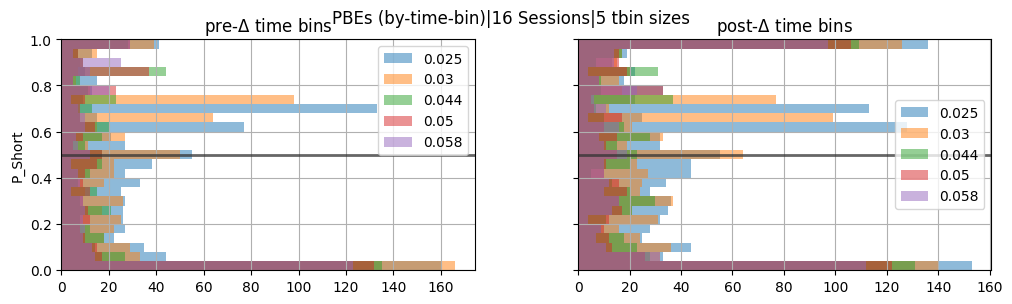

In [ ]:
matplotlib.use('Qt5Agg')
# grainularity_desc: str = 'by-time-bin'
# laps_df: pd.DataFrame = all_sessions_laps_time_bin_df
# ripple_df: pd.DataFrame = all_sessions_ripple_time_bin_df
_out_figs_dict = {}
_laps_histogram_out, _ripple_histogram_out = _perform_dual_hist_plot(grainularity_desc='by-time-bin', laps_df=all_sessions_laps_time_bin_df, ripple_df=all_sessions_ripple_time_bin_df,
                                                                    #   legend_groups_to_solo=[0.025], legend_groups_to_hide=None,
                                                                    #   legend_groups_to_solo=None, legend_groups_to_hide=[0.03, 0.0444, 0.05],
                                                                    )

_out_figs_dict[_laps_histogram_out.context.descriptor_str] = _laps_histogram_out.figures[0]
_out_figs_dict[_ripple_histogram_out.context.descriptor_str] = _ripple_histogram_out.figures[0]

# grainularity_desc: str = 'by-epoch'
# laps_df: pd.DataFrame = all_sessions_laps_df
# ripple_df: pd.DataFrame = all_sessions_ripple_df
_laps_histogram_out, _ripple_histogram_out = _perform_dual_hist_plot(grainularity_desc='by-epoch', laps_df=all_sessions_laps_df, ripple_df=all_sessions_ripple_df)
_out_figs_dict[_laps_histogram_out.context.descriptor_str] = _laps_histogram_out.figures[0]
_out_figs_dict[_ripple_histogram_out.context.descriptor_str] = _ripple_histogram_out.figures[0]
_out_figs_dict

In [ ]:

# display(_laps_histogram_out)
# display(_ripple_histogram_out)
fig_to_clipboard(_laps_histogram_out.figures[0], bbox_inches='tight')


In [ ]:
fig_to_clipboard(_ripple_histogram_out.figures[0], bbox_inches='tight')

In [ ]:

fig_to_clipboard(_laps_histogram_out.figures[0], bbox_inches='tight')

In [ ]:
fig_to_clipboard(_ripple_histogram_out.figures[0], bbox_inches='tight')

In [ ]:
from pyphocorehelpers.plotting.media_output_helpers import figure_to_pil_image, vertical_image_stack, horizontal_image_stack, image_grid

# fig_img = figure_to_pil_image(a_fig=_ripple_histogram_out.figures[0])
# fig_img

all_img_list = []
laps_list = []
PBEs_list = []

for a_key, a_fig in _out_figs_dict.items():
    fig_img = figure_to_pil_image(a_fig=a_fig)

    if 'Laps' in a_key:
        laps_list.append(fig_img)
        
    if 'PBEs' in a_key:
        PBEs_list.append(fig_img)
        
    all_img_list.append(fig_img)
    
# all_img_list

# vertical_image_stack(laps_list)
combined_all_img = vertical_image_stack([
    horizontal_image_stack(laps_list),
    horizontal_image_stack(PBEs_list)
])
combined_all_img

copy_image_to_clipboard(combined_all_img)

## 2025-07-29 - Including Scatter

In [ ]:
matplotlib.use('Qt5Agg')
# grainularity_desc: str = 'by-time-bin'
# laps_df: pd.DataFrame = all_sessions_laps_time_bin_df
# ripple_df: pd.DataFrame = all_sessions_ripple_time_bin_df
# _out_figs_dict = {}
_laps_histogram_out, _ripple_histogram_out = _perform_matplotlib_pre_post_scatter(grainularity_desc='by-time-bin', laps_df=all_sessions_laps_time_bin_df, ripple_df=all_sessions_ripple_time_bin_df,
                                                                    include_scatterplot=True,
                                                                    #   legend_groups_to_solo=[0.025], legend_groups_to_hide=None,
                                                                    #   legend_groups_to_solo=None, legend_groups_to_hide=[0.03, 0.0444, 0.05],
                                                                    )

# _out_figs_dict[_laps_histogram_out.context.descriptor_str] = _laps_histogram_out.fig
# _out_figs_dict[_ripple_histogram_out.context.descriptor_str] = _ripple_histogram_out.fig

# grainularity_desc: str = 'by-epoch'
# laps_df: pd.DataFrame = all_sessions_laps_df
# ripple_df: pd.DataFrame = all_sessions_ripple_df
_laps_histogram_out, _ripple_histogram_out = _perform_matplotlib_pre_post_scatter(grainularity_desc='by-epoch', laps_df=all_sessions_laps_df, ripple_df=all_sessions_ripple_df, include_scatterplot=True)
# _out_figs_dict[_laps_histogram_out.context.descriptor_str] = _laps_histogram_out.fig
# _out_figs_dict[_ripple_histogram_out.context.descriptor_str] = _ripple_histogram_out.fig
# _out_figs_dict

# 2024-11-18 - Collecting wcorr results from session_data folders:

In [ ]:
from pyphoplacecellanalysis.General.Batch.runBatch import get_file_path_if_file_exists
# from pyphoplacecellanalysis.SpecificResults.AcrossSessionResults import copy_session_folder_files_to_target_dir
from pyphocorehelpers.Filesystem.path_helpers import copy_movedict
from neuropy.core.user_annotations import UserAnnotationsManager
from pyphoplacecellanalysis.SpecificResults.AcrossSessionResults import AcrossSessionHelpers

copy_dict, moved_files_dict_files = AcrossSessionHelpers._copy_exported_files_from_session_folder_to_collected_outputs(BATCH_DATE_TO_USE='2024-11-19', cuttoff_date=datetime(2024, 11, 16), target_dir=collected_outputs_directory, is_dry_run=True)
# copy_dict, moved_files_dict_files = AcrossSessionHelpers._copy_exported_files_from_session_folder_to_collected_outputs(BATCH_DATE_TO_USE='2024-11-19', cuttoff_date=datetime(2024, 11, 16), target_dir=collected_outputs_directory, is_dry_run=False)
copy_dict
    

In [ ]:
len(all_found_parsed_csv_files_df_dict[a_session_basedir])
all_found_parsed_csv_files_df_dict[a_session_basedir]['_comparable_custom_replay_name'].unique()
all_found_parsed_csv_files_df_dict[a_session_basedir]['custom_replay_name'].unique()
len(all_found_parsed_csv_files_df_dict[a_session_basedir]['_comparable_custom_replay_name'].unique()), len(all_found_parsed_csv_files_df_dict[a_session_basedir]['custom_replay_name'].unique())
all_found_parsed_csv_files_df_dict[a_session_basedir]['path'].unique()

8, (7, 7) # compare_custom_replay_name_col_name: str = '_comparable_custom_replay_name' ## fewer total entries
9, (7, 8) # compare_custom_replay_name_col_name: str = 'custom_replay_name'

# "2024-11-18_1210PM-kdiba_gor01_one_2006-6-09_1-22-43__withNormalComputedReplays-qclu_[1, 2, 4, 6, 7, 9]-frateThresh_1.0-(ripple_WCorrShuffle_df)_tbin-0.025.csv" # "-" separator
# "2024-11-18_1210PM-kdiba_gor01_one_2006-6-09_1-22-43__withNormalComputedReplays_qclu_[1, 2, 4, 6, 7, 9]_frateThresh_1.0-(ripple_WCorrShuffle_df)_tbin-0.025.csv" # "_" separator

test_path: Path = Path('W:/Data/KDIBA/gor01/one/2006-6-09_1-22-43/output/2024-11-18_1020PM-kdiba_gor01_one_2006-6-09_1-22-43__withNormalComputedReplays_qclu_[1, 2, 4, 6, 7, 9]_frateThresh_1.0-(ripple_WCorrShuffle_df)_tbin-0.025.csv').resolve()
test_path

collected_outputs_directory.joinpath(test_path.name)

# 2025-03-17 - Collecting Final `FAT_CSV` Results

In [14]:
from pyphoplacecellanalysis.SpecificResults.AcrossSessionResults import AcrossSessionIdentityDataframeAccessor
from neuropy.utils.indexing_helpers import NeuroPyDataframeAccessor
from pyphocorehelpers.indexing_helpers import PhoDataframeAccessor

# # df_results = [_add_animal_name_to_session_key(df=deepcopy(v)) for v in df_results]


most_recent_parsed_FAT_csv_files_df: pd.DataFrame = deepcopy(most_recent_parsed_csv_files_df[most_recent_parsed_csv_files_df['export_datetime'] >= cuttoff_date].pho.constrain_df_cols(file_type='FAT')) # , known_named_decoding_epochs_type='pbe')
# Filter rows based on column: 'decoding_time_bin_size_str'
most_recent_parsed_FAT_csv_files_df = most_recent_parsed_FAT_csv_files_df[most_recent_parsed_FAT_csv_files_df['decoding_time_bin_size_str'] == "0.025"]
# Sort by column: 'export_datetime' (descending)
most_recent_parsed_FAT_csv_files_df = most_recent_parsed_FAT_csv_files_df.sort_values(['export_datetime'], ascending=[False])
print(f'================== Most Recent FAT .csv files:')
most_recent_parsed_FAT_csv_files_df

# df = df.across_session_identity.split_session_key_col_to_fmt_animal_exper_cols(session_key_col='session_name')
# FAT_df: pd.DataFrame = deepcopy(all_sessions_laps_time_bin_df) ## UNCOMMENT THIS LINE WHEN NEED TO UPDATE
# Initialize FAT_df only if it doesn't exist yet
if 'FAT_df' not in locals() or FAT_df is None:
    FAT_df = deepcopy(all_sessions_laps_time_bin_df)
    print("FAT_df initialized from all_sessions_laps_time_bin_df")
else:
    print("Using existing FAT_df")
    
## when is 'custom_replay_name' set?

# Always apply the transformation
FAT_df = FAT_df.across_session_identity.split_session_key_col_to_fmt_animal_exper_cols(session_key_col='session_name')
# FAT_df = FAT_df.across_session_identity.split_session_key_col_to_fmt_animal_exper_cols(session_key_col='session_name')

## add a 'session_novelty_rank' that's inversely weighted with experience (newer experence == bigger numbers):
max_experience_idx: int = np.nanmax(FAT_df['session_experience_rank'])
FAT_df['session_novelty_rank'] = np.nanmax(FAT_df['session_experience_rank']) - FAT_df['session_experience_rank'].map(dict(zip(np.arange(max_experience_idx+1), reversed(np.arange(max_experience_idx+1))))) ## reverse 

print(f'================== FAT_df:')
FAT_df

================== Most Recent FAT .csv files:


,export_datetime,session,custom_replay_name,decoding_time_bin_size_str,path,_comparable_custom_replay_name
925,2025-08-01 04:20:00,kdiba_gor01_two_2006-6-12_16-53-46,"withNormalComputedReplays-qclu_[1, 2, 4, 6, 7,...",0.025,K:\scratch\collected_outputs\2025-08-01_0420AM...,"withNormalComputedReplays-qclu-[1, 2, 4, 6, 7,..."
1401,2025-08-01 04:20:00,kdiba_vvp01_two_2006-4-10_12-58-3,"withNormalComputedReplays-qclu_[1, 2, 4, 6, 7,...",0.025,K:\scratch\collected_outputs\2025-08-01_0420AM...,"withNormalComputedReplays-qclu-[1, 2, 4, 6, 7,..."
1302,2025-08-01 04:20:00,kdiba_vvp01_two_2006-4-09_16-40-54,"withNormalComputedReplays-qclu_[1, 2, 4, 6, 7,...",0.025,K:\scratch\collected_outputs\2025-08-01_0420AM...,"withNormalComputedReplays-qclu-[1, 2, 4, 6, 7,..."
550,2025-08-01 04:20:00,kdiba_gor01_one_2006-6-12_15-55-31,"withNormalComputedReplays-qclu_[1, 2, 4, 6, 7,...",0.025,K:\scratch\collected_outputs\2025-08-01_0420AM...,"withNormalComputedReplays-qclu-[1, 2, 4, 6, 7,..."
1198,2025-08-01 04:00:00,kdiba_vvp01_one_2006-4-10_12-25-50,"withNormalComputedReplays-qclu_[1, 2, 4, 6, 7,...",0.025,K:\scratch\collected_outputs\2025-08-01_0400AM...,"withNormalComputedReplays-qclu-[1, 2, 4, 6, 7,..."
1025,2025-08-01 04:00:00,kdiba_pin01_one_11-03_12-3-25,"withNormalComputedReplays-qclu_[1, 2, 4, 6, 7,...",0.025,K:\scratch\collected_outputs\2025-08-01_0400AM...,"withNormalComputedReplays-qclu-[1, 2, 4, 6, 7,..."
772,2025-08-01 02:20:00,kdiba_gor01_two_2006-6-07_16-40-19,"withNormalComputedReplays-qclu_[1, 2, 4, 6, 7,...",0.025,K:\scratch\collected_outputs\2025-08-01_0220AM...,"withNormalComputedReplays-qclu-[1, 2, 4, 6, 7,..."
913,2025-08-01 02:20:00,kdiba_gor01_two_2006-6-09_22-24-40,"withNormalComputedReplays-qclu_[1, 2, 4, 6, 7,...",0.025,K:\scratch\collected_outputs\2025-08-01_0220AM...,"withNormalComputedReplays-qclu-[1, 2, 4, 6, 7,..."
1,2025-08-01 01:20:00,kdiba_gor01_one_2006-6-08_14-26-15,"withNormalComputedReplays-qclu_[1, 2, 4, 6, 7,...",0.025,K:\scratch\collected_outputs\2025-08-01_0120AM...,"withNormalComputedReplays-qclu-[1, 2, 4, 6, 7,..."
159,2025-07-31 23:20:00,kdiba_gor01_one_2006-6-09_1-22-43,"withNormalComputedReplays-qclu_[1, 2, 4, 6, 7,...",0.025,K:\scratch\collected_outputs\2025-07-31_1120PM...,"withNormalComputedReplays-qclu-[1, 2, 4, 6, 7,..."


FAT_df initialized from all_sessions_laps_time_bin_df
================== FAT_df:


,t,P_Long,P_Short,epoch_id,sub_epoch_time_bin_index,parent_epoch_id,parent_epoch_start_t,parent_epoch_end_t,delta_aligned_start_t,session_name,time_bin_size,pre_post_delta_category,trained_compute_epochs,known_named_decoding_epochs_type,masked_time_bin_fill_type,format_name,animal,exper_name,epochs_source,included_qclu_values,minimum_inclusion_fr_Hz,t_bin_center,is_t_bin_center_fake,P_LR,P_RL,long_LR,long_RL,short_LR,short_RL,parent_epoch_df_idx,result_t_bin_idx,parent_epoch_label,parent_epoch_duration,label,start,stop,pfND_ndim,decoder_identifier,data_grain,lap_idx,lap_start_t,epoch_idx,epoch_start_t,ripple_idx,ripple_start_t,decoding_time_bin_size,custom_replay_name,epoch_df_idx,P_Long_lr,P_Long_rl,P_Short_lr,P_Short_rl,session_experience_rank,session_experience_orientation_rank,is_novel_exposure,session_novelty_rank
0,5.660867,9.931877e-01,0.006812,0.0,0.0,0.0,5.635867,17.447765,-1205.897213,kdiba_gor01_one_2006-6-08_14-26-15,0.05,pre-delta,non_pbe,laps,ignore,kdiba,gor01,one,_withNormalComputedReplays,"[1, 2, 4, 6, 7, 8, 9]",0.2,5.660867,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"withNormalComputedReplays-qclu_[1, 2, 4, 6, 7,...",NaN,NaN,NaN,NaN,NaN,2,1,False,2
1,5.710867,9.087524e-01,0.091248,0.0,1.0,0.0,5.635867,17.447765,-1205.847213,kdiba_gor01_one_2006-6-08_14-26-15,0.05,pre-delta,non_pbe,laps,ignore,kdiba,gor01,one,_withNormalComputedReplays,"[1, 2, 4, 6, 7, 8, 9]",0.2,5.710867,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"withNormalComputedReplays-qclu_[1, 2, 4, 6, 7,...",NaN,NaN,NaN,NaN,NaN,2,1,False,2
2,5.760867,6.730091e-01,0.326991,0.0,2.0,0.0,5.635867,17.447765,-1205.797213,kdiba_gor01_one_2006-6-08_14-26-15,0.05,pre-delta,non_pbe,laps,ignore,kdiba,gor01,one,_withNormalComputedReplays,"[1, 2, 4, 6, 7, 8, 9]",0.2,5.760867,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"withNormalComputedReplays-qclu_[1, 2, 4, 6, 7,...",NaN,NaN,NaN,NaN,NaN,2,1,False,2
3,5.810867,9.785725e-01,0.021427,0.0,3.0,0.0,5.635867,17.447765,-1205.747213,kdiba_gor01_one_2006-6-08_14-26-15,0.05,pre-delta,non_pbe,laps,ignore,kdiba,gor01,one,_withNormalComputedReplays,"[1, 2, 4, 6, 7, 8, 9]",0.2,5.810867,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"withNormalComputedReplays-qclu_[1, 2, 4, 6, 7,...",NaN,NaN,NaN,NaN,NaN,2,1,False,2
4,5.860867,9.754292e-01,0.024571,0.0,4.0,0.0,5.635867,17.447765,-1205.697213,kdiba_gor01_one_2006-6-08_14-26-15,0.05,pre-delta,non_pbe,laps,ignore,kdiba,gor01,one,_withNormalComputedReplays,"[1, 2, 4, 6, 7, 8, 9]",0.2,5.860867,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"withNormalComputedReplays-qclu_[1, 2, 4, 6, 7,...",NaN,NaN,NaN,NaN,NaN,2,1,False,2
5,5.910867,9.900484e-01,0.009952,0.0,5.0,0.0,5.635867,17.447765,-1205.647213,kdiba_gor01_one_2006-6-08_14-26-15,0.05,pre-delta,non_pbe,laps,ignore,kdiba,gor01,one,_withNormalComputedReplays,"[1, 2, 4, 6, 7, 8, 9]",0.2,5.910867,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"withNormalComputedReplays-qclu_[1, 2, 4, 6, 7,...",NaN,NaN,NaN,NaN,NaN,2,1,False,2
6,5.960867,2.851744e-01,0.714826,0.0,6.0,0.0,5.635867,17.447765,-1205.597213,kdiba_gor01_one_2006-6-08_14-26-15,0.05,pre-delta,non_pbe,laps,ignore,kdiba,gor01,one,_withNormalComputedReplays,"[1, 2, 4, 6, 7, 8, 9]",0.2,5.960867,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"withNormalComputedReplays-qclu_[1, 2, 4, 6, 7,...",NaN,NaN,NaN,NaN,NaN,2,1,False,2
7,6.010867,9.892484e-01,0.010752,0.0,7.0,0.0,5.635867,17.447765,-1205.547213,kdiba_gor01_one_2006-6-08_14-26-15,0.05,pre-delta,non_pbe,laps,ignore,kdiba,gor01,one,_withNormalComputedReplays,"[1, 2, 4, 6, 7, 8, 9]",0.2,6.010867,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N

In [ ]:
## has 'session_experience_rank', 'session_experience_orientation_rank', 'is_novel_exposure'
num_ranks = np.nanmax(FAT_df['session_experience_rank']) 
dict(zip(np.arange(num_ranks+1), reversed(np.arange(num_ranks+1))))

unique_values_dict = FAT_df.neuropy.get_column_unique_values_dict(columns_include_subset=['known_named_decoding_epochs_type', 'trained_compute_epochs', 'masked_time_bin_fill_type', 'time_bin_size'])
unique_values_dict

In [ ]:
a_df_dict: Dict[str, pd.DataFrame] = FAT_df.pho.partition_df_dict(partitionColumn='known_named_decoding_epochs_type')
list(a_df_dict.keys())

a_df_dict: Dict[str, pd.DataFrame] = FAT_df.pho.partition_df_dict(partitionColumn='known_named_decoding_epochs_type')
list(a_df_dict.keys())

#### Extract required dataframes for `DataFrameFilter`

In [15]:
all_sessions_ripple_df = deepcopy(FAT_df.pho.constrain_df_cols(data_grain='per_epoch', known_named_decoding_epochs_type='pbe')) # , decoder_identifier='pseudo2D', masked_time_bin_fill_type=['ignore'], trained_compute_epochs='laps'
all_sessions_ripple_time_bin_df = deepcopy(FAT_df.pho.constrain_df_cols(data_grain='per_time_bin', known_named_decoding_epochs_type='pbe'))

all_sessions_laps_df = deepcopy(FAT_df.pho.constrain_df_cols(data_grain='per_epoch', known_named_decoding_epochs_type='laps'))
all_sessions_laps_time_bin_df = deepcopy(FAT_df.pho.constrain_df_cols(data_grain='per_time_bin', known_named_decoding_epochs_type='laps'))

all_sessions_nonPBE_endcap_df = deepcopy(FAT_df.pho.constrain_df_cols(data_grain='per_epoch', known_named_decoding_epochs_type='non_pbe_endcaps')) # , decoder_identifier='pseudo2D', masked_time_bin_fill_type=['ignore'], trained_compute_epochs='laps'
all_sessions_nonPBE_endcap_time_bin_df = deepcopy(FAT_df.pho.constrain_df_cols(data_grain='per_time_bin', known_named_decoding_epochs_type='non_pbe_endcaps'))


_perform_update_df_context_metadata(data_context = IdentifyingContext(epochs_name='laps', data_grain='per_epoch', title_prefix="Lap Per Epoch", dataframe_name='df'), concatenated_ripple_df=all_sessions_laps_df)
_perform_update_df_context_metadata(data_context = IdentifyingContext(epochs_name='laps', data_grain='per_time_bin', title_prefix="Lap Individual Time Bins", dataframe_name='time_bin_df'), concatenated_ripple_df=all_sessions_laps_time_bin_df)
_perform_update_df_context_metadata(data_context = IdentifyingContext(epochs_name='PBE', data_grain='per_epoch', title_prefix="PBE Per Epoch", dataframe_name='df'), concatenated_ripple_df = all_sessions_ripple_df)
_perform_update_df_context_metadata(data_context = IdentifyingContext(epochs_name='PBE', data_grain='per_time_bin', title_prefix="PBE Individual Time Bins", dataframe_name='time_bin_df'), concatenated_ripple_df = all_sessions_ripple_time_bin_df)
_perform_update_df_context_metadata(data_context = IdentifyingContext(epochs_name='PBE', data_grain='per_epoch', dataframe_name='MultiMeasure_ripple_df', title_prefix="multiMeasure - PBE Per Epoch"), concatenated_ripple_df = all_sessions_MultiMeasure_ripple_df)
_perform_update_df_context_metadata(data_context = IdentifyingContext(epochs_name='PBE', data_grain='per_epoch', dataframe_name='all_scores_ripple_df', title_prefix="allScores - PBE Per Epoch"), concatenated_ripple_df = all_sessions_all_scores_ripple_df)
_perform_update_df_context_metadata(data_context = IdentifyingContext(epochs_name='laps', data_grain='per_epoch', dataframe_name='MultiMeasure_laps_df', title_prefix="multiMeasure - Lap Per Epoch"), concatenated_ripple_df = all_sessions_MultiMeasure_laps_df)

_perform_update_df_context_metadata(data_context = IdentifyingContext(epochs_name='non_pbe_endcaps', data_grain='per_epoch', title_prefix="ENDCAPs Per Epoch", dataframe_name='df'), concatenated_ripple_df = all_sessions_nonPBE_endcap_df)
_perform_update_df_context_metadata(data_context = IdentifyingContext(epochs_name='non_pbe_endcaps', data_grain='per_time_bin', title_prefix="ENDCAPs Individual Time Bins", dataframe_name='time_bin_df'), concatenated_ripple_df = all_sessions_nonPBE_endcap_time_bin_df)

_perform_update_df_context_metadata(data_context = IdentifyingContext(title_prefix="FAT df", dataframe_name='FAT_df'), concatenated_ripple_df=FAT_df)




## OUTPUTS: all_sessions_nonPBE_endcap_df, all_sessions_nonPBE_endcap_time_bin_df, 

In [ ]:
# all_sessions_nonPBE_endcap_df ## empty
all_sessions_nonPBE_endcap_time_bin_df
# all_sessions_nonPBE_endcap_time_bin_df['P_Short']

# 2025-04-21 - ⚓🟢 Proper matching

In [ ]:
## INPUTS: FAT_df, all_sessions_ripple_time_bin_df
## INPUTS: all_sessions_all_scores_ripple_df, all_sessions_ripple_time_bin_df
# FAT_df
all_sessions_all_scores_ripple_df

In [ ]:
print(list(all_sessions_ripple_df.columns))

In [ ]:
## ULTIMATELY ADD TO THIS ONE: all_sessions_ripple_time_bin_df
# all_sessions_ripple_time_bin_df

time_bin_size = 0.025
# time_bin_size = 0.05
custom_replay_name = 'withNormalComputedReplays-qclu_[1, 2, 4, 6, 7, 8, 9]-frateThresh_5.0'
# custom_replay_name = 'withNormalComputedReplays-qclu_[1, 2]-frateThresh_5.0'

_common_filter_dict = dict(custom_replay_name=custom_replay_name, time_bin_size=time_bin_size, )
_extended_common_filter_dict = dict(trained_compute_epochs='laps', masked_time_bin_fill_type='ignore', epochs_source='_withNormalComputedReplays')


# _CONSTRAINED_FAT_df: pd.DataFrame = deepcopy(all_sessions_ripple_time_bin_df).pho.constrain_df_cols(custom_replay_name=custom_replay_name, time_bin_size=time_bin_size, **_extended_common_filter_dict)
# _CONSTRAINED_FAT_df = _CONSTRAINED_FAT_df.dropna(axis=1, how='all', inplace=False)
# _CONSTRAINED_FAT_df

_CONSTRAINED_FAT_all_sessions_ripple_by_epoch_df: pd.DataFrame = deepcopy(all_sessions_ripple_df).pho.constrain_df_cols(**_common_filter_dict, **_extended_common_filter_dict)
if 'duration' not in _CONSTRAINED_FAT_all_sessions_ripple_by_epoch_df:
    _CONSTRAINED_FAT_all_sessions_ripple_by_epoch_df['duration'] = _CONSTRAINED_FAT_all_sessions_ripple_by_epoch_df['stop'] - _CONSTRAINED_FAT_all_sessions_ripple_by_epoch_df['start']
_CONSTRAINED_FAT_all_sessions_ripple_by_epoch_df = _CONSTRAINED_FAT_all_sessions_ripple_by_epoch_df.dropna(axis=1, how='all', inplace=False)
_CONSTRAINED_FAT_all_sessions_ripple_by_epoch_df


_CONSTRAINED_FAT_all_sessions_ripple_time_bin_df: pd.DataFrame = deepcopy(all_sessions_ripple_time_bin_df).pho.constrain_df_cols(**_common_filter_dict, **_extended_common_filter_dict)
_CONSTRAINED_FAT_all_sessions_ripple_time_bin_df = _CONSTRAINED_FAT_all_sessions_ripple_time_bin_df.dropna(axis=1, how='all', inplace=False)
_CONSTRAINED_FAT_all_sessions_ripple_time_bin_df


# _CONSTRAINED_FAT_df: pd.DataFrame = deepcopy(FAT_df).pho.constrain_df_cols(custom_replay_name='withNormalComputedReplays-qclu_[1, 2, 4, 6, 7, 8, 9]-frateThresh_5.0', time_bin_size=0.05, **_extended_common_filter_dict)
# _CONSTRAINED_FAT_df = _CONSTRAINED_FAT_df.dropna(axis=1, how='all', inplace=False)
# _CONSTRAINED_FAT_df

_CONSTRAINED_all_sessions_ripple_by_epoch_df: pd.DataFrame = deepcopy(all_sessions_all_scores_ripple_df).pho.constrain_df_cols(**_common_filter_dict) # , **_extended_common_filter_dict
_CONSTRAINED_all_sessions_ripple_by_epoch_df = _CONSTRAINED_all_sessions_ripple_by_epoch_df.dropna(axis=1, how='all', inplace=False)
if 'duration' not in _CONSTRAINED_all_sessions_ripple_by_epoch_df:
    _CONSTRAINED_all_sessions_ripple_by_epoch_df['duration'] = _CONSTRAINED_all_sessions_ripple_by_epoch_df['stop'] - _CONSTRAINED_all_sessions_ripple_by_epoch_df['start']
_CONSTRAINED_all_sessions_ripple_by_epoch_df

# _CONSTRAINED_all_sessions_ripple_time_bin_df: pd.DataFrame = deepcopy(all_sessions_all_scores_ripple_df).pho.constrain_df_cols(custom_replay_name=custom_replay_name, time_bin_size=time_bin_size) # , **_extended_common_filter_dict
# _CONSTRAINED_all_sessions_ripple_time_bin_df = _CONSTRAINED_all_sessions_ripple_time_bin_df.dropna(axis=1, how='all', inplace=False)
# _CONSTRAINED_all_sessions_ripple_time_bin_df


## OUTPUTS: ['parent_epoch_label']



### Enumerating Available Values

In [ ]:
unique_values_dict = FAT_df.neuropy.get_column_unique_values_dict(columns_include_subset=['custom_replay_name', 'included_qclu_values', 'minimum_inclusion_fr_Hz', 'time_bin_size']) # , 'masked_time_bin_fill_type'
unique_values_dict
unique_values_dict = FAT_df.neuropy.get_flat_unique_values(columns_include_subset=['custom_replay_name', 'included_qclu_values', 'minimum_inclusion_fr_Hz', 'time_bin_size']) # , 'masked_time_bin_fill_type'
unique_values_dict

# {Context(custom_replay_name= 'withNormalComputedReplays-qclu_[1, 2, 4, 6, 7, 8, 9]-frateThresh_5.0', included_qclu_values= '[1, 2, 4, 6, 7, 8, 9]', minimum_inclusion_fr_Hz= 5.0, time_bin_size= 0.05): 2355955,
#  Context(custom_replay_name= 'withNormalComputedReplays-qclu_[1, 2]-frateThresh_5.0', included_qclu_values= '[1, 2]', minimum_inclusion_fr_Hz= 5.0, time_bin_size= 0.05): 2291178,
#  Context(custom_replay_name= 'withNormalComputedReplays-qclu_[1, 2, 4, 6, 7, 9]-frateThresh_5.0', included_qclu_values= '[1, 2, 4, 6, 7, 9]', minimum_inclusion_fr_Hz= 5.0, time_bin_size= 0.05): 998617,
#  Context(custom_replay_name= 'withNormalComputedReplays-qclu_[1, 2, 4, 6, 7, 9]-frateThresh_5.0', included_qclu_values= '[1, 2, 4, 6, 7, 9]', minimum_inclusion_fr_Hz= 5.0, time_bin_size= 0.025): 633693}

unique_values_dict = FAT_df.neuropy.get_hierarchical_counts(columns_include_subset=['custom_replay_name', 'included_qclu_values', 'minimum_inclusion_fr_Hz', 'time_bin_size']) # , 'masked_time_bin_fill_type'
unique_values_dict


# {'withNormalComputedReplays-qclu_[1, 2, 4, 6, 7, 8, 9]-frateThresh_5.0': {'[1, 2, 4, 6, 7, 8, 9]': {5.0: {0.025: 4573952}}},
#  'withNormalComputedReplays-qclu_[1, 2, 4, 6, 7, 9]-frateThresh_5.0': {'[1, 2, 4, 6, 7, 9]': {5.0: {0.025: 1331618}}},
#  'withNormalComputedReplays-qclu_[1, 2]-frateThresh_5.0': {'[1, 2]': {5.0: {0.025: 884945}}}}






### Trying to combine the scores and the epochs

In [ ]:
## look up the value of the ['start', 'stop', 'duration'] columns in `_CONSTRAINED_FAT_all_sessions_ripple_by_epoch_df` based on the _CONSTRAINED_FAT_all_sessions_ripple_by_epoch_df['label'] that matches `_CONSTRAINED_FAT_all_sessions_ripple_time_bin_df['parent_epoch_label']`. Add the ['start', 'stop', 'duration'] values to `_CONSTRAINED_FAT_all_sessions_ripple_time_bin_df` as columns ['parent_epoch_start', 'parent_epoch_stop', 'parent_epoch_duration'] 
# _CONSTRAINED_FAT_all_sessions_ripple_time_bin_df['parent_epoch_label'].map(_CONSTRAINED_FAT_all_sessions_ripple_by_epoch_df['label'])
# Create a mapping dictionary from label to the required columns
# epoch_mapping = _CONSTRAINED_FAT_all_sessions_ripple_by_epoch_df.set_index('label')[['start', 'stop', 'duration']].to_dict('index')
epoch_mapping = _CONSTRAINED_FAT_all_sessions_ripple_by_epoch_df.set_index('label')[['session_name', 'start', 'stop', 'duration']].to_dict('index')

# Add the parent epoch information to the time bin DataFrame
_CONSTRAINED_FAT_all_sessions_ripple_time_bin_df['parent_epoch_start'] = _CONSTRAINED_FAT_all_sessions_ripple_time_bin_df['parent_epoch_label'].map(lambda x: epoch_mapping.get(x, {}).get('start'))
_CONSTRAINED_FAT_all_sessions_ripple_time_bin_df['parent_epoch_stop'] = _CONSTRAINED_FAT_all_sessions_ripple_time_bin_df['parent_epoch_label'].map(lambda x: epoch_mapping.get(x, {}).get('stop'))
_CONSTRAINED_FAT_all_sessions_ripple_time_bin_df['parent_epoch_duration'] = _CONSTRAINED_FAT_all_sessions_ripple_time_bin_df['parent_epoch_label'].map(lambda x: epoch_mapping.get(x, {}).get('duration'))
_CONSTRAINED_FAT_all_sessions_ripple_time_bin_df



In [ ]:
# Create a composite key in both DataFrames for mapping
# First, ensure both DataFrames have the required columns
# required_columns = ['custom_replay_name', 'session_name', 'label']
required_columns = ['session_name', 'label']

# Create a mapping dictionary using multiple columns as a composite key
# First, create a tuple of the key columns for each row
_CONSTRAINED_FAT_all_sessions_ripple_by_epoch_df['composite_key'] = _CONSTRAINED_FAT_all_sessions_ripple_by_epoch_df.apply(
    lambda row: (row['session_name'], row['label']), axis=1
)

# _CONSTRAINED_FAT_all_sessions_ripple_by_epoch_df['composite_key'] = _CONSTRAINED_FAT_all_sessions_ripple_by_epoch_df.apply(
#     lambda row: (row['custom_replay_name'], row['session_name'], row['label']), axis=1
# )

# Create the mapping dictionary
epoch_mapping = dict(zip(
    _CONSTRAINED_FAT_all_sessions_ripple_by_epoch_df['composite_key'],
    _CONSTRAINED_FAT_all_sessions_ripple_by_epoch_df[['start', 'stop', 'duration']].to_dict('records')
))

# Create the same composite key in the target DataFrame
# _CONSTRAINED_FAT_all_sessions_ripple_time_bin_df['composite_key'] = _CONSTRAINED_FAT_all_sessions_ripple_time_bin_df.apply(
#     lambda row: (row['custom_replay_name'], row['session_name'], row['parent_epoch_label']), axis=1
# )

_CONSTRAINED_FAT_all_sessions_ripple_time_bin_df['composite_key'] = _CONSTRAINED_FAT_all_sessions_ripple_time_bin_df.apply(
    lambda row: (row['session_name'], row['parent_epoch_label']), axis=1
)

# Map the values using the composite key
_CONSTRAINED_FAT_all_sessions_ripple_time_bin_df['parent_epoch_start'] = _CONSTRAINED_FAT_all_sessions_ripple_time_bin_df['composite_key'].map(
    lambda x: epoch_mapping.get(x, {}).get('start')
)
_CONSTRAINED_FAT_all_sessions_ripple_time_bin_df['parent_epoch_stop'] = _CONSTRAINED_FAT_all_sessions_ripple_time_bin_df['composite_key'].map(
    lambda x: epoch_mapping.get(x, {}).get('stop')
)
_CONSTRAINED_FAT_all_sessions_ripple_time_bin_df['parent_epoch_duration'] = _CONSTRAINED_FAT_all_sessions_ripple_time_bin_df['composite_key'].map(
    lambda x: epoch_mapping.get(x, {}).get('duration')
)

# Optionally, remove the temporary composite_key column
_CONSTRAINED_FAT_all_sessions_ripple_time_bin_df.drop('composite_key', axis=1, inplace=True)
_CONSTRAINED_FAT_all_sessions_ripple_by_epoch_df.drop('composite_key', axis=1, inplace=True)

## OUTPUTS: _CONSTRAINED_FAT_all_sessions_ripple_time_bin_df
_CONSTRAINED_FAT_all_sessions_ripple_time_bin_df
_CONSTRAINED_FAT_all_sessions_ripple_by_epoch_df

In [ ]:
_CONSTRAINED_FAT_all_sessions_ripple_time_bin_df

In [ ]:
from neuropy.core.epoch import find_epochs_overlapping_other_epochs

## INPUTS: _CONSTRAINED_FAT_all_sessions_ripple_time_bin_df, _CONSTRAINED_all_sessions_ripple_by_epoch_df, 
# _CONSTRAINED_FAT_df['parent_epoch_label']

# continuous_time_binned_computation_epochs_df: pd.DataFrame = pd.DataFrame({'start': left_edges, 'stop': right_edges, 'label': np.arange(len(left_edges))})

continuous_time_binned_computation_epochs_df: pd.DataFrame = _CONSTRAINED_FAT_all_sessions_ripple_time_bin_df[['start', 'stop', 'label']]

_CONSTRAINED_FAT_all_sessions_ripple_time_bin_df['is_all_scores_epoch_included'] = False
is_timebin_included: NDArray = find_epochs_overlapping_other_epochs(epochs_df=continuous_time_binned_computation_epochs_df, epochs_df_required_to_overlap=deepcopy(_CONSTRAINED_all_sessions_ripple_by_epoch_df))
_CONSTRAINED_FAT_all_sessions_ripple_time_bin_df['is_all_scores_epoch_included'] = is_timebin_included

In [ ]:
_CONSTRAINED_FAT_all_sessions_ripple_time_bin_df

In [ ]:
np.sum(_CONSTRAINED_FAT_all_sessions_ripple_time_bin_df['is_all_scores_epoch_included'])

### IDK, exploration?


In [ ]:
from pyphocorehelpers.indexing_helpers import get_dict_subset

# column_constraints = {'masked_time_bin_fill_type': 'ignore'}
# matching_column_names = ['session_name', 'time_bin_size', 'trained_compute_epochs', 'format_name', 'animal', 'exper_name', 'epochs_source', 'included_qclu_values', 'minimum_inclusion_fr_Hz', 't_bin_center']  # ['start', 'stop']
matching_column_names = ['session_name', 'format_name', 'animal', 'exper_name', 'included_qclu_values', 'minimum_inclusion_fr_Hz', 'result_t_bin_idx', 'epoch_df_idx']

# matching_column_names
# all_sessions_ripple_df
# FAT_df

# # all_sessions_all_scores_ripple_df
# ## MATCH ON THIS ONE: all_sessions_ripple_df
_CONSTRAINED_all_sessions_ripple_df = deepcopy(all_sessions_ripple_df).pho.constrain_df_cols(custom_replay_name='withNormalComputedReplays-qclu_[1, 2, 4, 6, 7, 8, 9]-frateThresh_5.0', time_bin_size=0.05, trained_compute_epochs='laps', masked_time_bin_fill_type='ignore', epochs_source='_withNormalComputedReplays')
_CONSTRAINED_all_sessions_ripple_df['duration'] = _CONSTRAINED_all_sessions_ripple_df['stop'] - _CONSTRAINED_all_sessions_ripple_df['start']
_CONSTRAINED_all_sessions_ripple_df

_EPOCH_to_df_MAP = {tuple(get_dict_subset(an_epoch_tuple._asdict(), included_keys=matching_column_names, require_all_keys=True).values()):an_epoch_tuple.duration  for an_epoch_tuple in _CONSTRAINED_all_sessions_ripple_df.itertuples(name='EpochResultTuple')}
# _EPOCH_to_df_MAP = {an_epoch_tuple.t_bin_center:an_epoch_tuple.duration  for an_epoch_tuple in EPOCH_VER_df.itertuples(name='EpochResultTuple')}
_EPOCH_to_df_MAP

# Performed 3 aggregations grouped on columns: 'animal', 'format_name' and 8 other columns
# FAT_df = FAT_df.groupby(['animal', 'format_name', 'exper_name', 'epochs_source', 'session_name', 'time_bin_size', 'minimum_inclusion_fr_Hz', 'included_qclu_values', 'result_t_bin_idx', 'epoch_df_idx']).agg(start_first=('start', 'first'), stop_last=('stop', 'last'), t_count=('t', 'count')).reset_index()
FAT_df

# _CONSTRAINED_all_sessions_ripple_time_bin_df['parent_epoch_duration'] = 
# _CONSTRAINED_all_sessions_ripple_time_bin_df.applymap(lambda x: _EPOCH_to_df_MAP.get(x, None))
# _CONSTRAINED_all_sessions_ripple_time_bin_df

In [ ]:
all_sessions_all_scores_ripple_df

In [ ]:
print(list(_CONSTRAINED_all_sessions_ripple_df.columns))

['result_t_bin_idx', 'epoch_df_idx', 'parent_epoch_label', 'label']

In [ ]:
from neuropy.utils.mixins.indexing_helpers import get_dict_subset

### GET THE EPOCH version's data mapping
## INPUTS: df_filter
EPOCH_VER_df: pd.DataFrame = deepcopy(df_filter.active_plot_df)
is_high_main_seq_len = df_filter.additional_filter_predicates['high_main_seq_len'](df_filter.active_plot_df)
is_low_main_seq_len = df_filter.additional_filter_predicates['low_main_seq_len'](df_filter.active_plot_df)

EPOCH_VER_df['is_high_main_seq_len'] = is_high_main_seq_len
EPOCH_VER_df['is_low_main_seq_len'] = is_low_main_seq_len
EPOCH_VER_df
# get_dict_subset(a_dict: dict, subset_includelist=None, subset_excludelist=None)

_EPOCH_to_df_MAP = {tuple(get_dict_subset(an_epoch_tuple._asdict(), subset_includelist=['session_name', 'time_bin_size', 'trained_compute_epochs', 'format_name', 'animal', 'exper_name', 'epochs_source', 'included_qclu_values', 'minimum_inclusion_fr_Hz', 'start', 'stop']).values()):an_epoch_tuple.duration  for an_epoch_tuple in EPOCH_VER_df.itertuples(name='EpochResultTuple')}
# _EPOCH_to_df_MAP = {an_epoch_tuple.t_bin_center:an_epoch_tuple.duration  for an_epoch_tuple in EPOCH_VER_df.itertuples(name='EpochResultTuple')}
_EPOCH_to_df_MAP


# # all_sessions_ripple_df = deepcopy(FAT_df.pho.constrain_df_cols(data_grain='per_epoch', known_named_decoding_epochs_type='pbe')) # , decoder_identifier='pseudo2D', masked_time_bin_fill_type=['ignore'], trained_compute_epochs='laps'



In [ ]:
unique_values_dict = FAT_df.neuropy.get_column_unique_values_dict(columns_include_subset=['custom_replay_name', 'included_qclu_values', 'minimum_inclusion_fr_Hz', 'time_bin_size']) # , 'masked_time_bin_fill_type'
unique_values_dict

In [ ]:
unique_values_dict = all_sessions_all_scores_ripple_df.neuropy.get_column_unique_values_dict(columns_include_subset=['custom_replay_name', 'time_bin_size']) # , 'masked_time_bin_fill_type', 'included_qclu_values', 'minimum_inclusion_fr_Hz'
unique_values_dict

In [ ]:
unique_values_dict = FAT_df.neuropy.get_column_unique_values_dict(columns_include_subset=['custom_replay_name', 'known_named_decoding_epochs_type', 'trained_compute_epochs', 'masked_time_bin_fill_type', 'time_bin_size'])
unique_values_dict

# 2025-03-17 `DataFrameFilter` with FAT result

In [ ]:
## Save out all final dfs to CSV
## INPUTS: all_sessions_ripple_time_bin_df
# export_path = Path(r'C:\Users\pho\repos\Spike3DWorkEnv\Spike3D\data\FAT_df_result_CSVs')
export_path = Path('data', 'FAT_df_result_CSVs').resolve()
export_path.mkdir(parents=False, exist_ok=True)
Assert.path_exists(export_path)

all_sessions_laps_df.to_csv(f'{export_path}/all_sessions_laps_df.csv', index=True)
all_sessions_laps_time_bin_df.to_csv(f'{export_path}/all_sessions_laps_time_bin_df.csv', index=True)
all_sessions_ripple_df.to_csv(f'{export_path}/all_sessions_ripple_df.csv', index=True)
all_sessions_ripple_time_bin_df.to_csv(f'{export_path}/all_sessions_ripple_time_bin_df.csv', index=True)
FAT_df.to_csv(f'{export_path}/FAT_df.csv', index=True)

# Publication Figures

#### 2025-06-09 - Loading Across Session Tables for fig gen
Loads the new unified "neuron_replay_stats_df.csv" files for each session, which contain the 3 old tables combined

In [20]:
from neuropy.core.user_annotations import UserAnnotationsManager, SessionCellExclusivityRecord
from neuropy.utils.result_context import IdentifyingContext
from pyphoplacecellanalysis.SpecificResults.PhoDiba2023Paper import pho_stats_perform_diagonal_line_binomial_test, pho_stats_bar_graph_t_tests

from pyphoplacecellanalysis.General.Mixins.ExportHelpers import FigureOutputLocation, ContextToPathMode, FileOutputManager # used in post_compute_all_sessions_processing
from pyphoplacecellanalysis.SpecificResults.PhoDiba2023Paper import PaperFigureTwo # used in post_compute_all_sessions_processing
from pyphoplacecellanalysis.SpecificResults.AcrossSessionResults import InstantaneousFiringRatesDataframeAccessor
from pyphoplacecellanalysis.General.Pipeline.Stages.ComputationFunctions.MultiContextComputationFunctions.LongShortTrackComputations import SingleBarResult
from pyphoplacecellanalysis.General.Pipeline.Stages.ComputationFunctions.MultiContextComputationFunctions.LongShortTrackComputations import InstantaneousSpikeRateGroupsComputation
from pyphoplacecellanalysis.SpecificResults.AcrossSessionResults import AcrossSessionsVisualizations
from pyphoplacecellanalysis.SpecificResults.PhoDiba2023Paper import PaperFigureTwo

from pyphoplacecellanalysis.SpecificResults.AcrossSessionResults import AcrossSessionsResults, AcrossSessionTables, AcrossSessionsVisualizations
from pyphocorehelpers.plotting.media_output_helpers import PDFHelpers
from neuropy.utils.indexing_helpers import flatten
from neuropy.utils.mixins.indexing_helpers import pop_dict_subset, get_dict_subset
#TODO 2025-06-12 07:57: - [ ] Currently the files are manually copied to a new folder so we don't have to deal with CSV versioning: "K:/scratch/collected_outputs/2025-06-11"

# ==================================================================================================================================================================================================================================================================================== #
# IMPORTANT! Set up matplotlib's rcParameters                                                                                                                                                                                                                                          #
# ==================================================================================================================================================================================================================================================================================== #
import matplotlib as mpl
from neuropy.plotting.figure import Fig

mpl_rcParams_style_dict = Fig.get_mpl_style(style='figPublish')
mpl.rcParams.update(mpl_rcParams_style_dict)
mpl.rcParams.update(**{'savefig.transparent': True, 'ps.fonttype': 42, 'pdf.fonttype': 42, })
# Set default font to Arial
plt.rcParams['font.family'] = 'Arial'
label_size = 6
mpl.rcParams['xtick.labelsize'] = label_size 
mpl.rcParams['ytick.labelsize'] = label_size 

# tables_load_path = Path(r'K:\scratch\across_sessions\2024-09-26_Apogee').resolve()
# override_output_parent_path = Path(r'K:\scratch\across_sessions').resolve()

## OUTPUTS: all_neuron_stats_table

# load_path = Path(r'C:/Users/pho/repos/Spike3DWorkEnv/Spike3D/output/collected_outputs').resolve()
# load_path = Path(r'K:/scratch/collected_outputs/2025-06-11_GL').resolve()



# load_path = collected_outputs_directory.joinpath('2025-07-08_GL').resolve()
# load_path = collected_outputs_directory.joinpath('2025-07-15_GL').resolve()
# load_path = collected_outputs_directory.joinpath('2025-08-05_GL').resolve()
load_path = collected_outputs_directory.joinpath('2025-08-08_GL').resolve()
# load_path = Path('/home/halechr/FastData/collected_outputs/2025-06-11_GL').resolve() # Lab

# K:/scratch/collected_outputs/2025-06-10
Assert.path_exists(load_path)

override_output_parent_path = deepcopy(load_path.parent)
# override_output_parent_path = Path(r'K:\scratch\collected_outputs').resolve()
Assert.path_exists(override_output_parent_path)
output_path_suffix: str = load_path.name
# output_path_suffix: str = '2024-09-26_Apogee'
# output_path_suffix: str = '2025-04-17'
# output_path_suffix: str = '2025-06-11'
# output_path_suffix: str = '2025-06-11_Apogee'

## OUTPUTS: override_output_parent_path, output_path_suffix

# Build from 3 separate exports ______________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________ #
# neuron_identities_table, long_short_fr_indicies_analysis_table, neuron_replay_stats_table = AcrossSessionTables.load_all_combined_tables(override_output_parent_path=override_output_parent_path, output_path_suffix=output_path_suffix) # output_path_suffix=f'2023-10-04-GL-Recomp' ## Load all across-session tables from the pickles
# ## Combine all unique columns from the three loaded dataframes: [neuron_identities_table, long_short_fr_indicies_analysis_table, neuron_replay_stats_table], into a merged df `all_neuron_stats_table`
# ## All dataframes have the same number of rows and are uniquely indexed by their 'neuron_uid' column. Add the additional columns from `long_short_fr_indicies_analysis_table` to `all_neuron_stats_table`
# all_neuron_stats_table: pd.DataFrame = deepcopy(neuron_identities_table)
# all_neuron_stats_table = pd.merge(all_neuron_stats_table, long_short_fr_indicies_analysis_table[['neuron_uid'] + [col for col in long_short_fr_indicies_analysis_table.columns if col not in all_neuron_stats_table.columns and col != 'neuron_uid']], on='neuron_uid')
# all_neuron_stats_table = pd.merge(all_neuron_stats_table, neuron_replay_stats_table[['neuron_uid'] + [col for col in neuron_replay_stats_table.columns if col not in all_neuron_stats_table.columns and col != 'neuron_uid']], on='neuron_uid') ## merge in `neuron_replay_stats_table`'s columns
# all_neuron_stats_table

# 2025-06-10 - Single load combined tables output ____________________________________________________________________________________________________________________________________________________________________________________________________________________________________ #
# "2025-06-11_GL-2006-4-09_16-40-54_neuron_replay_stats_df.csv" -- exported by `compute_and_export_session_extended_placefield_peak_information_completion_function`
all_neuron_stats_table, all_loaded_csv_dfs = AcrossSessionsResults.load_all_neuron_identities_CSV(override_output_parent_path=override_output_parent_path, output_path_suffix=output_path_suffix)
num_sessions: int = len(all_neuron_stats_table.session_uid.unique())
print(f'num_sessions: {num_sessions}')


# cell_LS_fr_percent_change_eXclusivity_threshold: bool = 5.0
# # #TODO 2025-07-08 13:01: - [ ] Temp fixup
# all_neuron_stats_table = all_neuron_stats_table
# all_neuron_stats_table['pct_LS_fr_Hz'] = (all_neuron_stats_table['short_fr_Hz'] - all_neuron_stats_table['long_fr_Hz']) / all_neuron_stats_table['long_fr_Hz']
# ## negative if LONG is bigger:
# all_neuron_stats_table['is_fr_Hz_LxC'] = all_neuron_stats_table['pct_LS_fr_Hz'] <= -cell_LS_fr_percent_change_eXclusivity_threshold
# all_neuron_stats_table['is_fr_Hz_SxC'] = all_neuron_stats_table['pct_LS_fr_Hz'] >= cell_LS_fr_percent_change_eXclusivity_threshold
# all_neuron_stats_table


# publication_figures_export_folder = Path(r"E:/Dropbox (Personal)/Active/Kamran Diba Lab/Pho-Kamran-Meetings/2025-06-06 - EXPORTS FOR PUBLICATION").resolve() # APOGEEe
# publication_figures_export_folder = Path(r"E:/Dropbox (Personal)/Active/Kamran Diba Lab/Pho-Kamran-Meetings/2025-07-03 - EXPORTS FOR PUBLICATION").resolve() # APOGEEe


publication_figures_export_folder = find_first_extant_path([Path(r"E:/Dropbox (Personal)/Active/Kamran Diba Lab/Pho-Kamran-Meetings/2025-07-03 - EXPORTS FOR PUBLICATION").resolve(), # APOGEEe
															Path('/media/halechr/MAX/cloud/University of Michigan Dropbox/Pho Hale/Pho-Kamran-Meetings/2025-07-03 - EXPORTS FOR PUBLICATION').resolve(), # LAB
])
print(f'publication_figures_export_folder: "{publication_figures_export_folder.as_posix()}"')

Assert.path_exists(publication_figures_export_folder)
fig1_export_folder = publication_figures_export_folder.joinpath("Figure 1 - Overview").resolve()
fig1_export_folder.mkdir(exist_ok=True)
Assert.path_exists(fig1_export_folder)

fig2_export_folder = publication_figures_export_folder.joinpath("Figure 2 - XxC Bar").resolve()
fig2_export_folder.mkdir(exist_ok=True)
Assert.path_exists(fig2_export_folder)

fig3_export_folder = publication_figures_export_folder.joinpath("Figure 3 - FRI Scatter").resolve()
fig3_export_folder.mkdir(exist_ok=True)
Assert.path_exists(fig3_export_folder)
fig3_export_folder_temp = fig3_export_folder.joinpath('_TEMP').resolve()
fig3_export_folder_temp.mkdir(exist_ok=True)

fig4_export_folder = publication_figures_export_folder.joinpath("Figure 4 - P_Short Scatter over Time").resolve()
fig4_export_folder.mkdir(exist_ok=True)
Assert.path_exists(fig4_export_folder)


## OUTPUTS: all_neuron_stats_table, num_sessions
# Keep only the rows with valid sessions:
all_neuron_stats_table: pd.DataFrame = all_neuron_stats_table.drop_duplicates(subset=['neuron_uid'], keep='last', inplace=False)
included_session_contexts = UserAnnotationsManager.get_hardcoded_good_sessions()
valid_session_names_list = [c.session_name for c in included_session_contexts]
print(f'{len(valid_session_names_list)} valid sessions.')
all_neuron_stats_table = all_neuron_stats_table[[(a_sess_name in valid_session_names_list) for a_sess_name in all_neuron_stats_table['session_name']]]
all_neuron_stats_table

loading "K:\scratch\collected_outputs\2025-08-08_GL\2025-08-08_GL-2006-6-08_14-26-15_neuron_replay_stats_df.csv"...
loading "K:\scratch\collected_outputs\2025-08-08_GL\2025-08-08_GL-2006-6-09_1-22-43_neuron_replay_stats_df.csv"...
loading "K:\scratch\collected_outputs\2025-08-08_GL\2025-08-08_GL-2006-6-08_21-16-25_neuron_replay_stats_df.csv"...
loading "K:\scratch\collected_outputs\2025-08-08_GL\2025-08-08_GL-2006-6-07_16-40-19_neuron_replay_stats_df.csv"...
loading "K:\scratch\collected_outputs\2025-08-08_GL\2025-08-08_GL-2006-6-12_16-53-46_neuron_replay_stats_df.csv"...
loading "K:\scratch\collected_outputs\2025-08-08_GL\2025-08-08_GL-2006-6-09_22-24-40_neuron_replay_stats_df.csv"...
loading "K:\scratch\collected_outputs\2025-08-08_GL\2025-08-08_GL-2006-6-12_15-55-31_neuron_replay_stats_df.csv"...
loading "K:\scratch\collected_outputs\2025-08-08_GL\2025-08-08_GL-2006-4-10_12-58-3_neuron_replay_stats_df.csv"...
loading "K:\scratch\collected_outputs\2025-08-08_GL\2025-08-08_GL-2006-4-1

,Unnamed: 0,aclu,shank,cluster,qclu,neuron_type,format_name,animal,exper_name,session_name,session_uid,neuron_uid,x_frs_index,y_frs_index,laps,replays,skew,max_axis_distance_from_center,distance_from_center,has_considerable_remapping,long_LR_n_spikes,long_RL_n_spikes,short_LR_n_spikes,short_RL_n_spikes,long_n_spikes,short_n_spikes,total_n_spikes,pct_long_n_spikes,pct_short_n_spikes,is_n_spikes_LxC,is_n_spikes_SxC,long_LR_lap_dur,long_RL_lap_dur,short_LR_lap_dur,short_RL_lap_dur,long_lap_dur,short_lap_dur,total_lap_dur,long_fr_Hz,short_fr_Hz,total_fr_Hz,pct_LS_fr_Hz,is_fr_Hz_LxC,is_fr_Hz_SxC,stability_long_LR,stability_long_RL,stability_short_LR,stability_short_RL,stability_maze_any,stability_long_best,stability_short_best,stability_LR_best,stability_RL_best,stability_ANY_best,stability_is_unstable_long,stability_is_unstable_short,stability_is_stable_long,stability_is_stable_short,stability_is_appearing,stability_is_disappearing,stability_is_appearing_or_disappearing,stability_class,stability_is_stable_both,stability_is_stable_neither,session_experience_rank,session_experience_orientation_rank,is_novel_exposure
0,0,3,1,9,4,0,kdiba,gor01,one,2006-6-08_14-26-15,kdiba|gor01|one|2006-6-08_14-26-15,kdiba|gor01|one|2006-6-08_14-26-15|3,-0.852388,-0.593507,-0.593507,-0.852388,0.696288,0.852388,1.038660,True,51,0,107,0,51,107,158,0.322785,0.677215,False,False,1181.591544,1171.780762,804.577344,810.483235,2353.372306,1615.060579,3968.432885,0.021671,0.066251,0.039814,2.057141,False,False,0.000000,0.000000,0.621174,0.989690,0.000000,0.000000,0.989690,0.621174,0.989690,0.989690,True,False,False,True,True,False,True,appearing,False,False,2,1,False
1,1,5,1,11,2,0,kdiba,gor01,one,2006-6-08_14-26-15,kdiba|gor01|one|2006-6-08_14-26-15,kdiba|gor01|one|2006-6-08_14-26-15|5,0.147308,-0.043639,-0.043639,0.147308,-0.296245,0.147308,0.153636,False,157,413,170,174,570,344,914,0.623632,0.376368,False,False,1181.591544,1171.780762,804.577344,810.483235,2353.372306,1615.060579,3968.432885,0.242206,0.212995,0.230318,-0.120602,False,False,0.650898,0.960034,0.347446,0.849133,0.416902,0.960034,0.849133,0.650898,0.960034,0.960034,False,False,True,True,False,False,False,stable_both,True,False,2,1,False
2,2,7,2,4,9,0,kdiba,gor01,one,2006-6-08_14-26-15,kdiba|gor01|one|2006-6-08_14-26-15,kdiba|gor01|one|2006-6-08_14-26-15|7,-0.048476,0.042823,0.042823,-0.048476,-0.883377,0.048476,0.064682,False,663,158,511,200,821,711,1532,0.535901,0.464099,False,False,1181.591544,1171.780762,804.577344,810.483235,2353.372306,1615.060579,3968.432885,0.348861,0.440231,0.386047,0.261910,False,False,0.772980,0.000000,0.968144,0.943681,0.002423,0.772980,0.968144,0.968144,0.943681,0.968144,False,False,True,True,False,False,False,stable_both,True,False,2,1,False
3,3,9,2,7,9,0,kdiba,gor01,one,2006-6-08_14-26-15,kdiba|gor01|one|2006-6-08_14-26-15,kdiba|gor01|one|2006-6-08_14-26-15|9,0.237560,-0.195925,-0.195925,0.237560,-0.824739,0.237560,0.307931,False,44,567,57,257,611,314,925,0.660541,0.339459,False,False,1181.591544,1171.780762,804.577344,810.483235,2353.372306,1615.060579,3968.432885,0.259627,0.194420,0.233089,-0.251158,False,False,0.000000,0.966033,0.000000,0.998662,0.000000,0.966033,0.998662,0.000000,0.998662,0.998662,False,False,True,True,False,False,False,stable_both,True,False,2,1,False
4,4,10,2,8,1,0,kdiba,gor01,one,2006-6-08_14-26-15,kdiba|gor01|one|2006-6-08_14-26-15,kdiba|gor01|one|2006-6-08_14-26-15|10,0.194961,-0.058749,-0.058749,0.194961,-0.301336,0.194961,0.203621,False,532,0,297,0,532,297,829,0.641737,0.358263,False,False,1181.591544,1171.780762,804.577344,810.483235,2353.372306,1615.060579,3968.432885,0.226059,0.183894,0.208899,-0.186520,False,False,0.909598,0.000000,0.962310,0.000000,0.058259,0.909598,0.962310,0.962310,0.000000,0.962310,False,False,True,True,False,False,False,stable_both,True,False,2,1,False
5,5,11,2,9,4,0,kdiba,gor01,one,2006-6-08_14-26-15,kdiba|gor01|one|2006-6-08_14-26-15,kdiba|gor01|one|2006-6-08_14-26-15|11,-0.573847,0.071380,0.071380,-0.573847

In [ ]:
all_neuron_stats_table[all_neuron_stats_table['custom_frs_index']]

all_neuron_stats_table['']

In [ ]:
cell_LS_eXclusivity_threshold: bool = 0.85

all_neuron_stats_table['is_n_spikes_LxC'] = all_neuron_stats_table['pct_long_n_spikes'] >= cell_LS_eXclusivity_threshold
all_neuron_stats_table['is_n_spikes_SxC'] = all_neuron_stats_table['pct_short_n_spikes'] >= cell_LS_eXclusivity_threshold
all_neuron_stats_table

In [ ]:
deepcopy(all_neuron_stats_table[all_neuron_stats_table['is_n_spikes_LxC']]).sort_values('aclu').reset_index(drop=True)
deepcopy(all_neuron_stats_table[all_neuron_stats_table['is_n_spikes_SxC']]).sort_values('aclu').reset_index(drop=True)


In [ ]:
all_neuron_stats_table[all_neuron_stats_table['is_fr_Hz_LxC']].sort_index()
all_neuron_stats_table[all_neuron_stats_table['is_fr_Hz_SxC']]


In [ ]:
# all_neuron_stats_table[all_neuron_stats_table['is_n_spikes_LxC']]
# all_neuron_stats_table[all_neuron_stats_table['is_n_spikes_SxC']]
all_neuron_stats_table[np.logical_and(all_neuron_stats_table['is_rate_extrema'], all_neuron_stats_table['is_n_spikes_LxC'])]
all_neuron_stats_table[np.logical_and(all_neuron_stats_table['is_rate_extrema'], all_neuron_stats_table['is_n_spikes_SxC'])]



In [ ]:
all_neuron_stats_table[all_neuron_stats_table['is_rate_extrema']]

In [ ]:
# all_neuron_stats_table[all_neuron_stats_table['is_refined_exclusive']] # #TODO 2025-07-08 09:14: - [ ] 1 cell?!?!?
# all_neuron_stats_table[all_neuron_stats_table['is_refined_LxC']] # #TODO 2025-07-08 09:14: - [ ] No cells!
# all_neuron_stats_table[all_neuron_stats_table['is_refined_SxC']] # #TODO 2025-07-08 09:14: - [ ] 1 cell?!?!?



In [ ]:
print(all_neuron_stats_table.columns.to_list()) 
# [ 'aclu', 'shank', 'cluster', 'qclu', 'neuron_type', 'format_name', 'animal', 'exper_name', 'session_name', 'session_uid', 'neuron_uid', 'long_pf_peak_x', 'has_long_pf', 'short_pf_peak_x', 'has_short_pf', 'has_na', 'track_membership', 'long_non_replay_mean', 'short_non_replay_mean', 'non_replay_diff', 'long_replay_mean', 'short_replay_mean', 'replay_diff', 'long_mean', 'short_mean', 'mean_diff', 'neuron_IDX', 
# 												 'num_replays', 'long_num_replays', 'short_num_replays', 'custom_frs_index',
# 												 'is_rate_extrema', 'is_refined_exclusive', 'is_refined_LxC', 'is_refined_SxC',
# 												 'is_long_peak_left_cap', 'is_long_peak_right_cap', 'is_long_peak_either_cap', 'LS_pf_peak_x_diff', 'long_LR_pf1D_peak', 'long_RL_pf1D_peak', 'short_LR_pf1D_peak', 'short_RL_pf1D_peak', 'peak_diff_LR_pf1D_peak', 'peak_diff_RL_pf1D_peak',
# 												 'x_frs_index', 'y_frs_index', 'laps', 'replays', 'skew', 'max_axis_distance_from_center', 'distance_from_center', 'has_considerable_remapping',
# 												  'session_experience_rank', 'session_experience_orientation_rank', 'is_novel_exposure']


In [ ]:
all_neuron_stats_table['has_long_pf']

## Figure 1 - Intro and Overview

### Neuron Track Remapping

In [ ]:
all_neuron_stats_table

# ['long_pf_peak_x', 'short_pf_peak_x']
# ['long_LR_pf1D_peak', 'long_RL_pf1D_peak', 'short_LR_pf1D_peak', 'short_RL_pf1D_peak']


In [ ]:
print(list(all_neuron_stats_table['session_uid'].unique())) # ['kdiba|pin01|one|fet11-01_12-58-54', 'kdiba|pin01|one|11-03_12-3-25', 'kdiba|vvp01|two|2006-4-09_16-40-54', 'kdiba|vvp01|one|2006-4-10_12-25-50', 'kdiba|vvp01|two|2006-4-10_12-58-3', 'kdiba|gor01|two|2006-6-07_16-40-19', 'kdiba|gor01|one|2006-6-08_14-26-15', 'kdiba|gor01|one|2006-6-09_1-22-43', 'kdiba|gor01|one|2006-6-12_15-55-31', 'kdiba|gor01|two|2006-6-12_16-53-46']

In [21]:
from neuropy.utils.indexing_helpers import NeuroPyDataframeAccessor
from pyphoplacecellanalysis.Pho2D.track_shape_drawing import TrackRemappingDiagramFigure

_restore_previous_matplotlib_settings_callback = matplotlib_configuration_update(is_interactive=True, backend='Qt5Agg')

# use_considerable_remapping_cells_only: bool = True
use_considerable_remapping_cells_only: bool = False
active_scatter_all_neuron_stats_table: pd.DataFrame = deepcopy(all_neuron_stats_table)

active_session_uid: str = 'kdiba|gor01|one|2006-6-09_1-22-43'

## Filter:
active_scatter_all_neuron_stats_table: pd.DataFrame = active_scatter_all_neuron_stats_table.pho.constrain_df_cols(session_uid=active_session_uid) #, decoder_identifier='pseudo2D', masked_time_bin_fill_type=['ignore'], trained_compute_epochs='laps', known_named_decoding_epochs_type=['laps']) # long_RL=0, short_LR=0, short_RL=0

_fig_container = TrackRemappingDiagramFigure.plot_publication_bidirectional_track_remapping_diagram(all_neuron_stats_table=active_scatter_all_neuron_stats_table,
    use_considerable_remapping_cells_only=use_considerable_remapping_cells_only,
    common_circle_points_kwargs = dict(alpha=0.9, picker=False, plotnonfinite=False),
    common_BOTH_only_circle_points_kwargs = dict(alpha=0.6, picker=False, plotnonfinite=False, marker='o', zorder=9),	
    arrowprops_kwargs = dict(arrowstyle="fancy, head_length=0.25, head_width=0.25, tail_width=0.05", alpha=0.6, zorder=1),
)
_fig_container

e: . Skipping.


KeyError: "['long_LR_pf1D_peak', 'short_LR_pf1D_peak'] not in index"

### 2025-06-17 - Simplified figure

In [ ]:
from pyphoplacecellanalysis.Pho2D.track_shape_drawing import create_long_v_short_track_plot_figure_from_loaded_track_limits

loaded_track_limits = {'long_xlim': np.array([59.0774, 228.69]),
 'long_unit_xlim': np.array([0.205294, 0.794698]),
 'short_xlim': np.array([94.0156, 193.757]),
 'short_unit_xlim': np.array([0.326704, 0.673304]),
 'long_ylim': np.array([138.164, 146.12]),
 'long_unit_ylim': np.array([0.48012, 0.507766]),
 'short_ylim': np.array([138.021, 146.263]),
 'short_unit_ylim': np.array([0.479622, 0.508264])
}

fig, ax_dict, long_inst, short_inst, long_out, short_out = create_long_v_short_track_plot_figure_from_loaded_track_limits(loaded_track_limits=loaded_track_limits)
# fig.show()
ax_dict
active_scatter_all_neuron_stats_table: pd.DataFrame = deepcopy(all_neuron_stats_table)

# active_all_neuron_stats_table: pd.DataFrame = deepcopy(all_neuron_stats_table)[all_neuron_stats_table['has_considerable_remapping']] ## Only the considerably remapping cells
# active_all_neuron_stats_table

## Build two colors to denote "considerable_remapping" aclus vs. others.
active_scatter_all_neuron_stats_table['color'] = 'black'
active_scatter_all_neuron_stats_table.loc[active_scatter_all_neuron_stats_table['has_considerable_remapping'], 'color'] = 'red'

# active_scatter_all_neuron_stats_table = active_scatter_all_neuron_stats_table[['long_pf_peak_x', 'short_pf_peak_x']].dropna(axis='index', how='any')
# active_scatter_all_neuron_stats_table

_scatter_out = active_scatter_all_neuron_stats_table.plot.scatter(x='long_pf_peak_x', y='short_pf_peak_x', c='color', ax=ax_dict['ax_main'])

## plot central y=x line
ax_dict['ax_main'].axline((0, 0), slope=1)
# ax_dict['ax_main'].plot(

In [ ]:
from pyphoplacecellanalysis.GUI.PyQtPlot.Widgets.ContainerBased.PhoContainerTool import GenericMatplotlibContainer
from matplotlib.gridspec import GridSpec
from neuropy.utils.matplotlib_helpers import build_or_reuse_figure, perform_update_title_subtitle
from pyphoplacecellanalysis.Pho2D.track_shape_drawing import TrackRemappingDiagramFigure
from pyphoplacecellanalysis.Pho2D.track_shape_drawing import AclusYOffsetMode
from neuropy.core.user_annotations import UserAnnotationsManager

_restore_previous_matplotlib_settings_callback = matplotlib_configuration_update(is_interactive=True, backend='Qt5Agg')

## INPUTS: all_neuron_stats_table

active_all_neuron_stats_table: pd.DataFrame = deepcopy(all_neuron_stats_table)[all_neuron_stats_table['has_considerable_remapping']] ## Only the considerably remapping cells


# ['track_membership'] # SHARED, LEFT_ONLY, RIGHT_ONLY
# LR_only_column_names = ['long_LR_pf1D_peak', 'short_LR_pf1D_peak']
# RL_only_column_names = ['long_RL_pf1D_peak', 'short_RL_pf1D_peak']

LR_only_column_names = ['long_LR', 'short_LR']
RL_only_column_names = ['long_RL', 'short_RL']

long_short_any_column_names = ['long_pf_peak_x', 'short_pf_peak_x']

# long_LR_pf2D_peak_x, 

# any_1D_column_names = ['long_LR_pf1D_peak', 'long_RL_pf1D_peak', 'short_LR_pf1D_peak', 'short_RL_pf1D_peak']
# any_1D_column_names = ['long_LR_pf1D_peak', 'long_RL_pf1D_peak', 'short_LR_pf1D_peak', 'short_RL_pf1D_peak']

decoder_name_suffix: str = 'pf1D_peak'
# decoder_name_suffix: str = 'pf2D_peak_x'

LR_only_column_names = [f"{a_name}_{decoder_name_suffix}" for a_name in LR_only_column_names]
RL_only_column_names = [f"{a_name}_{decoder_name_suffix}" for a_name in RL_only_column_names]
any_1D_column_names = [f"{a_name}_{decoder_name_suffix}" for a_name in ('long_LR', 'long_RL', 'short_LR', 'short_RL')]
any_1D_column_names
global_min_x: float = np.nanmin(active_all_neuron_stats_table[any_1D_column_names].min(axis='columns', skipna=True).values)
global_max_x: float = np.nanmax(active_all_neuron_stats_table[any_1D_column_names].max(axis='columns', skipna=True).values)

global_min_y: float = np.nanmin(active_all_neuron_stats_table[any_1D_column_names].min(axis='columns', skipna=True).values)
global_max_y: float = np.nanmax(active_all_neuron_stats_table[any_1D_column_names].max(axis='columns', skipna=True).values)

# (global_min_x, global_max_x)

# global_most_extreme_track_grid_bin_bounds = ((global_min_x, global_max_x), (global_min_y, global_min_y), )
# OUTPUTS: global_most_extreme_track_grid_bin_bounds, (global_min_x, global_max_x)
# global_most_extreme_track_grid_bin_bounds


## Get grid_bin_bounds for drawing of the track outlines
_out_user_annotations_add_code_lines, loaded_configs = UserAnnotationsManager.batch_build_user_annotation_grid_bin_bounds_from_exported_position_info_mat_files(search_parent_path=Path(r'W:/Data/Kdiba'), print_user_annotations_lines_to_add=False, debug_print=False)
# loaded_configs_dict = {v['session_context']:v for k, v in loaded_configs.items()}

# per_session_loaded_configs_dict: Dict[IdentifyingContext, Dict] = {v['session_context']:v for k, v in loaded_configs.items()}
per_session_uid_loaded_configs_dict: Dict[str, Dict] = {v['session_context'].get_description(separator='|'):v for k, v in loaded_configs.items()} # indexed by session_uid like 'kdiba|gor01|one|2006-6-07_11-26-53'
# per_session_uid_loaded_configs_dict

grid_bin_bounds_key_name: str = 'new_cm_grid_bin_bounds'
# grid_bin_bounds_key_name: str = 'real_cm_grid_bin_bounds'
# grid_bin_bounds_key_name: str = 'grid_bin_bounds'

per_session_uid_loaded_grid_bin_bounds_cm_dict = {session_uid:deepcopy(a_session_config[grid_bin_bounds_key_name]) for session_uid, a_session_config in per_session_uid_loaded_configs_dict.items()}
# per_session_uid_loaded_grid_bin_bounds_cm_dict
grid_bin_bounds_col_names = ['grid_bin_bounds_' + part_name for part_name in ('x0', 'x1', 'y0', 'y1')] # ['grid_bin_bounds_x0', 'grid_bin_bounds_x1', 'grid_bin_bounds_y0', 'grid_bin_bounds_y1']
print(grid_bin_bounds_col_names)
session_loaded_grid_bin_bounds_cm_df: pd.DataFrame = pd.DataFrame([(session_uid, *deepcopy(a_session_config[grid_bin_bounds_key_name])) for session_uid, a_session_config in per_session_uid_loaded_configs_dict.items()], columns=['session_uid', *grid_bin_bounds_col_names])
session_loaded_grid_bin_bounds_cm_df ## all the same for each session unfortunately

global_most_extreme_track_grid_bin_bounds = ((session_loaded_grid_bin_bounds_cm_df.grid_bin_bounds_x0.min(), session_loaded_grid_bin_bounds_cm_df.grid_bin_bounds_x1.max()), (session_loaded_grid_bin_bounds_cm_df.grid_bin_bounds_y0.min(), session_loaded_grid_bin_bounds_cm_df.grid_bin_bounds_y1.max()), )
# global_most_extreme_track_grid_bin_bounds # ((37.0773897438341, 250.69004399129707), (106.80073123839011, 151.15367504603452))


## Add in the grid_bin_bounds from the configs to `active_all_neuron_stats_table`
## INPUTS: per_session_uid_loaded_configs_dict, active_all_neuron_stats_table



In [ ]:
## INPUTS: active_all_neuron_stats_table
per_session_all_neuron_stats_table = active_all_neuron_stats_table.pho.partition_df_dict(partitionColumn='session_uid')
# per_session_all_neuron_stats_table

## Make a single figure for both LR/RL remapping cells:
kwargs = dict(is_dark_mode=False, enable_interactivity=False, defer_render=True,
              aclus_y_offset_mode=AclusYOffsetMode.RandomJitter,
              )
fig = build_or_reuse_figure(fignum='Track Remapping', fig=kwargs.pop('fig', None), fig_idx=kwargs.pop('fig_idx', 0), figsize=kwargs.pop('figsize', (10, 4)), dpi=kwargs.pop('dpi', None), constrained_layout=True, clear=True) # , clear=True
gs = GridSpec(2, 1, figure=fig)
ax_LR = plt.subplot(gs[0])
ax_RL = plt.subplot(gs[1])

_fig_container: GenericMatplotlibContainer = GenericMatplotlibContainer(name='across-session-neuron-remapping-diagram')
_fig_container.fig = fig
_fig_container.plots.gs = gs
_fig_container.axes = [ax_LR, ax_RL]
# _fig_container.plots

_extant_plot_container_LR = None
_extant_plot_container_RL = None

included_session_uids = None
# included_session_uids = ['kdiba|gor01|two|2006-6-07_16-40-19']
# included_session_uids = ['kdiba|gor01|one|2006-6-09_1-22-43']

if included_session_uids is None:
    included_session_uids = list(per_session_all_neuron_stats_table.keys())

## All included_session_uids
included_session_uids

_fig_container.params.included_session_uids = deepcopy(included_session_uids)
_fig_container.plots_data.all_neuron_stats_table = deepcopy(all_neuron_stats_table)
_fig_container.plots_data.per_session_all_neuron_stats_table = deepcopy(per_session_all_neuron_stats_table)
_fig_container.plots_data.per_session_uid_loaded_configs_dict = deepcopy(per_session_uid_loaded_configs_dict)


In [ ]:
## All on the same plot:

## INPUTS: global_most_extreme_track_grid_bin_bounds

# a_df: pd.DataFrame = deepcopy(all_neuron_stats_table)
a_df: pd.DataFrame = deepcopy(active_all_neuron_stats_table)

# a_session_config = per_session_uid_loaded_configs_dict[session_uid]
grid_bin_bounds = deepcopy(global_most_extreme_track_grid_bin_bounds)

## ['long_LR_pf1D_peak', 'long_RL_pf1D_peak', 'short_LR_pf1D_peak', 'short_RL_pf1D_peak']

LR_only_column_names = ['long_LR_pf1D_peak', 'short_LR_pf1D_peak']
RL_only_column_names = ['long_RL_pf1D_peak', 'short_RL_pf1D_peak']

# INPUTS: any_1D_column_names

# neuron_id_col_name: str = 'aclu'
# neuron_id_col_name: str = 'neuron_uid'
# neuron_IDs_lists = [deepcopy(a_df[[neuron_id_col_name, a_column_name]]).dropna(axis=0, how='any')[neuron_id_col_name].to_numpy() for a_column_name in any_1D_column_names] # [A, B, C, D, ...]
# neuron_IDs_lists

# LR_only_decoder_aclu_MAX_peak_maps_df = deepcopy(a_df[LR_only_column_names]).dropna(axis=0, how='any') # 266
# RL_only_decoder_aclu_MAX_peak_maps_df = deepcopy(a_df[RL_only_column_names]).dropna(axis=0, how='any') # 262

LR_only_decoder_aclu_MAX_peak_maps_df = deepcopy(a_df[LR_only_column_names]).dropna(axis=0, how='all') # 266
RL_only_decoder_aclu_MAX_peak_maps_df = deepcopy(a_df[RL_only_column_names]).dropna(axis=0, how='all') # 262

# LR_only_decoder_aclu_MAX_peak_maps_df = deepcopy(a_df[LR_only_column_names])
# RL_only_decoder_aclu_MAX_peak_maps_df = deepcopy(a_df[RL_only_column_names])


## OUTPUTS: LR_only_decoder_aclu_MAX_peak_maps_df, RL_only_decoder_aclu_MAX_peak_maps_df
LR_only_decoder_aclu_MAX_peak_maps_df # 266
RL_only_decoder_aclu_MAX_peak_maps_df # 262


In [ ]:
# fig_LR_RL, ax_LR, _outputs_tuple_LR = TrackRemappingDiagramFigure._plot_track_remapping_diagram(LR_only_decoder_aclu_MAX_peak_maps_df, grid_bin_bounds=grid_bin_bounds, long_column_name=LR_only_column_names[0], short_column_name=LR_only_column_names[1], ax=ax_LR, **kwargs)
# perform_update_title_subtitle(fig=fig_LR_RL, ax=ax_LR, title_string=None, subtitle_string=f"LR Track Remapping - {len(LR_only_decoder_aclu_MAX_peak_maps_df)} aclus")
# fig_LR_RL, ax_RL, _outputs_tuple_RL = TrackRemappingDiagramFigure._plot_track_remapping_diagram(RL_only_decoder_aclu_MAX_peak_maps_df, grid_bin_bounds=grid_bin_bounds, long_column_name=RL_only_column_names[0], short_column_name=RL_only_column_names[1], ax=ax_RL, **kwargs)
# perform_update_title_subtitle(fig=fig_LR_RL, ax=ax_RL, title_string=None, subtitle_string=f"RL Track Remapping - {len(RL_only_decoder_aclu_MAX_peak_maps_df)} aclus")

fig_LR_RL, ax_LR, _extant_plot_container_LR = TrackRemappingDiagramFigure._plot_track_remapping_diagram(LR_only_decoder_aclu_MAX_peak_maps_df, grid_bin_bounds=grid_bin_bounds, long_column_name=LR_only_column_names[0], short_column_name=LR_only_column_names[1], ax=ax_LR, extant_plot_container=_extant_plot_container_LR, **kwargs)
perform_update_title_subtitle(fig=fig_LR_RL, ax=ax_LR, title_string=None, subtitle_string=f"LR Track Remapping - {len(LR_only_decoder_aclu_MAX_peak_maps_df)} aclus")
fig_LR_RL, ax_RL, _extant_plot_container_RL = TrackRemappingDiagramFigure._plot_track_remapping_diagram(RL_only_decoder_aclu_MAX_peak_maps_df, grid_bin_bounds=grid_bin_bounds, long_column_name=RL_only_column_names[0], short_column_name=RL_only_column_names[1], ax=ax_RL, extant_plot_container=_extant_plot_container_RL, **kwargs)
perform_update_title_subtitle(fig=fig_LR_RL, ax=ax_RL, title_string=None, subtitle_string=f"RL Track Remapping - {len(RL_only_decoder_aclu_MAX_peak_maps_df)} aclus")


In [ ]:
output_override_path = None
plotting_enabled = True


## Figure 2 - Bar Graph

In [22]:
from pyphoplacecellanalysis.SpecificResults.AcrossSessionResults import AcrossSessionsVisualizations
from pyphoplacecellanalysis.SpecificResults.PhoDiba2023Paper import PaperFigureTwo
from pyphoplacecellanalysis.General.Pipeline.Stages.ComputationFunctions.MultiContextComputationFunctions.LongShortTrackComputations import SingleBarResult, InstantaneousSpikeRateGroupsComputation
from pyphoplacecellanalysis.General.Pipeline.Stages.ComputationFunctions.SpikeAnalysis import SpikeRateTrends

# target_folder_date_name: str = '2025-07-29'
target_folder_date_name: str = '2025-08-08'
# across_session_inst_fr_path = Path('/home/halechr/FastData/collected_outputs/2025-08-01_GL/across_session_result_long_short_recomputed_inst_firing_rate_2025-08-01_1000.0.pkl').resolve()
# across_session_inst_fr_path = Path(f'/home/halechr/FastData/collected_outputs/{target_folder_date_name}_GL/across_session_result_long_short_recomputed_inst_firing_rate_{target_folder_date_name}_1000.0.pkl').resolve()


curr_daily_export_folder = collected_outputs_directory.joinpath(f'{target_folder_date_name}_GL').resolve()
# curr_daily_export_folder = Path(r"K:/scratch/collected_outputs/2025-07-29_GL")
# curr_daily_export_folder = Path(r"K:/scratch/collected_outputs/{{target_folder_date_name}}_GL") ## APOGEE
# curr_daily_export_folder = Path(f'/home/halechr/FastData/collected_outputs/{target_folder_date_name}_GL').resolve() ## Lab
# curr_daily_export_folder = Path('/home/halechr/FastData/collected_outputs/2025-08-01_GL').resolve() ## Lab

# across_session_inst_fr_path = Path(r"K:\scratch\collected_outputs\across_session_result_long_short_recomputed_inst_firing_rate_2025-06-11_1000.0.pkl").resolve()
# across_session_inst_fr_path = Path(r"K:/scratch/collected_outputs/2025-07-29_GL/across_session_result_long_short_recomputed_inst_firing_rate_2025-07-29_1000.0.pkl").resolve()
# across_session_inst_fr_path = curr_daily_export_folder.joinpath("across_session_result_long_short_recomputed_inst_firing_rate_2025-07-29_1000.0.pkl").resolve()
# across_session_inst_fr_path = curr_daily_export_folder.joinpath("across_session_result_long_short_recomputed_inst_firing_rate_2025-08-01_1000.0.pkl").resolve()

# across_session_inst_fr_path = Path(r"/home/halechr/FastData/collected_outputs/2025-07-29_GL/across_session_result_long_short_recomputed_inst_firing_rate_2025-07-29_1000.0.pkl").resolve()
across_session_inst_fr_path = curr_daily_export_folder.joinpath(f"across_session_result_long_short_recomputed_inst_firing_rate_{target_folder_date_name}_1000.0.pkl").resolve() # 1ms
inst_time_bin_seconds: float = 1000.0
# across_session_inst_fr_path = curr_daily_export_folder.joinpath(f"across_session_result_long_short_recomputed_inst_firing_rate_{target_folder_date_name}_0.001.pkl").resolve() # 1ms
# inst_time_bin_seconds: float = 0.001 # 1ms
# across_session_inst_fr_path = Path(r"K:\scratch\collected_outputs\2025-07-29_GL\across_session_result_long_short_recomputed_inst_firing_rate_2025-07-29_0.02.pkl").resolve() # 1ms
# across_session_inst_fr_path = Path(r"/home/halechr/FastData/collected_outputs/2025-07-29_GL/across_session_result_long_short_recomputed_inst_firing_rate_2025-07-29_0.02.pkl").resolve()
# inst_time_bin_seconds: float = 0.020 # 20ms
Assert.path_exists(across_session_inst_fr_path)
across_session_inst_fr_computation_dict: Dict[IdentifyingContext, InstantaneousSpikeRateGroupsComputation] = {k:v[1] for k, v in InstantaneousSpikeRateGroupsComputation.from_file(across_session_inst_fr_path).items()}
# for a_session_ctxt, a_inst_fr_grou_comp in across_session_inst_fr_computation_dict.items():
# 	a_inst_fr_grou_comp.recompute_on_update() ## force recomputing

across_session_inst_fr_computation_df: pd.DataFrame = pd.concat([v.get_summary_dataframe(should_add_participation=True) for v in across_session_inst_fr_computation_dict.values()], axis='index', ignore_index=True)
across_session_inst_fr_computation_df['aclu'] = across_session_inst_fr_computation_df['aclu'].astype(int)
across_session_inst_fr_computation_df['inst_time_bin_seconds'] = inst_time_bin_seconds
across_session_inst_fr_computation_df


Computing loaded session pickle file results : "K:/scratch/collected_outputs/2025-08-08_GL/across_session_result_long_short_recomputed_inst_firing_rate_2025-08-08_1000.0.pkl"... done.
WARN: Used to require have unit id column 'aclu' and 'neuron_type' column. obj.columns: ['aclu', 'lap_delta_minus', 'lap_delta_plus', 'replay_delta_minus', 'replay_delta_plus', 'active_set_membership', 'inst_time_bin_seconds'], but relaxed this requirement.
WARN: Used to require have unit id column 'aclu' and 'neuron_type' column. obj.columns: ['aclu', 'lap_delta_minus', 'lap_delta_plus', 'replay_delta_minus', 'replay_delta_plus', 'active_set_membership', 'inst_time_bin_seconds'], but relaxed this requirement.
WARN: Used to require have unit id column 'aclu' and 'neuron_type' column. obj.columns: ['aclu', 'lap_delta_minus', 'lap_delta_plus', 'replay_delta_minus', 'replay_delta_plus', 'active_set_membership', 'inst_time_bin_seconds'], but relaxed this requirement.
WARN: Used to require have unit id column 

,aclu,lap_delta_minus,lap_delta_plus,replay_delta_minus,replay_delta_plus,active_set_membership,inst_time_bin_seconds,format_name,animal,exper_name,session_name,session_uid,neuron_uid,ThetaDeltaMinus_n_participating_epochs,ThetaDeltaMinus_ratio_participating_epochs,ThetaDeltaPlus_n_participating_epochs,ThetaDeltaPlus_ratio_participating_epochs,ReplayDeltaMinus_n_participating_epochs,ReplayDeltaMinus_ratio_participating_epochs,ReplayDeltaPlus_n_participating_epochs,ReplayDeltaPlus_ratio_participating_epochs
0,2,0.296253,0.013685,1.613177,0.000000,AnyC,1000.0,kdiba,gor01,one,2006-6-08_14-26-15,kdiba|gor01|one|2006-6-08_14-26-15,kdiba|gor01|one|2006-6-08_14-26-15|2,28,0.700000,1,0.025000,41,0.138514,0,0.000000
1,3,0.315683,3.775996,0.734407,2.697878,AnyC,1000.0,kdiba,gor01,one,2006-6-08_14-26-15,kdiba|gor01|one|2006-6-08_14-26-15,kdiba|gor01|one|2006-6-08_14-26-15|3,22,0.550000,39,0.975000,19,0.064189,68,0.277551
2,4,0.015865,1.526359,0.000000,4.619110,SxC,1000.0,kdiba,gor01,one,2006-6-08_14-26-15,kdiba|gor01|one|2006-6-08_14-26-15,kdiba|gor01|one|2006-6-08_14-26-15|4,3,0.075000,35,0.875000,0,0.000000,86,0.351020
3,5,3.304213,1.721125,5.156274,4.944382,AnyC,1000.0,kdiba,gor01,one,2006-6-08_14-26-15,kdiba|gor01|one|2006-6-08_14-26-15,kdiba|gor01|one|2006-6-08_14-26-15|5,40,1.000000,39,0.975000,116,0.391892,105,0.428571
4,6,44.104526,16.753399,105.476920,40.494119,AnyC,1000.0,kdiba,gor01,one,2006-6-08_14-26-15,kdiba|gor01|one|2006-6-08_14-26-15,kdiba|gor01|one|2006-6-08_14-26-15|6,40,1.000000,40,1.000000,296,1.000000,240,0.979592
5,7,4.260955,4.479653,2.976929,3.162542,AnyC,1000.0,kdiba,gor01,one,2006-6-08_14-26-15,kdiba|gor01|one|2006-6-08_14-26-15,kdiba|gor01|one|2006-6-08_14-26-15|7,31,0.775000,37,0.925000,69,0.233108,54,0.220408
6,8,1.100262,0.060918,0.608651,1.058303,LxC,1000.0,kdiba,gor01,one,2006-6-08_14-26-15,kdiba|gor01|one|2006-6-08_14-26-15,kdiba|gor01|one|2006-6-08_14-26-15|8,24,0.600000,4,0.100000,18,0.060811,30,0.122449
7,9,4.325506,2.456794,6.686881,9.685452,AnyC,1000.0,kdiba,gor01,one,2006-6-08_14-26-15,kdiba|gor01|one|2006-6-08_14-26-15,kdiba|gor01|one|2006-6-08_14-26-15|9,28,0.700000,28,0.700000,84,0.283784,105,0.428571
8,10,3.661459,2.520645,3.334839,4.417295,AnyC,1000.0,kdiba,gor01,one,2006-6-08_14-26-15,kdiba|gor01|one|2006-6-08_14-26-15,kdiba|gor01|one|2006-6-08_14-26-15|10,34,0.850000,30,0.750000,61,0.206081,56,0.228571
9,11,0.318595,1.696557,3.223304,2.497764,AnyC,1000.0,kdiba,gor01,one,2006-6-08_14-26-15,kdiba|gor01|one|2006-6-08_14-26-15,kdiba|gor01|one|2006-6-08_14-26-15|11,27,0.675000,34,0.850000,60,0.202703,64,0.261224


#### 2025-08-08 - New Pho-Kamran XdC selections from `UserAnnotationsManager` -- Add to working df

In [23]:
from neuropy.core.user_annotations import UserAnnotationsManager, SessionCellExclusivityRecord

## INPUTS: included_session_contexts, across_session_inst_fr_computation_df, all_neuron_stats_table
annotation_man = UserAnnotationsManager()
across_session_inst_fr_computation_df = annotation_man.add_neuron_exclusivity_column(across_session_inst_fr_computation_df, included_session_contexts=included_session_contexts,
                                                                            neuron_uid_column_name='neuron_uid', neuron_added_XdC_column_name='active_set_membership_from_user_annotations')


# Skip the hopefully now irrelevant `all_neuron_stats_table`
all_neuron_stats_table = annotation_man.add_neuron_exclusivity_column(all_neuron_stats_table, included_session_contexts=included_session_contexts,
                                                                            neuron_uid_column_name='neuron_uid', neuron_added_XdC_column_name='active_set_membership_from_user_annotations')


# across_session_inst_fr_computation_df
# all_neuron_stats_table

#### Validation/Debugging

In [ ]:
['ThetaDeltaMinus_n_participating_epochs', 'ThetaDeltaPlus_n_participating_epochs', 'ReplayDeltaMinus_n_participating_epochs', 'ReplayDeltaPlus_n_participating_epochs']

In [ ]:
from neuropy.core.neuron_identities import NeuronIdentityDataframeAccessor
from pyphoplacecellanalysis.General.Pipeline.Stages.ComputationFunctions.SpikeAnalysis import SpikeRateTrends
from pyphoplacecellanalysis.SpecificResults.PhoDiba2023Paper import DebuggingHelpers

_out_new_dfs = DebuggingHelpers._compute_participation_and_n_spike_fr_stats(across_session_inst_fr_computation_dict=across_session_inst_fr_computation_dict)
_out_new_dfs

In [ ]:
from pyphoplacecellanalysis.SpecificResults.PhoDiba2023Paper import DebuggingHelpers

## INPUTS: _out_temp_df
_out_temp_df: pd.DataFrame = deepcopy(across_session_inst_fr_computation_df)

shared_kwargs = dict(active_set_membership_variable_col_name='active_set_membership_from_stability')
# variable_name: str = 'n_participating_epochs'
variable_name: str = 'ratio_participating_epochs'

subplot_name: str = 'Laps'
x_var_name: str = f'ThetaDeltaMinus_{variable_name}'
y_var_name: str = f'ThetaDeltaPlus_{variable_name}'
_out_plot_ax_laps = DebuggingHelpers._plot_debug_scatter(_out_temp_df=_out_temp_df, variable_name=variable_name, subplot_name=subplot_name, x_var_name=x_var_name, y_var_name=y_var_name, **shared_kwargs)

subplot_name: str = 'PBEs'
x_var_name: str = f'ReplayDeltaMinus_{variable_name}'
y_var_name: str = f'ReplayDeltaPlus_{variable_name}'
_out_plot_ax_PBEs = DebuggingHelpers._plot_debug_scatter(_out_temp_df=_out_temp_df, variable_name=variable_name, subplot_name=subplot_name, x_var_name=x_var_name, y_var_name=y_var_name, **shared_kwargs)


In [ ]:
across_session_inst_fr_computation_df['active_set_membership'] = 'none' ## set to None to make sure it isn't used
across_session_inst_fr_computation_df

In [ ]:
## Keep only cells that are stable on one of the context:
stability_threshold: float = 0.8
if 'stability_ANY_best' not in all_neuron_stats_table:
    all_neuron_stats_table['stability_ANY_best'] = all_neuron_stats_table[['stability_long_LR', 'stability_long_RL', 'stability_short_LR', 'stability_short_RL']].max(axis=1, skipna=True)
    
all_neuron_stats_table['stability_is_ANY_stable'] = (all_neuron_stats_table['stability_ANY_best'] > stability_threshold)

stable_neuron_stats_table: pd.DataFrame = deepcopy(all_neuron_stats_table)[all_neuron_stats_table['stability_is_ANY_stable']]
stable_neuron_stats_table

# plt.figure('stability_ANY_best_HIST')
# all_neuron_stats_table['stability_ANY_best'].hist()

In [ ]:
from pyphoplacecellanalysis.General.Pipeline.Stages.ComputationFunctions.MultiContextComputationFunctions.DirectionalPlacefieldGlobalComputationFunctions import TrialByTrialActivityResult

## INPUTS: all_neuron_stats_table
contra_period_max_permitted_stability = 0.1
dominant_period_min_stability = 0.8
all_neuron_stats_table, (appearing_stability_df, disappearing_stability_df, appearing_or_disappearing_stability_df, stable_both_stability_df, stable_neither_stability_df, stable_long_stability_df, stable_short_stability_df) = TrialByTrialActivityResult.determine_neuron_group_from_stability(stability_df=all_neuron_stats_table, contra_period_max_permitted_stability=contra_period_max_permitted_stability, dominant_period_min_stability=dominant_period_min_stability)

ax, plots_dict = TrialByTrialActivityResult.plot_stability_group_diagnostics(stability_df=all_neuron_stats_table, contra_period_max_permitted_stability=contra_period_max_permitted_stability, dominant_period_min_stability=dominant_period_min_stability, enable_hover_labels=True)

In [ ]:
across_session_inst_fr_computation_df['active_set_membership_from_stability']

In [ ]:
## NOTE: uses the values in `all_neuron_stats_table` but actually updates (adding columns ['active_set_membership_from_stability']) to both `all_neuron_stats_table` AND `across_session_inst_fr_computation_df`
## INPUTS: all_neuron_stats_table, across_session_inst_fr_computation_df
## UPDATES: all_neuron_stats_table, across_session_inst_fr_computation_df, 
contra_period_max_permitted_stability: float = 0.2 ## don't allow more than 0.2 stability for the opposite period
dominant_period_min_stability: float = 0.8 ## how much stability is required for the cell's dominant period

stability_df = all_neuron_stats_table
## find effectively zero (unstable/no-pf) cells:    
is_unstable_long = (all_neuron_stats_table['long_best'] <= contra_period_max_permitted_stability)
is_unstable_short = (all_neuron_stats_table['short_best'] <= contra_period_max_permitted_stability)

## NOTE that `stable_*` is not the negation of `unstable_*` because they require a minimum `one_point_stability`
is_stable_long = (all_neuron_stats_table['long_best'] >= dominant_period_min_stability)
is_stable_short = (all_neuron_stats_table['short_best'] >= dominant_period_min_stability)


is_stability_LdC = np.logical_and(is_stable_long, is_unstable_short)
is_stability_SdC = np.logical_and(is_stable_short, is_unstable_long)

# all_neuron_stats_table.loc[is_stability_LdC, 'neuron_uid']

stability_LdC_neuron_uids: List[str] = all_neuron_stats_table['neuron_uid'][is_stability_LdC].tolist()
stability_SdC_neuron_uids: List[str] = all_neuron_stats_table['neuron_uid'][is_stability_SdC].tolist()

## Adds the 'active_set_membership_from_stability' col directly to this df
all_neuron_stats_table['active_set_membership_from_stability'] = 'AnyC'
all_neuron_stats_table.loc[is_stability_LdC, 'active_set_membership_from_stability'] = 'LxC'
all_neuron_stats_table.loc[is_stability_SdC, 'active_set_membership_from_stability'] = 'SxC'

# all_neuron_stats_table

neuron_uid_to_active_set_membership_from_stability_dict = deepcopy(all_neuron_stats_table[['neuron_uid', 'active_set_membership_from_stability']]).set_index('neuron_uid', drop=True).to_dict()['active_set_membership_from_stability']

## Actually apply changes to `across_session_inst_fr_computation_df`
## backup across_session_inst_fr_computation_df
if 'active_set_membership_BAK' not in across_session_inst_fr_computation_df:
    across_session_inst_fr_computation_df['active_set_membership_BAK'] = deepcopy(across_session_inst_fr_computation_df['active_set_membership'])

# across_session_inst_fr_computation_df['active_set_membership_from_stability'] = across_session_inst_fr_computation_df['neuron_uid'].map(lambda x: neuron_uid_to_active_set_membership_from_stability_dict.get(x, 'AnyC'))
across_session_inst_fr_computation_df['active_set_membership_from_stability'] = across_session_inst_fr_computation_df['neuron_uid'].map(lambda x: neuron_uid_to_active_set_membership_from_stability_dict.get(x, 'none'))

# ## Finally set the relevant column to be used by the Figure 2 plotter
# across_session_inst_fr_computation_df['active_set_membership'] = deepcopy(across_session_inst_fr_computation_df['active_set_membership_from_stability']) ## override to stability

## OUTPUTS: across_session_inst_fr_computation_df
across_session_inst_fr_computation_df

In [ ]:
## Add XxC Constraints from `ratio_participating_epochs` columns
variable_name: str = 'ratio_participating_epochs'

# subplot_name: str = 'Laps'
# # x_var_name: str = f'ThetaDeltaMinus_n_participating_epochs'
# # y_var_name: str = f'ThetaDeltaPlus_n_participating_epochs'
x_var_name: str = f'ThetaDeltaMinus_{variable_name}'
y_var_name: str = f'ThetaDeltaPlus_{variable_name}'



## NOTE: uses the values in `all_neuron_stats_table` but actually updates (adding columns ['active_set_membership_from_stability']) to both `all_neuron_stats_table` AND `across_session_inst_fr_computation_df`
## INPUTS: all_neuron_stats_table, across_session_inst_fr_computation_df
## UPDATES: all_neuron_stats_table, across_session_inst_fr_computation_df, 
contra_period_max_participating_epochs_ratio: float = 0.6 ## don't allow more than 0.2 stability for the opposite period
dominant_period_min_participating_epochs_ratio: float = 0.3 ## allow this to be low and we'll control for this by requiring stability. how much stability is required for the cell's dominant period - #TODO 2025-08-06 08:20: - [ ] Note this has to be less than 0.5 because of directionality

# participation_df = all_neuron_stats_table
participation_df = across_session_inst_fr_computation_df
## find effectively zero (unstable/no-pf) cells:    
is_not_participating_long = (participation_df[x_var_name] <= contra_period_max_participating_epochs_ratio)
is_not_participating_short = (participation_df[y_var_name] <= contra_period_max_participating_epochs_ratio)

## NOTE that `stable_*` is not the negation of `unstable_*` because they require a minimum `one_point_stability`
is_participating_long = (participation_df[x_var_name] >= dominant_period_min_participating_epochs_ratio)
is_participating_short = (participation_df[y_var_name] >= dominant_period_min_participating_epochs_ratio)

is_participation_LdC = np.logical_and(is_participating_long, is_not_participating_short)
is_participation_SdC = np.logical_and(is_participating_short, is_not_participating_long)

# all_neuron_stats_table.loc[is_participation_LdC, 'neuron_uid']

# stability_LdC_neuron_uids: List[str] = participation_df['neuron_uid'][is_participation_LdC].tolist()
# stability_SdC_neuron_uids: List[str] = participation_df['neuron_uid'][is_participation_SdC].tolist()


## Adds the 'active_set_membership_from_stability' col directly to this df
participation_df['active_set_membership_from_participation'] = 'AnyC'
participation_df.loc[is_participation_LdC, 'active_set_membership_from_participation'] = 'LxC'
participation_df.loc[is_participation_SdC, 'active_set_membership_from_participation'] = 'SxC'

# participation_df

## Map new column to other dataframes:
neuron_uid_to_active_set_membership_from_participation_dict = deepcopy(participation_df[['neuron_uid', 'active_set_membership_from_participation']]).set_index('neuron_uid', drop=True).to_dict()['active_set_membership_from_participation']

across_session_inst_fr_computation_df['active_set_membership_from_participation'] = across_session_inst_fr_computation_df['neuron_uid'].map(lambda x: neuron_uid_to_active_set_membership_from_participation_dict.get(x, 'none')) ## Actually apply changes to `across_session_inst_fr_computation_df`
all_neuron_stats_table['active_set_membership_from_participation'] = all_neuron_stats_table['neuron_uid'].map(lambda x: neuron_uid_to_active_set_membership_from_participation_dict.get(x, 'none')) ## Actually apply changes to `all_neuron_stats_table`

## OUTPUTS: across_session_inst_fr_computation_df
across_session_inst_fr_computation_df



In [ ]:
across_session_inst_fr_computation_df, all_neuron_stats_table, (is_not_participating_long, is_not_participating_short, is_participating_long, is_participating_short, is_participation_LdC, is_participation_SdC) = DebuggingHelpers._compute_active_set_membership_from_participation(across_session_inst_fr_computation_df=across_session_inst_fr_computation_df,
																																																																					   all_neuron_stats_table=all_neuron_stats_table)
## OUTPUTS: across_session_inst_fr_computation_df
across_session_inst_fr_computation_df


In [ ]:
included_session_contexts

In [ ]:
active_notebook_session_uids: set[str] = set([v.get_description_as_session_global_uid() for v in included_session_contexts])



In [ ]:
table_unique_sess = set(np.unique(all_neuron_stats_table['session_uid']).tolist())
table_unique_sess

In [ ]:
active_notebook_session_uids.intersection(table_unique_sess)

###### (Checking) Pho-Kamran Annotations -- Add to working df

In [ ]:
## Build UIDs
def build_neuron_uid_XxCs(session_cell_exclusivity_annotations):
    """ Usage:
    
    LxCs, SxCs = build_neuron_uid_XxCs(session_cell_exclusivity_annotations)
    
    """
    LxCs = []
    SxCs = []
    for k, v in session_cell_exclusivity_annotations.items():
        sess_uid: str = k.get_description_as_session_global_uid()
        LxCs.extend([f"{sess_uid}|{aclu}" for aclu in v.LxC])
        SxCs.extend([f"{sess_uid}|{aclu}" for aclu in v.SxC])

    return LxCs, SxCs



OLD_session_cell_exclusivity_annotations: Dict[IdentifyingContext, SessionCellExclusivityRecord] = {
    IdentifyingContext(format_name='kdiba',animal='gor01',exper_name='one',session_name='2006-6-08_14-26-15'): SessionCellExclusivityRecord(LxC=[109], LpC=[], Others=[], SpC=[67, 52], SxC=[23, 4, 58]),
    IdentifyingContext(format_name='kdiba',animal='gor01',exper_name='one',session_name='2006-6-09_1-22-43'): SessionCellExclusivityRecord(LxC=[3, 29, 103], LpC=[], Others=[], SpC=[33, 35, 58], SxC=[55]),
    IdentifyingContext(format_name='kdiba',animal='gor01',exper_name='one',session_name='2006-6-12_15-55-31'): SessionCellExclusivityRecord(LxC=[], LpC=[2, 3, 34], Others=[], SpC=[31, 33, 53], SxC=[30]),
    IdentifyingContext(format_name='kdiba',animal='gor01',exper_name='two',session_name='2006-6-07_16-40-19'): SessionCellExclusivityRecord(LxC=[], LpC=[], Others=[], SpC=[18, 65], SxC=[3, 19]),
    IdentifyingContext(format_name='kdiba',animal='gor01',exper_name='two',session_name='2006-6-08_21-16-25'): SessionCellExclusivityRecord(LxC=[90], LpC=[23, 73], Others=[], SpC=[4, 16, 82], SxC=[8]),
    IdentifyingContext(format_name='kdiba',animal='gor01',exper_name='two',session_name='2006-6-09_22-24-40'): SessionCellExclusivityRecord(LxC=[91, 95], LpC=[15, 16, 32], Others=[], SpC=[11], SxC=[]),
    IdentifyingContext(format_name='kdiba',animal='gor01',exper_name='two',session_name='2006-6-12_16-53-46'): SessionCellExclusivityRecord(LxC=[38, 59], LpC=[51, 60], Others=[], SpC=[7], SxC=[8]),
    IdentifyingContext(format_name='kdiba',animal='vvp01',exper_name='one',session_name='2006-4-09_17-29-30'): SessionCellExclusivityRecord(LxC=[], LpC=[4, 6, 17, 28, 12], Others=[], SpC=[21, 31], SxC=[41]),
    IdentifyingContext(format_name='kdiba',animal='vvp01',exper_name='one',session_name='2006-4-10_12-25-50'): SessionCellExclusivityRecord(LxC=[23], LpC=[19], Others=[], SpC=[36], SxC=[29]),
    IdentifyingContext(format_name='kdiba',animal='vvp01',exper_name='two',session_name='2006-4-09_16-40-54'): SessionCellExclusivityRecord(LxC=[25], LpC=[12, 14, 17], Others=[], SpC=[30], SxC=[]),
    IdentifyingContext(format_name='kdiba',animal='vvp01',exper_name='two',session_name='2006-4-10_12-58-3'): SessionCellExclusivityRecord(LxC=[14, 30, 32], LpC=[40], Others=[], SpC=[42], SxC=[]),
    IdentifyingContext(format_name='kdiba',animal='pin01',exper_name='one',session_name='11-02_17-46-44'): SessionCellExclusivityRecord(LxC=[8, 27], LpC=[10], Others=[], SpC=[18, 20, 40], SxC=[17]),
    IdentifyingContext(format_name='kdiba',animal='pin01',exper_name='one',session_name='11-02_19-28-0'): SessionCellExclusivityRecord(LxC=[27], LpC=[8, 13], Others=[], SpC=[], SxC=[]),
    IdentifyingContext(format_name='kdiba',animal='pin01',exper_name='one',session_name='11-03_12-3-25'): SessionCellExclusivityRecord(LxC=[], LpC=[], Others=[], SpC=[13, 22, 28], SxC=[]),
    IdentifyingContext(format_name='kdiba',animal='pin01',exper_name='one',session_name='fet11-01_12-58-54'): SessionCellExclusivityRecord(LxC=[], LpC=[6, 10, 16, 19], Others=[], SpC=[24], SxC=[]),
}

OLD_LxCs, OLD_SxCs = build_neuron_uid_XxCs(OLD_session_cell_exclusivity_annotations)
# OLD_LxCs
# OLD_SxCs


## Defined based on 2nd wave of Kamran + Pho Hand-labeling cells - 2025-08-06 15:12 
## Computed using `print(',\n'.join([': '.join([k.get_initialization_code_string(), str(v)]) for k, v in session_cell_exclusivity_annotations.items()]))`
session_cell_exclusivity_annotations: Dict[IdentifyingContext, SessionCellExclusivityRecord] = {
    IdentifyingContext(format_name='kdiba',animal='gor01',exper_name='one',session_name='2006-6-08_14-26-15'): SessionCellExclusivityRecord(LxC=[8, 97, 109], LpC=[], Others=[], SpC=[67, 52, 60], SxC=[4, 13, 23, 58]),
    IdentifyingContext(format_name='kdiba',animal='gor01',exper_name='one',session_name='2006-6-09_1-22-43'): SessionCellExclusivityRecord(LxC=[3, 5, 29, 103], LpC=[23, 38, 63], Others=[], SpC=[33, 58, 62, 69, 100], SxC=[16, 35, 55]),
    IdentifyingContext(format_name='kdiba',animal='gor01',exper_name='one',session_name='2006-6-12_15-55-31'): SessionCellExclusivityRecord(LxC=[3, 34], LpC=[2, 3, 34], Others=[], SpC=[27, 31, 53], SxC=[30, 33]),
    IdentifyingContext(format_name='kdiba',animal='gor01',exper_name='two',session_name='2006-6-07_16-40-19'): SessionCellExclusivityRecord(LxC=[], LpC=[], Others=[], SpC=[], SxC=[3, 18, 19, 65]),
    IdentifyingContext(format_name='kdiba',animal='gor01',exper_name='two',session_name='2006-6-08_21-16-25'): SessionCellExclusivityRecord(LxC=[90], LpC=[23, 73], Others=[], SpC=[4, 16, 82], SxC=[8]),
    IdentifyingContext(format_name='kdiba',animal='gor01',exper_name='two',session_name='2006-6-09_22-24-40'): SessionCellExclusivityRecord(LxC=[91, 95], LpC=[15, 16, 32], Others=[], SpC=[11], SxC=[]),
    IdentifyingContext(format_name='kdiba',animal='gor01',exper_name='two',session_name='2006-6-12_16-53-46'): SessionCellExclusivityRecord(LxC=[38, 59], LpC=[51, 60], Others=[], SpC=[40], SxC=[7, 8]),
    IdentifyingContext(format_name='kdiba',animal='vvp01',exper_name='one',session_name='2006-4-09_17-29-30'): SessionCellExclusivityRecord(LxC=[], LpC=[4, 6, 17, 28, 12], Others=[], SpC=[21, 31], SxC=[41]),
    IdentifyingContext(format_name='kdiba',animal='vvp01',exper_name='one',session_name='2006-4-10_12-25-50'): SessionCellExclusivityRecord(LxC=[19, 23], LpC=[20], Others=[], SpC=[], SxC=[29, 36]),
    IdentifyingContext(format_name='kdiba',animal='vvp01',exper_name='two',session_name='2006-4-09_16-40-54'): SessionCellExclusivityRecord(LxC=[12, 14, 25, 17], LpC=[], Others=[], SpC=[], SxC=[30]),
    IdentifyingContext(format_name='kdiba',animal='vvp01',exper_name='two',session_name='2006-4-10_12-58-3'): SessionCellExclusivityRecord(LxC=[14, 30, 32], LpC=[40], Others=[], SpC=[42], SxC=[]),
    IdentifyingContext(format_name='kdiba',animal='pin01',exper_name='one',session_name='11-02_17-46-44'): SessionCellExclusivityRecord(LxC=[8, 27], LpC=[10], Others=[], SpC=[18, 20, 40], SxC=[17]),
    IdentifyingContext(format_name='kdiba',animal='pin01',exper_name='one',session_name='11-02_19-28-0'): SessionCellExclusivityRecord(LxC=[27], LpC=[8, 13], Others=[], SpC=[], SxC=[]),
    IdentifyingContext(format_name='kdiba',animal='pin01',exper_name='one',session_name='11-03_12-3-25'): SessionCellExclusivityRecord(LxC=[25, 8, 24], LpC=[], Others=[], SpC=[], SxC=[13, 22, 28]),
    IdentifyingContext(format_name='kdiba',animal='pin01',exper_name='one',session_name='fet11-01_12-58-54'): SessionCellExclusivityRecord(LxC=[6, 10, 16, 19], LpC=[14, 31], Others=[], SpC=[24], SxC=[]),
}



NEW_LxCs, NEW_SxCs = build_neuron_uid_XxCs(session_cell_exclusivity_annotations)
# NEW_LxCs
# NEW_SxCs


# set(OLD_LxCs).intersection(NEW_LxCs)
# set(OLD_SxCs).intersection(NEW_SxCs)

In [ ]:
across_session_inst_fr_computation_df

##### 2025-08-07 - Check against the actual dataframe

In [ ]:
exclusivity_labels_dict = annotation_man.get_hardcoded_specific_session_cell_exclusivity_annotations_dict()
LxC_uids = []
SxC_uids = []

for a_ctxt in included_session_contexts:
    session_uid = a_ctxt.get_description_as_session_global_uid()
    session_cell_exclusivity: SessionCellExclusivityRecord = annotation_man.annotations[a_ctxt].get('session_cell_exclusivity', None)
    if session_cell_exclusivity is None:
        print(f'session: {session_uid} has no user annotations')
        continue
    else:
        print(f'adding session {session_uid} with {len(session_cell_exclusivity.LxC)} LxCs and {len(session_cell_exclusivity.SxC)} SxCs')
        LxC_uids.extend([f"{session_uid}|{aclu}" for aclu in session_cell_exclusivity.LxC])
        SxC_uids.extend([f"{session_uid}|{aclu}" for aclu in session_cell_exclusivity.SxC])
    
# # neuron_indexed_df[neuron_added_XdC_column_name] = 'Shared'
# neuron_indexed_df[neuron_added_XdC_column_name] = 'AnyC'
# neuron_indexed_df.loc[np.isin(neuron_indexed_df[neuron_uid_column_name], LxC_uids), neuron_added_XdC_column_name] = 'LxC'
# neuron_indexed_df.loc[np.isin(neuron_indexed_df[neuron_uid_column_name], SxC_uids), neuron_added_XdC_column_name] = 'SxC'


LxC_uids, SxC_uids

len(LxC_uids)
len(SxC_uids)

In [ ]:
# np.unique(across_session_inst_fr_computation_df['neuron_uid'])

# np.sum(np.isin(across_session_inst_fr_computation_df['neuron_uid'], LxC_uids))


## found members:
LxC_uids_found = np.array(LxC_uids)[np.isin(LxC_uids, across_session_inst_fr_computation_df['neuron_uid'].to_numpy())].tolist()
SxC_uids_found = np.array(SxC_uids)[np.isin(SxC_uids, across_session_inst_fr_computation_df['neuron_uid'].to_numpy())].tolist()

LxC_uids_found
SxC_uids_found


## Find annotations that are missing from the `across_session_inst_fr_computation_df`
LxC_uids_missing = np.array(LxC_uids)[~np.isin(LxC_uids, across_session_inst_fr_computation_df['neuron_uid'].to_numpy())].tolist()
SxC_uids_missing = np.array(SxC_uids)[~np.isin(SxC_uids, across_session_inst_fr_computation_df['neuron_uid'].to_numpy())].tolist()

LxC_uids_missing
SxC_uids_missing



np.sum(np.isin(LxC_uids, across_session_inst_fr_computation_df['neuron_uid'].to_numpy()))

np.sum(np.isin(SxC_uids, across_session_inst_fr_computation_df['neuron_uid'].to_numpy()))




In [ ]:
## Check the real tables:
across_session_inst_fr_computation_df[across_session_inst_fr_computation_df['active_set_membership_from_user_annotations'] == 'LxC']
across_session_inst_fr_computation_df[across_session_inst_fr_computation_df['active_set_membership_from_user_annotations'] == 'SxC']
# all_neuron_stats_table['active_set_membership_from_user_annotations'].value_counts()
across_session_inst_fr_computation_df['active_set_membership_from_user_annotations'].value_counts()

In [ ]:
# 'active_set_membership_from_n_spikes': New measure 2025-08-06 09:07 
# cell_LS_eXclusivity_threshold: bool = 0.85
cell_LS_eXclusivity_threshold: bool = 0.75

all_neuron_stats_table['is_n_spikes_LxC'] = all_neuron_stats_table['pct_long_n_spikes'] >= cell_LS_eXclusivity_threshold
all_neuron_stats_table['is_n_spikes_SxC'] = all_neuron_stats_table['pct_short_n_spikes'] >= cell_LS_eXclusivity_threshold

## Adds the 'active_set_membership_from_stability' col directly to this df
all_neuron_stats_table['active_set_membership_from_n_spikes'] = 'AnyC'
all_neuron_stats_table.loc[all_neuron_stats_table['is_n_spikes_LxC'], 'active_set_membership_from_n_spikes'] = 'LxC'
all_neuron_stats_table.loc[all_neuron_stats_table['is_n_spikes_SxC'], 'active_set_membership_from_n_spikes'] = 'SxC'

# participation_df

## Map new column to other dataframes:
neuron_uid_to_active_set_membership_from_n_spikes_dict = deepcopy(all_neuron_stats_table[['neuron_uid', 'active_set_membership_from_n_spikes']]).set_index('neuron_uid', drop=True).to_dict()['active_set_membership_from_n_spikes']

across_session_inst_fr_computation_df['active_set_membership_from_n_spikes'] = across_session_inst_fr_computation_df['neuron_uid'].map(lambda x: neuron_uid_to_active_set_membership_from_n_spikes_dict.get(x, 'none')) ## Actually apply changes to `across_session_inst_fr_computation_df`
all_neuron_stats_table['active_set_membership_from_n_spikes'] = all_neuron_stats_table['neuron_uid'].map(lambda x: neuron_uid_to_active_set_membership_from_n_spikes_dict.get(x, 'none')) ## Actually apply changes to `all_neuron_stats_table`



all_neuron_stats_table

In [ ]:
# all_neuron_stats_table['long_lap_dur']
# all_neuron_stats_table['short_lap_dur']


for a_decoder_name in ('long_LR', 'long_RL', 'short_LR', 'short_RL'):
    # all_neuron_stats_table['long_LR_n_spikes'] / all_neuron_stats_table['long_LR_lap_dur']
    all_neuron_stats_table[f'{a_decoder_name}_fr_Hz'] = all_neuron_stats_table[f'{a_decoder_name}_n_spikes'] / all_neuron_stats_table[f'{a_decoder_name}_lap_dur']



all_neuron_stats_table['long_best_fr_Hz'] = np.nanmax(all_neuron_stats_table[['long_LR_fr_Hz', 'long_RL_fr_Hz']].to_numpy(), axis=1)
all_neuron_stats_table['short_best_fr_Hz'] = np.nanmax(all_neuron_stats_table[['short_LR_fr_Hz', 'short_RL_fr_Hz']].to_numpy(), axis=1)



all_neuron_stats_table


In [ ]:
all_neuron_stats_table[['short_LR_fr_Hz', 'short_RL_fr_Hz']].to_numpy().shape

In [ ]:
all_neuron_stats_table.plot.scatter(x='long_best_fr_Hz', y='short_best_fr_Hz')

In [ ]:
all_neuron_stats_table['long_n_spikes']
all_neuron_stats_table['short_n_spikes']

all_neuron_stats_table['long_fr_Hz']
all_neuron_stats_table['short_fr_Hz']
all_neuron_stats_table['pct_LS_fr_Hz']


all_neuron_stats_table['is_fr_Hz_LxC']
all_neuron_stats_table['is_fr_Hz_SxC']

In [ ]:
## Combine to get final (conjunction/joint) constraint from the stability and the participation ratio requirements:

# participation_df = all_neuron_stats_table
participation_df = across_session_inst_fr_computation_df

# is_joint_constraint_LdC = np.logical_and((across_session_inst_fr_computation_df['active_set_membership_from_stability'] == 'LxC'), (across_session_inst_fr_computation_df['active_set_membership_from_participation'] == 'LxC'))
# is_joint_constraint_SdC = np.logical_and((across_session_inst_fr_computation_df['active_set_membership_from_stability'] == 'SxC'), (across_session_inst_fr_computation_df['active_set_membership_from_participation'] == 'SxC'))

# ## Relaxed, only requiring no contra activity - 2025-08-06 08:47 Looks better, but not significant
# is_joint_constraint_LdC = np.logical_and(is_not_participating_short, (across_session_inst_fr_computation_df['active_set_membership_from_participation'] == 'LxC'))
# is_joint_constraint_SdC = np.logical_and(is_not_participating_long, (across_session_inst_fr_computation_df['active_set_membership_from_participation'] == 'SxC'))


# ## Relaxed further, only requiring no contra activity from participating and stability for the dominant period - 2025-08-06 09:08 Kamran pointed out that the Laps plot doesn't even show clear dominance, many of them don't change.
# is_joint_constraint_LdC = np.logical_and(is_not_participating_short, is_stable_long)
# is_joint_constraint_SdC = np.logical_and(is_not_participating_long, is_stable_short)


# ## 'active_set_membership_from_n_spikes' - restart with 0.85x rate difference 
# is_joint_constraint_LdC = (across_session_inst_fr_computation_df['active_set_membership_from_n_spikes'] == 'LxC')
# is_joint_constraint_SdC = (across_session_inst_fr_computation_df['active_set_membership_from_n_spikes'] == 'SxC')
# # is_joint_constraint_LdC = np.logical_and(is_joint_constraint_LdC, is_stable_long)
# # is_joint_constraint_SdC = np.logical_and(is_joint_constraint_SdC, is_stable_short)
# is_joint_constraint_LdC = np.logical_and(is_joint_constraint_LdC, is_not_participating_short)
# is_joint_constraint_SdC = np.logical_and(is_joint_constraint_SdC, is_not_participating_long)

# ## Adds the 'active_set_membership_from_stability' col directly to this df
# across_session_inst_fr_computation_df['active_set_membership_from_all'] = 'AnyC'
# across_session_inst_fr_computation_df.loc[is_joint_constraint_LdC, 'active_set_membership_from_all'] = 'LxC'
# across_session_inst_fr_computation_df.loc[is_joint_constraint_SdC, 'active_set_membership_from_all'] = 'SxC'

## Adds the 'active_set_membership_from_stability' col directly to this df
across_session_inst_fr_computation_df['active_set_membership_from_all'] = deepcopy(across_session_inst_fr_computation_df['active_set_membership_from_user_annotations'])

## Map new column to other dataframes:
neuron_uid_to_active_set_membership_from_all_dict = deepcopy(participation_df[['neuron_uid', 'active_set_membership_from_all']]).set_index('neuron_uid', drop=True).to_dict()['active_set_membership_from_all']

# across_session_inst_fr_computation_df['active_set_membership_from_all'] = across_session_inst_fr_computation_df['neuron_uid'].map(lambda x: neuron_uid_to_active_set_membership_from_all_dict.get(x, 'none')) ## Actually apply changes to `across_session_inst_fr_computation_df`
all_neuron_stats_table['active_set_membership_from_all'] = all_neuron_stats_table['neuron_uid'].map(lambda x: neuron_uid_to_active_set_membership_from_all_dict.get(x, 'none')) ## Actually apply changes to `all_neuron_stats_table`


across_session_inst_fr_computation_df

In [ ]:
all_neuron_stats_table['active_set_membership_from_all'].value_counts() # nunique()

In [ ]:
across_session_inst_fr_computation_df['active_set_membership'].value_counts()

In [ ]:
across_session_inst_fr_computation_df['active_set_membership_from_user_annotations'].value_counts() # 3 of each? Confusing.
across_session_inst_fr_computation_df['active_set_membership_from_all'].value_counts()

##### Other Fig 2 Hacking

In [ ]:
# all_neuron_stats_table['stability_class'].unique()

# # all_neuron_stats_table['stability_class']

# is_stable_either = np.logical_not(np.isin(all_neuron_stats_table['stability_class'], ['stable_both', 'stable_neither', 'none']))

# all_neuron_stats_table['stability_is_ANY_stable'] = deepcopy(is_stable_either) ## Use is_stable_either to classify


# stable_neuron_stats_table: pd.DataFrame = deepcopy(all_neuron_stats_table)[all_neuron_stats_table['stability_is_appearing_or_disappearing']]
# stable_neuron_stats_table
# ## Map from the stability class to the active set exclusivity name for use in figure 2
# stability_class_to_active_set_member_dict = {'appearing':'SxC', 'disappearing':'LxC', 'stable_both':'AnyC', 'none':'AnyC', 'stable_neither':'AnyC'}

# ## INPUTS: across_session_inst_fr_computation_df, stable_neuron_stats_table

# all_neuron_stats_table['active_set_membership_from_stability'] = 'AnyC'
# all_neuron_stats_table['active_set_membership_from_stability'] = all_neuron_stats_table['stability_class'].map(stability_class_to_active_set_member_dict)
# # all_neuron_stats_table

# # deepcopy(all_neuron_stats_table[['neuron_uid', 'stability_class']]).set_index('neuron_uid', drop=True).to_dict()
# neuron_uid_to_active_set_membership_from_stability_dict = deepcopy(all_neuron_stats_table[['neuron_uid', 'active_set_membership_from_stability']]).set_index('neuron_uid', drop=True).to_dict()['active_set_membership_from_stability']
# # neuron_uid_to_active_set_membership_from_stability_dict
# ## backup across_session_inst_fr_computation_df
# if 'active_set_membership_BAK' not in across_session_inst_fr_computation_df:
#     across_session_inst_fr_computation_df['active_set_membership_BAK'] = deepcopy(across_session_inst_fr_computation_df['active_set_membership'])

# # across_session_inst_fr_computation_df['active_set_membership_from_stability'] = across_session_inst_fr_computation_df['neuron_uid'].map(lambda x: neuron_uid_to_active_set_membership_from_stability_dict.get(x, 'AnyC'))
# across_session_inst_fr_computation_df['active_set_membership_from_stability'] = across_session_inst_fr_computation_df['neuron_uid'].map(lambda x: neuron_uid_to_active_set_membership_from_stability_dict.get(x, 'none'))
# # ['stability_is_ANY_stable']
# # across_session_inst_fr_computation_df['stability_is_ANY_stable'] = across_session_inst_fr_computation_df['neuron_uid'].map(lambda x: deepcopy(all_neuron_stats_table[['neuron_uid', 'stability_is_ANY_stable']]).set_index('neuron_uid', drop=True).to_dict()['stability_is_ANY_stable'].get(x, False)) ## if it's missing say it isn't stable

# across_session_inst_fr_computation_df['stability_is_ANY_stable'] = across_session_inst_fr_computation_df['neuron_uid'].map(lambda x: (np.isin(x, stable_neuron_stats_table['neuron_uid'].to_numpy()))) ## if it's missing say it isn't stable

# # across_session_inst_fr_computation_df
# across_session_inst_fr_computation_df['active_set_membership'] = deepcopy(across_session_inst_fr_computation_df['active_set_membership_from_stability']) ## override to stability


# ## filter by stability
# stable_across_session_inst_fr_computation_df = deepcopy(across_session_inst_fr_computation_df)[across_session_inst_fr_computation_df['stability_is_ANY_stable']]
# # stable_across_session_inst_fr_computation_df

# ## OUTPUTS: stable_across_session_inst_fr_computation_df
# ## Set up `across_session_inst_fr_computation_df['active_set_membership']` from scratch as desired based on columns of `all_neuron_stats_table`
# ## INPUTS: all_neuron_stats_table, across_session_inst_fr_computation_df
# across_session_inst_fr_computation_df['active_set_membership'] = 'none' ## init to none
# all_neuron_stats_table

# ## LongDominant means => pf on long, stable on long, specifically unstable on short, optimally no pf on short !!! 2025-08-01 05:57 NAH, FORGET THE PF PART OF THINGS ENTIRELY
# all_neuron_stats_table['is_unstable_short'], all_neuron_stats_table['stability_is_stable_long'



In [ ]:
across_session_inst_fr_computation_df['active_set_membership_from_stability'].unique()

In [ ]:
## Want this cell to NOT be an SdC
target_neuron_id = 'kdiba|pin01|one|11-03_12-3-25|11'
all_neuron_stats_table[all_neuron_stats_table['neuron_uid'] == target_neuron_id]

across_session_inst_fr_computation_df[across_session_inst_fr_computation_df['neuron_uid'] == target_neuron_id]


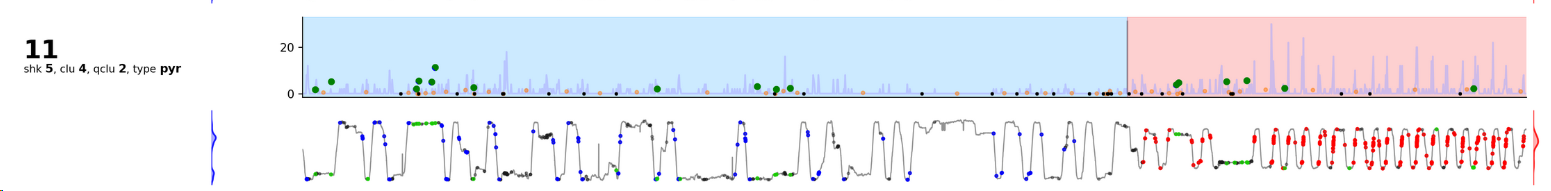

In [ ]:
target_neuron_id = 'kdiba|vvp01|two|2006-4-09_16-40-54|11'
all_neuron_stats_table[all_neuron_stats_table['neuron_uid'] == target_neuron_id]

across_session_inst_fr_computation_df[across_session_inst_fr_computation_df['neuron_uid'] == target_neuron_id]

![kdiba|vvp01|two|2006-4-09_16-40-54|11](image.png)

In [ ]:
target_neuron_id = 'kdiba|gor01|one|2006-6-12_15-55-31|32'
# target_aclu = 32

# all_neuron_stats_table[all_neuron_stats_table['aclu'] == target_aclu]
# across_session_inst_fr_computation_df[across_session_inst_fr_computation_df['aclu'] == target_aclu]

all_neuron_stats_table[all_neuron_stats_table['neuron_uid'] == target_neuron_id]
across_session_inst_fr_computation_df[across_session_inst_fr_computation_df['neuron_uid'] == target_neuron_id]

# 'stability_maze_any' : wrong, gives 0.0 (worst) not best

# '*_n_spikes' seem wrong


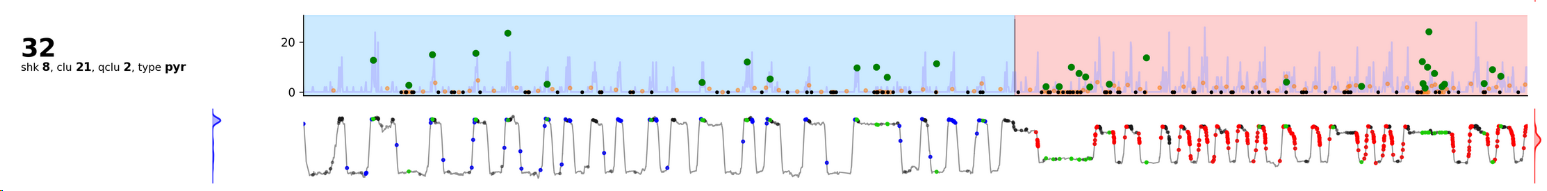

In [ ]:
plt.close('all')

In [ ]:


LxC_Only_all_neuron_stats_table: pd.DataFrame = all_neuron_stats_table.pho.partition_df_dict(partitionColumn='active_set_membership_from_stability')['LxC']
SxC_Only_all_neuron_stats_table: pd.DataFrame = all_neuron_stats_table.pho.partition_df_dict(partitionColumn='active_set_membership_from_stability')['SxC']

In [ ]:
SxC_Only_all_neuron_stats_table

In [ ]:
active_across_session_inst_fr_computation_df.pho.partition_df_dict(partitionColumn='active_set_membership_from_stability')['LxC']
active_across_session_inst_fr_computation_df.pho.partition_df_dict(partitionColumn='active_set_membership_from_stability')['SxC']


###### 2025-08-07 - Trace the differences between the old/new user annotations

In [ ]:
data_columns = ['lap_delta_minus', 'lap_delta_plus', 'replay_delta_minus', 'replay_delta_plus']
relevant_cols = ['neuron_uid', 'active_set_membership'] + data_columns
# OLD_across_session_inst_fr_computation_df = deepcopy(across_session_inst_fr_computation_df) 
# OLD_across_session_inst_fr_computation_df
# OLD_across_session_inst_fr_computation_df[['neuron_uid', 'active_set_membership'] + data_columns]

OLD_across_session_inst_fr_computation_df[OLD_across_session_inst_fr_computation_df['active_set_membership'] == 'LxC'][relevant_cols]
OLD_across_session_inst_fr_computation_df[OLD_across_session_inst_fr_computation_df['active_set_membership'] == 'SxC'][relevant_cols]

In [ ]:
## INPUTS: NEW_across_session_inst_fr_computation_df, OLD_across_session_inst_fr_computation_df
# NEW_across_session_inst_fr_computation_df

OLD_neuron_uids = set(np.unique(OLD_across_session_inst_fr_computation_df['neuron_uid']).tolist())
NEW_neuron_uids = set(np.unique(NEW_across_session_inst_fr_computation_df['neuron_uid']).tolist())

OLD_neuron_uids.symmetric_difference(NEW_neuron_uids)
XdC_categories = ['LxC', 'SxC']
NEW_XdCs = {an_XdC_type:NEW_across_session_inst_fr_computation_df[NEW_across_session_inst_fr_computation_df['active_set_membership'] == an_XdC_type][relevant_cols] for an_XdC_type in XdC_categories}
OLD_XdCs = {an_XdC_type:OLD_across_session_inst_fr_computation_df[OLD_across_session_inst_fr_computation_df['active_set_membership'] == an_XdC_type][relevant_cols] for an_XdC_type in XdC_categories}

NEW_XdCs
OLD_XdCs

neuron_replay_stats_table
NEW_across_session_inst_fr_computation_df = deepcopy(across_session_inst_fr_computation_df)
# NEW_across_session_inst_fr_computation_df
# NEW_across_session_inst_fr_computation_df[['neuron_uid', 'active_set_membership'] + data_columns]

NEW_across_session_inst_fr_computation_df[NEW_across_session_inst_fr_computation_df['active_set_membership'] == 'LxC'][['neuron_uid', 'active_set_membership'] + data_columns]
NEW_across_session_inst_fr_computation_df[NEW_across_session_inst_fr_computation_df['active_set_membership'] == 'SxC'][['neuron_uid', 'active_set_membership'] + data_columns]


### Resume Fig 2 Body

In [24]:
from pyphoplacecellanalysis.SpecificResults.AcrossSessionResults import AcrossSessionsVisualizations
from pyphoplacecellanalysis.SpecificResults.AcrossSessionResults import InstantaneousFiringRatesDataframeAccessor
from pyphoplacecellanalysis.SpecificResults.PhoDiba2023Paper import PaperFigureTwo

# ['lap_delta_minus', 'lap_delta_plus', 'replay_delta_minus', 'replay_delta_plus']

## NOTE: LxC/SxC groups are determined ONLY by the `across_session_inst_fr_computation_df['active_set_membership']` column, specifically cells that have values of 'LxC' and 'SxC'
# active_set_cell_groups_column_name: str = 'active_set_membership'
# active_set_cell_groups_column_name: str = 'active_set_membership_from_stability'
# active_set_cell_groups_column_name: str = 'active_set_membership_from_participation' # 2025-08-06
active_set_cell_groups_column_name: str = 'active_set_membership_from_user_annotations' # 2025-08-08
# active_set_cell_groups_column_name: str = 'active_set_membership_from_all' # 2025-08-06


# pbe_y_axis_label='PBE-averaged Firing Rates (Hz)'
# PBE_col_variable_names: List[str] = ['replay_delta_minus', 'replay_delta_plus'] 

pbe_y_axis_label='Fraction of Participating PBE Epochs'
PBE_col_variable_names: List[str] = ['ReplayDeltaMinus_ratio_participating_epochs', 'ReplayDeltaPlus_ratio_participating_epochs']


# fig2_export_folder = Path(r"E:/Dropbox (Personal)/Active/Kamran Diba Lab/Pho-Kamran-Meetings/2025-06-06 - EXPORTS FOR PUBLICATION/Figure 2 - XxC Bar").resolve()
# Assert.path_exists(fig2_export_folder)

active_across_session_inst_fr_computation_df = deepcopy(across_session_inst_fr_computation_df)
# active_across_session_inst_fr_computation_df = deepcopy(stable_across_session_inst_fr_computation_df)
assert active_set_cell_groups_column_name in across_session_inst_fr_computation_df

## Publication
fig2_kwargs = dict(save_figure=True, enable_tiny_point_labels=False, enable_hover_labels=False, write_vector_format=True, prepare_for_publication=True) ## Publication

## Debugging
# fig2_kwargs = dict(save_figure=False, enable_tiny_point_labels=False, enable_hover_labels=True, write_vector_format=False, prepare_for_publication=False) ## Debugging

num_sessions: int = active_across_session_inst_fr_computation_df['session_uid'].nunique(dropna=True)
across_session_inst_fr_computation_shell_obj, visualization_df = InstantaneousFiringRatesDataframeAccessor.build_shell_object_for_plot(loaded_result_df=active_across_session_inst_fr_computation_df,
                                                                                                                                        active_set_cell_groups_column_name=active_set_cell_groups_column_name, PBE_col_variable_names=PBE_col_variable_names)
# Perform the actual plotting:
fig2_ctxt, fig2, _fig_2_output_dict = AcrossSessionsVisualizations.across_sessions_bar_graphs(across_session_inst_fr_computation_shell_obj, num_sessions=num_sessions, pbe_y_axis_label=pbe_y_axis_label, **fig2_kwargs) # fig2_export_folder
fig2

num_sessions: 9
a_label: kdiba|gor01|one|2006-6-08_14-26-15|8, a_point_list: [(-0.042078979715762896, 1.1002622245541633), (0.875978483476059, 0.060917570334330505)]
a_label: kdiba|gor01|one|2006-6-08_14-26-15|97, a_point_list: [(-0.145952725981427, 1.8480500593928948), (1.0255434888977808, 0.04157392965226457)]
a_label: kdiba|gor01|one|2006-6-08_14-26-15|109, a_point_list: [(0.10686336617832295, 0.829683081529582), (1.1337864467124315, 0.05578930214743026)]
a_label: kdiba|gor01|one|2006-6-09_1-22-43|3, a_point_list: [(0.14069647952873263, 1.7444565713947298), (1.137780149185619, 0.17064807220588887)]
a_label: kdiba|gor01|one|2006-6-09_1-22-43|5, a_point_list: [(0.06538960862979085, 1.5079422312875785), (0.8672503525618375, 0.28585392023471085)]
a_label: kdiba|gor01|one|2006-6-09_1-22-43|29, a_point_list: [(0.08014879547194173, 2.0034565635946704), (0.8834114463337189, 0.28212717204261084)]
a_label: kdiba|gor01|one|2006-6-09_1-22-43|103, a_point_list: [(0.1367600721397075, 2.5798575905

In [ ]:
active_across_session_inst_fr_computation_df

In [ ]:
from pyphocorehelpers.plotting.media_output_helpers import PDFHelpers

# Explicit version showing directory handling
## INPUTS: fig2_export_folder, _fig_2_output_dict
_fig_2_theta_out = _fig_2_output_dict['theta']
_fig_2_replay_out = _fig_2_output_dict['replay']
_fig2_theta_pdf_path = Path(_fig_2_theta_out.saved_figures[0][0])
_fig2_replay_pdf_path = Path(_fig_2_replay_out.saved_figures[0][0])
_fig2_final_combined_output_path = fig2_export_folder / f"figure2_OUT.pdf"

PDFHelpers.concatenate_pdfs_horizontally((_fig2_theta_pdf_path, _fig2_replay_pdf_path), _fig2_final_combined_output_path)

# Scale input.pdf down to 50% size, scaling around the center
PDFHelpers.scale_pdf(input_path=_fig2_final_combined_output_path, output_path=_fig2_final_combined_output_path.with_stem(f"figure2_OUT_SCALED"), scale_factor=0.5)

In [ ]:
plt.close('all')

#### Inst Firing Rate Over Time


In [ ]:
target_folder_date_name: str = '2025-08-05'
# across_session_inst_fr_path = Path('/home/halechr/FastData/collected_outputs/2025-08-01_GL/across_session_result_long_short_recomputed_inst_firing_rate_2025-08-01_1000.0.pkl').resolve()
across_session_inst_fr_path = Path(f'/home/halechr/FastData/collected_outputs/{target_folder_date_name}_GL/across_session_result_long_short_recomputed_inst_firing_rate_{target_folder_date_name}_1000.0.pkl').resolve()

In [ ]:
Assert.path_exists(across_session_inst_fr_path)
across_session_inst_fr_computation_dict: Dict[IdentifyingContext, InstantaneousSpikeRateGroupsComputation] = {k:v[1] for k, v in InstantaneousSpikeRateGroupsComputation.from_file(across_session_inst_fr_path).items()}
# for a_session_ctxt, a_inst_fr_grou_comp in across_session_inst_fr_computation_dict.items():
# 	a_inst_fr_grou_comp.recompute_on_update() ## force recomputing
# across_session_inst_fr_computation_df: pd.DataFrame = pd.concat([v.get_summary_dataframe() for v in across_session_inst_fr_computation_dict.values()], axis='index', ignore_index=True)
# across_session_inst_fr_computation_df['aclu'] = across_session_inst_fr_computation_df['aclu'].astype(int)
# across_session_inst_fr_computation_df['inst_time_bin_seconds'] = inst_time_bin_seconds
# across_session_inst_fr_computation_df


a_session_InstantaneousSpikeRateGroupsComputation: InstantaneousSpikeRateGroupsComputation = deepcopy(across_session_inst_fr_computation_dict[IdentifyingContext(format_name= 'kdiba', animal= 'pin01', exper_name= 'one', session_name= '11-03_12-3-25')])


# across_session_inst_fr_computation_shell_obj.computation_result.Fig2_Laps_FR


In [ ]:
# a_session_InstantaneousSpikeRateGroupsComputation.compute_spike_rate_bars()
# a_session_InstantaneousSpikeRateGroupsComputation.get_comprehensive_dataframe()
# a_session_InstantaneousSpikeRateGroupsComputation.Fig2_Laps_FR
# a_session_InstantaneousSpikeRateGroupsComputation.LxC_ThetaDeltaMinus.epoch_agg_inst_fr_list
a_session_InstantaneousSpikeRateGroupsComputation


# pd.concat(a_session_InstantaneousSpikeRateGroupsComputation.AnyC_ThetaDeltaMinus.epoch_unit_fr_df_list)



## Figure 3 - FRI Scatter

In [25]:
# long_short_fr_indicies_analysis_table['has_pf_color']
# long_short_fr_indicies_analysis_table



pbe_y_axis_label='PBE-averaged Firing Rates (Hz)'
PBE_col_variable_names: List[str] = ['replay_delta_minus', 'replay_delta_plus'] 

# pbe_y_axis_label='Fraction of Participating PBE Epochs'
# PBE_col_variable_names: List[str] = ['ReplayDeltaMinus_ratio_participating_epochs', 'ReplayDeltaPlus_ratio_participating_epochs']

if PBE_col_variable_names is None:
    PBE_col_variable_names = ['replay_delta_minus', 'replay_delta_plus'] 
    
assert len(PBE_col_variable_names) == 2, f'len(PBE_col_variable_names) must be 2, but is {len(PBE_col_variable_names)}'
PBE_delta_minus_col_name: str = PBE_col_variable_names[0]
PBE_delta_plus_col_name: str = PBE_col_variable_names[1]

## Use the overrides to update the 'y_frs_index' for the column names
across_session_inst_fr_computation_df['x_frs_index'] = (across_session_inst_fr_computation_df['lap_delta_minus'] - across_session_inst_fr_computation_df['lap_delta_plus']) / (across_session_inst_fr_computation_df['lap_delta_minus'] + across_session_inst_fr_computation_df['lap_delta_plus'])
across_session_inst_fr_computation_df['y_frs_index'] = (across_session_inst_fr_computation_df[PBE_delta_minus_col_name] - across_session_inst_fr_computation_df[PBE_delta_plus_col_name]) / (across_session_inst_fr_computation_df[PBE_delta_minus_col_name] + across_session_inst_fr_computation_df[PBE_delta_plus_col_name])
# across_session_inst_fr_computation_df

In [26]:
## Use the `across_session_inst_fr_computation_df` df instead -- no need to merge anything in
long_short_fr_indicies_analysis_table = deepcopy(across_session_inst_fr_computation_df) # #TODO 2025-07-29 04:58: - [ ] 

## WARNING: fill with some zeros here to prevent issue with linear regression fitting, only ~4 cells affected maybe?
# long_short_fr_indicies_analysis_table = long_short_fr_indicies_analysis_table.fillna(value={'x_frs_index': 0.0, 'y_frs_index': 0.0}, inplace=False)
long_short_fr_indicies_analysis_table = long_short_fr_indicies_analysis_table.dropna(axis='index', how='any', subset=['x_frs_index', 'y_frs_index'], inplace=False)

# long_short_fr_indicies_analysis_table

In [ ]:
# ## Merge in the newly updated frs columns from `across_session_inst_fr_computation_df`
# long_short_fr_indicies_analysis_table = deepcopy(all_neuron_stats_table)  ## DEFAULT INPUT

# long_short_fr_indicies_analysis_table = long_short_fr_indicies_analysis_table.drop(columns=['x_frs_index', 'y_frs_index'])
# pre_merge_length = len(long_short_fr_indicies_analysis_table) 
# ## Ensure the two tables are aligned based on their 'neuron_uid' column:
# long_short_fr_indicies_analysis_table = long_short_fr_indicies_analysis_table.merge(across_session_inst_fr_computation_df[['neuron_uid', 'x_frs_index', 'y_frs_index']], on='neuron_uid', how='left')

# post_merge_length = len(long_short_fr_indicies_analysis_table)
# assert pre_merge_length == post_merge_length, f"AcrossSessionHelpers: The merge operation did not result in the expected number of rows. Expected {pre_merge_length}, got {post_merge_length}."
# # long_short_fr_indicies_analysis_table['x_frs_index'] = (long_short_fr_indicies_analysis_table['lap_delta_minus'] - long_short_fr_indicies_analysis_table['lap_delta_plus']) / (long_short_fr_indicies_analysis_table['lap_delta_minus'] + long_short_fr_indicies_analysis_table['lap_delta_plus'])
# # long_short_fr_indicies_analysis_table['y_frs_index'] = (long_short_fr_indicies_analysis_table[PBE_delta_minus_col_name] - long_short_fr_indicies_analysis_table[PBE_delta_plus_col_name]) / (long_short_fr_indicies_analysis_table[PBE_delta_minus_col_name] + long_short_fr_indicies_analysis_table[PBE_delta_plus_col_name])

# long_short_fr_indicies_analysis_table

In [27]:
from pyphoplacecellanalysis.SpecificResults.AcrossSessionResults import AcrossSessionsVisualizations
from pyphoplacecellanalysis.SpecificResults.PhoDiba2023Paper import pho_stats_linear_regression, LinearRegressionOutput


# _fig3_temp_out_path = fig3_export_folder_temp.joinpath('_TEMP_right.pdf')
# PDFHelpers.concatenate_pdfs_horizontally(graphics_output_dict['across_sessions_long_and_short_firing_rate_replays_v_laps']['saved_figures'], _fig3_temp_out_path)
# _fig3_temp_out_path
# long_short_fr_indicies_analysis_table = deepcopy(all_neuron_stats_table) ## DEFAULT INPUT


# long_short_fr_indicies_analysis_table = deepcopy(across_session_inst_fr_computation_df) # #TODO 2025-07-29 04:58: - [ ] 

# long_short_fr_indicies_analysis_table = deepcopy(all_neuron_stats_table)
# long_short_fr_indicies_analysis_table = deepcopy(stable_neuron_stats_table) ## PREV

# long_short_fr_indicies_analysis_table = deepcopy(stable_across_session_inst_fr_computation_df) # 2025-07-31 17:13 

# Filter rows based on column: 'qclu'
# long_short_fr_indicies_analysis_table = long_short_fr_indicies_analysis_table[long_short_fr_indicies_analysis_table['qclu'] < 3] # qclu: [1, 2]
# long_short_fr_indicies_analysis_table = long_short_fr_indicies_analysis_table[long_short_fr_indicies_analysis_table['qclu'] < 3] # qclu: [1, 2]

# Filter rows based on column: 'exper_name'
# long_short_fr_indicies_analysis_table = long_short_fr_indicies_analysis_table[long_short_fr_indicies_analysis_table['exper_name'] == "one"]

num_sessions: int = long_short_fr_indicies_analysis_table['session_uid'].nunique(dropna=True)
print(f'num_sessions: {num_sessions}')

# left_fig_size = (3.3707, 2.875) # (8.5, 7.25)
# right_fig_size = (1.68535, 1.4375) # (3.3707/2.0, 2.875/2.0)

left_fig_size = (4.2, 4.0)  #(4.2, 2.875) # (8.5, 7.25)
right_fig_size = (1.68535, 1.4375) # (3.3707/2.0, 2.875/2.0)

## PUBLICATION MODE:
fig3_common_kwargs = dict(save_figure=True, write_vector_format=True, write_png=False, prepare_for_publication=True, bbox_inches='tight', pad_inches=0, include_linear_regression_line=True, s=5) # , enable_hover_labels=False


## INTERACTIVE DEBUGGING:
# fig3_common_kwargs = dict(save_figure=False, write_vector_format=False, write_png=False, prepare_for_publication=False, enable_hover_labels=True, bbox_inches='tight', pad_inches=0, include_linear_regression_line=True, s=10, enable_tiny_point_labels=False) # , include_axes_lines=True


# with mpl.rc_context({'savefig.transparent': True, 'ps.fonttype': 42, 'pdf.fonttype': 42, }): # 'figure.dpi': '420', 

graphics_output_dict = {}
graphics_output_dict['across_sessions_firing_rate_index_figure'] = AcrossSessionsVisualizations.across_sessions_firing_rate_index_figure(long_short_fr_indicies_analysis_results=long_short_fr_indicies_analysis_table, num_sessions=num_sessions, **fig3_common_kwargs, figsize=left_fig_size, include_axes_lines=False)
graphics_output_dict['across_sessions_firing_rate_index_figure']

num_sessions: 9
num_above_diagonal/total_num_points: 211/530
percent_below_diagonal: 60.18867924528302%
percent_above_diagonal: 39.81132075471698%
register_output_file(output_path: C:\Users\pho\repos\Spike3DWorkEnv\Spike3D\EXTERNAL\PhoDibaPaper2024Book\EXTERNAL\Screenshots\ProgrammaticDisplayFunctionTesting\2025-08-11\kdiba\9_across_sessions_firing_rate_index.pdf, ...)
	 saved "file:///C:/Users/pho/repos/Spike3DWorkEnv/Spike3D/EXTERNAL/PhoDibaPaper2024Book/EXTERNAL/Screenshots/ProgrammaticDisplayFunctionTesting/2025-08-11/kdiba/9_across_sessions_firing_rate_index.pdf"


MatplotlibRenderPlots({'name': 'across_sessions_firing_rate_index_figure', 'context': DisplaySpecifyingIdentifyingContext<('kdiba', 9, 'across_sessions_firing_rate_index')>, 'figures': (<Figure size 420x400 with 4 Axes>,), 'axes': (<Axes: label='ax_histx'>, <Axes: label='ax_histdiagonal'>, <Axes: label='ax_scatter', xlabel='$\\left({\\text{Laps}_{t < \\Delta}-\\text{Laps}_{t > \\Delta}}\\right)/\\left({\\text{Laps}_{t > \\Delta} + \\text{Laps}_{t < \\Delta}}\\right)$', ylabel='$\\left({\\text{PBE}_{t < \\Delta}-\\text{PBE}_{t > \\Delta}}\\right)/\\left({\\text{PBE}_{t > \\Delta} + \\text{PBE}_{t < \\Delta}}\\right)$'>, <Axes: label='ax_histy'>), 'plot_data': {'scatter_plot': <matplotlib.collections.PathCollection object at 0x000001687149AD90>}, 'saved_figures': ([WindowsPath('C:/Users/pho/repos/Spike3DWorkEnv/Spike3D/EXTERNAL/PhoDibaPaper2024Book/EXTERNAL/Screenshots/ProgrammaticDisplayFunctionTesting/2025-08-11/kdiba/9_across_sessions_firing_rate_index.pdf')],)})

In [28]:
import scipy.stats as stats
from pyphoplacecellanalysis.SpecificResults.PhoDiba2023Paper import pho_stats_perform_diagonal_line_binomial_test, pho_stats_bar_graph_t_tests

## INPUTS: long_short_fr_indicies_analysis_table
binom_test_chance_result = pho_stats_perform_diagonal_line_binomial_test(long_short_fr_indicies_analysis_table)
print(f'binom_test_chance_result: {binom_test_chance_result}')

n_total: 530, n_above_diagonal: 319, n_exact_on_diagonal: 0, n_below_diagonal: 211
binom_test_chance_result: BinomTestResult(k=319, n=530, alternative='two-sided', statistic=0.6018867924528302, pvalue=3.115344590619397e-06)


In [ ]:
long_short_fr_indicies_analysis_table

In [29]:

graphics_output_dict['across_sessions_long_and_short_firing_rate_replays_v_laps'] = AcrossSessionsVisualizations.across_sessions_long_and_short_firing_rate_replays_v_laps_figure(neuron_replay_stats_table=long_short_fr_indicies_analysis_table, num_sessions=num_sessions, **fig3_common_kwargs, figsize=right_fig_size,
																																												#   long_col_names=['long_non_replay_mean', 'long_replay_mean'], short_col_names=['short_non_replay_mean', 'short_replay_mean'],
																																												long_col_names=['lap_delta_minus', 'replay_delta_minus'], short_col_names=['lap_delta_plus', 'replay_delta_plus'],
																		 ) # , write_vector_format=True, write_png=False

# ## Aggregate across all of the sessions to build a new combined `InstantaneousSpikeRateGroupsComputation`, which can be used to plot the "PaperFigureTwo", bar plots for many sessions.
# global_multi_session_context = IdentifyingContext(format_name='kdiba', num_sessions=num_sessions) # some global context across all of the sessions, not sure what to put here.
# 2023-10-10 - Statistics for `across_sessions_bar_graphs`, analysing `across_session_inst_fr_computation`
binom_test_chance_result = pho_stats_perform_diagonal_line_binomial_test(long_short_fr_indicies_analysis_table)
print(f'binom_test_chance_result: {binom_test_chance_result}')

# # Fit linear regression using numpy.polyfit
# reg_x = long_short_fr_indicies_analysis_table['x_frs_index'].to_numpy()
# reg_y = long_short_fr_indicies_analysis_table['y_frs_index'].to_numpy()
# _lin_reg = pho_stats_linear_regression(reg_x, reg_y)
# _out_regression_line_artist = _lin_reg.plot(ax=graphics_output_dict['across_sessions_firing_rate_index_figure'].axes[2])
['long_replay_mean', 'long_non_replay_mean']


fig_kwargs: {'figsize': (1.68535, 1.4375), 'num': 'track_replay|track_laps frs_kdiba/9/plot_single_track_firing_rate_compare/long', 'clear': True}
fig_kwargs: {'figsize': (1.68535, 1.4375), 'num': 'track_replay|track_laps frs_kdiba/9/plot_single_track_firing_rate_compare/short', 'clear': True}
register_output_file(output_path: C:\Users\pho\repos\Spike3DWorkEnv\Spike3D\EXTERNAL\PhoDibaPaper2024Book\EXTERNAL\Screenshots\ProgrammaticDisplayFunctionTesting\2025-08-11\kdiba\9_plot_single_track_firing_rate_compare_long.pdf, ...)
	 saved "file:///C:/Users/pho/repos/Spike3DWorkEnv/Spike3D/EXTERNAL/PhoDibaPaper2024Book/EXTERNAL/Screenshots/ProgrammaticDisplayFunctionTesting/2025-08-11/kdiba/9_plot_single_track_firing_rate_compare_long.pdf"
register_output_file(output_path: C:\Users\pho\repos\Spike3DWorkEnv\Spike3D\EXTERNAL\PhoDibaPaper2024Book\EXTERNAL\Screenshots\ProgrammaticDisplayFunctionTesting\2025-08-11\kdiba\9_plot_single_track_firing_rate_compare_short.pdf, ...)
	 saved "file:///C:/User

['long_replay_mean', 'long_non_replay_mean']

In [ ]:
binom_test_chance_result

In [30]:
_fig3_temp_out_path = fig3_export_folder_temp.joinpath('_TEMP_right.pdf')
PDFHelpers.concatenate_pdfs_vertically(graphics_output_dict['across_sessions_long_and_short_firing_rate_replays_v_laps']['saved_figures'], _fig3_temp_out_path)
figure3_final_out_path: Path = fig3_export_folder.joinpath('figure3_MERGED_ALL.pdf')

PDFHelpers.concatenate_pdfs_horizontally((graphics_output_dict['across_sessions_firing_rate_index_figure']['saved_figures'][0][0], _fig3_temp_out_path), figure3_final_out_path)

Successfully concatenated 2 PDFs vertically to: E:\Dropbox (Personal)\Active\Kamran Diba Lab\Pho-Kamran-Meetings\2025-07-03 - EXPORTS FOR PUBLICATION\Figure 3 - FRI Scatter\_TEMP\_TEMP_right.pdf


WindowsPath('E:/Dropbox (Personal)/Active/Kamran Diba Lab/Pho-Kamran-Meetings/2025-07-03 - EXPORTS FOR PUBLICATION/Figure 3 - FRI Scatter/_TEMP/_TEMP_right.pdf')

Successfully concatenated 2 PDFs to: E:\Dropbox (Personal)\Active\Kamran Diba Lab\Pho-Kamran-Meetings\2025-07-03 - EXPORTS FOR PUBLICATION\Figure 3 - FRI Scatter\figure3_MERGED_ALL.pdf


WindowsPath('E:/Dropbox (Personal)/Active/Kamran Diba Lab/Pho-Kamran-Meetings/2025-07-03 - EXPORTS FOR PUBLICATION/Figure 3 - FRI Scatter/figure3_MERGED_ALL.pdf')

## Figure 4 - Scatter P_Short over Time

In [ ]:
original_size = np.array([1800, 480])
original_size/4
original_size


exported_size_inches = 24.691
desired_export_size_inches = 6.5

needed_scale_factor: float = desired_export_size_inches / exported_size_inches # 0.2632538171803491
needed_scale_factor

original_size * needed_scale_factor # array([473.85687092, 126.36183225])

In [ ]:
needed_title_px = (9/12) * 23
needed_title_px

neeeded_axes_px = (7/6.9) * 9.2
neeeded_axes_px

needed_inner_epoch_labels_px = (5/6.75) * 9
needed_inner_epoch_labels_px

In [ ]:
(792/1800)*480

In [ ]:
(earliest_delta_aligned_t_start, latest_delta_aligned_t_end)


In [34]:
from pyphoplacecellanalysis.SpecificResults.PhoDiba2023Paper import _perform_plot_pre_post_delta_scatter
from pyphoplacecellanalysis.Pho2D.plotly.Extensions.plotly_helpers import plotly_pre_post_delta_scatter
from pyphoplacecellanalysis.SpecificResults.PhoDiba2023Paper import DataFrameFilter

## INPUTS: all_sessions_ripple_df, all_sessions_ripple_time_bin_df, all_sessions_laps_df, all_sessions_laps_time_bin_df, all_sessions_nonPBE_endcap_df, all_sessions_nonPBE_endcap_time_bin_df, 

is_publication_ready_figure: bool = True
# is_publication_ready_figure=False

# # Laps _______________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________ #
export_suffix: str = 'Laps'
active_plot_df_name: str ='filtered_all_sessions_laps_time_bin_df'

# # PBEs _______________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________ #
# export_suffix: str = 'PBEs'
# active_plot_df_name: str ='filtered_all_sessions_ripple_time_bin_df' # all_sessions_ripple_time_bin_df

# ==================================================================================================================================================================================================================================================================================== #
# Begin Function Body                                                                                                                                                                                                                                                                  #
# ==================================================================================================================================================================================================================================================================================== #
# main_title = 'Decoded likelihood that time bins during running occur on the the Short Track'
main_title = f'Short-track Decoded Likelihood during {export_suffix}'

additional_filter_predicates = {}

## ensure that the qclu is always before the frateThresh, reversing them if needed:
# replay_name: str = 'withNormalComputedReplays-qclu_[1, 2, 4, 6, 7, 8, 9]-frateThresh_5.0'
replay_name: str = 'withNormalComputedReplays-qclu_[1, 2, 4, 6, 7, 8, 9]-frateThresh_2.0'
time_bin_size: float = 0.050
# time_bin_size: float = 0.060
# time_bin_size: float = 0.025
# time_bin_size: Tuple[float] = (0.025, 0.058)
# time_bin_size: Tuple[float] = (0.025, 0.050)


# split_by_column: str = 'animal'
split_by_kwargs: str = {
    # 'color': 'session_name',
    # 'color': 'animal',
    # 'size': 'session_experience_rank', 'size_max': 10,
    # 'size': 'duration', 'size_max': 10,
}

additional_fig_layout_kwargs = None
_build_filter_changed_plotly_plotting_callback_fn = DataFrameFilter._build_plot_callback(earliest_delta_aligned_t_start=earliest_delta_aligned_t_start, latest_delta_aligned_t_end=latest_delta_aligned_t_end, save_plotly=save_plotly,
                                                                                          resolution_multiplier=resolution_multiplier,
                                            px_scatter_kwargs = {
												# 'render_mode': 'webgl',  # Add WebGL rendering
												'render_mode': 'svg',
												'size_max': 1,
                                                **split_by_kwargs,
											},
											 hist_kwargs = {
												 'nbins': 11, ## number of bins
												**split_by_kwargs,
                                            },
											common_plot_kwargs = {
                                                'color_discrete_sequence': ['black'],					
                                            },
                                            additional_fig_layout_kwargs=additional_fig_layout_kwargs,
											is_publication_ready_figure=True, main_title=main_title,
)
 
df_filter: DataFrameFilter = DataFrameFilter(
	original_df_dict=dict(
        all_sessions_ripple_df=all_sessions_ripple_df,
        all_sessions_ripple_time_bin_df=all_sessions_ripple_time_bin_df,
        all_sessions_laps_df=all_sessions_laps_df,
        all_sessions_laps_time_bin_df=all_sessions_laps_time_bin_df,
		# all_sessions_nonPBE_endcap_df=all_sessions_nonPBE_endcap_df,
		all_sessions_nonPBE_endcap_time_bin_df=all_sessions_nonPBE_endcap_time_bin_df, 
    ),
	# original_df_dict=dict(
    #     FAT_df=FAT_df, # FAT only mode
    # ),
    additional_filter_predicates=additional_filter_predicates,
    on_filtered_dataframes_changed_callback_fns={'build_filter_changed_plotly_plotting_callback_fn': _build_filter_changed_plotly_plotting_callback_fn},
    active_plot_df_name=active_plot_df_name,
	# active_plot_df_name='filtered_FAT_df',
)

# , initial_selection_mode=InitialSelectionModeEnum

# Add additional columns _____________________________________________________________________________________________ #
# _a_time_bin_size_widget = df_filter.build_extra_selectMultiple_widget(a_name='time_bin_size', df_col_name='time_bin_size', a_widget_label='Time Bin Size:')

_a_dropdown = df_filter.build_extra_dropdown_widget(a_name='trained_compute_epochs', df_col_name='trained_compute_epochs', a_widget_label='TrainedComputeEpochs :', custom_initial_selection='laps')
_a_dropdown = df_filter.build_extra_dropdown_widget(a_name='decoder_identifier', df_col_name='decoder_identifier', a_widget_label='decoder_identifier:', custom_initial_selection='pseudo2D')
_a_selectMultiple = df_filter.build_extra_selectMultiple_widget(a_name='masked_time_bin_fill_type', df_col_name='masked_time_bin_fill_type', a_widget_label='masked_time_bin_fill_type:', initial_selection_mode=InitialSelectionModeEnum.FIRST_SELECTED)
# _a_selectMultiple_experience_index = df_filter.build_extra_selectMultiple_widget(a_name='session_experience_rank', df_col_name='session_experience_rank', a_widget_label='session_experience_rank:', initial_selection_mode=InitialSelectionModeEnum.ALL_SELECTED)

# Set initial values: ________________________________________________________________________________________________ #
df_filter.replay_name = replay_name # 'withNormalComputedReplays-frateThresh_5.0-qclu_[1, 2, 4, 6, 7, 9]'
df_filter.time_bin_size = time_bin_size

# df_filter.figure_widget.update_traces(marker=dict(size=30))
df_filter.update_filters()
df_filter.display()

Please select at least one Time Bin Size.
is_publication_ready_figure: omitting "color" from px_scatter_kwargs
is_publication_ready_figure: omitting "color" from px_scatter_kwargs


WARN: figure_sup_huge_title_text is provided and not None, figure_sup_huge_title_text: "None". Overriding.
WARN: figure_footer_text is provided and not None, figure_footer_text: "None". Overriding.
already have common_plot_kwargs["color_discrete_sequence"]: ['black'], will not override!


#### Remove excess info for publication figure

In [ ]:
[earliest_delta_aligned_t_start, latest_delta_aligned_t_end]

In [ ]:
[-1300, 1400]

df_filter.filtered_size_info_df


In [ ]:
# df_filter.figure_widget.update_xaxes(col=2, range=[earliest_delta_aligned_t_start, latest_delta_aligned_t_end]) ## surprisingly this does fix it!
df_filter.figure_widget = df_filter.figure_widget.update_xaxes(col=2, range=[-1220, 1420])

# # df_filter.figure_widget = df_filter.figure_widget.update_yaxes(row=1, col=1, range=[-0.05, 5])
# df_filter.figure_widget = df_filter.figure_widget.update_yaxes(row=1, col=2, range=[-0.05, 5], autorange=False, fixedrange=True)
# df_filter.figure_widget
# df_filter.figure_widget = df_filter.figure_widget.update_yaxes(row=1, range=[-0.05, 1.05], autorange=False, fixedrange=True)
# # df_filter.figure_widget = df_filter.figure_widget.update_yaxes(col=3, range=[-0.05, 1.05])
# # # df_filter.figure_widget = df_filter.figure_widget.update_yaxes(col=2, range=[0.0, 1.0])
# # df_filter.figure_widget = df_filter.figure_widget.update_yaxes(col=2, range=[0.0, 5.0])
# # # fig.update_layout(yaxis=dict(range=forced_range_y), barmode='overlay')
# df_filter.figure_widget
# # df_filter.figure_widget.update_xaxes(col=2, range=[-2000, 1500])


In [ ]:
## INPUTS: fig4_export_folder, export_suffix

# _out_paths = df_filter.export_for_publication(figures_parent_folder=figure_4_parent_folder, export_suffix='Laps', export_html=False)
# _out_paths = df_filter.export_for_publication(figures_parent_folder=figure_4_parent_folder, export_suffix='PBEs', export_html=False)
_out_paths = df_filter.export_for_publication(figures_parent_folder=fig4_export_folder, export_suffix=export_suffix, export_html=False)
_out_paths


In [ ]:
# _fig_4_replay_path = Path("E:/Dropbox (Personal)/Active/Kamran Diba Lab/Pho-Kamran-Meetings/2025-06-06 - EXPORTS FOR PUBLICATION/Figure 4 - P_Short Scatter over Time/ScatterOverTime_PBEs.pdf")
# _fig_4_laps_path = Path("E:/Dropbox (Personal)/Active/Kamran Diba Lab/Pho-Kamran-Meetings/2025-06-06 - EXPORTS FOR PUBLICATION/Figure 4 - P_Short Scatter over Time/ScatterOverTime_Laps.pdf")

fig4_final_export_path = fig4_export_folder.joinpath(f'fig4_final.pdf')

_fig_4_laps_path = fig4_export_folder.joinpath("ScatterOverTime_Laps.pdf")
_fig_4_replay_path = fig4_export_folder.joinpath("ScatterOverTime_PBEs.pdf")

Assert.path_exists(_fig_4_laps_path)
Assert.path_exists(_fig_4_replay_path)

PDFHelpers.concatenate_pdfs_vertically((_fig_4_laps_path, _fig_4_replay_path), fig4_final_export_path)


## Unsorted 2025-06-12

In [ ]:
from pyphoplacecellanalysis.SpecificResults.PhoDiba2023Paper import _perform_plot_pre_post_delta_scatter
from pyphoplacecellanalysis.Pho2D.plotly.Extensions.plotly_helpers import plotly_pre_post_delta_scatter
from pyphoplacecellanalysis.SpecificResults.PhoDiba2023Paper import DataFrameFilter

## INPUTS: all_sessions_ripple_df, all_sessions_ripple_time_bin_df, all_sessions_laps_df, all_sessions_laps_time_bin_df, all_sessions_nonPBE_endcap_df, all_sessions_nonPBE_endcap_time_bin_df, 

# is_publication_ready_figure: bool = True
is_publication_ready_figure = False

# # Laps _______________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________ #
export_suffix: str = 'Laps'
active_plot_df_name: str ='filtered_all_sessions_laps_time_bin_df'

# # PBEs _______________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________ #
# export_suffix: str = 'PBEs'
# active_plot_df_name: str ='filtered_all_sessions_ripple_time_bin_df' # all_sessions_ripple_time_bin_df

# ==================================================================================================================================================================================================================================================================================== #
# Begin Function Body                                                                                                                                                                                                                                                                  #
# ==================================================================================================================================================================================================================================================================================== #
# main_title = 'Decoded likelihood that time bins during running occur on the the Short Track'
main_title = f'Short-track Decoded Likelihood during {export_suffix}'

additional_filter_predicates = {}

## ensure that the qclu is always before the frateThresh, reversing them if needed:
replay_name: str = 'withNormalComputedReplays-qclu_[1, 2, 4, 6, 7, 8, 9]-frateThresh_5.0'
# replay_name: str = 'withNormalComputedReplays-qclu_[1, 2, 4, 6, 7, 8, 9]-frateThresh_2.0'
# time_bin_size: float = 0.06
# time_bin_size: float = 0.05
time_bin_size: float = 0.025
# time_bin_size: Tuple[float] = (0.025, 0.058)
# time_bin_size: Tuple[float] = (0.025, 0.050)


# split_by_column: str = 'animal'
split_by_kwargs: str = {
    # 'color': 'session_name',
    'color': 'animal',
	# 'color': 'session_experience_rank',
    # 'size': 'session_experience_rank', 'size_max': 10,
    # 'size': 'duration', 'size_max': 10,
}

additional_fig_layout_kwargs = None
_build_filter_changed_plotly_plotting_callback_fn = DataFrameFilter._build_plot_callback(earliest_delta_aligned_t_start=earliest_delta_aligned_t_start, latest_delta_aligned_t_end=latest_delta_aligned_t_end, save_plotly=save_plotly,
                                                                                          resolution_multiplier=resolution_multiplier,
                                            px_scatter_kwargs = {
												# 'render_mode': 'webgl',  # Add WebGL rendering
												'render_mode': 'svg',
												'size_max': 1,
                                                **split_by_kwargs,
											},
											 hist_kwargs = {
												 'nbins': 11, ## number of bins
												**split_by_kwargs,
                                            },
											common_plot_kwargs = {
                                                'color_discrete_sequence': ['black'],					
                                            },
                                            additional_fig_layout_kwargs=additional_fig_layout_kwargs,
											is_publication_ready_figure=is_publication_ready_figure, main_title=main_title,
)
 
df_filter: DataFrameFilter = DataFrameFilter(
	original_df_dict=dict(
        all_sessions_ripple_df=all_sessions_ripple_df,
        all_sessions_ripple_time_bin_df=all_sessions_ripple_time_bin_df,
        all_sessions_laps_df=all_sessions_laps_df,
        all_sessions_laps_time_bin_df=all_sessions_laps_time_bin_df,
		# all_sessions_nonPBE_endcap_df=all_sessions_nonPBE_endcap_df,
		all_sessions_nonPBE_endcap_time_bin_df=all_sessions_nonPBE_endcap_time_bin_df, 
    ),
	# original_df_dict=dict(
    #     FAT_df=FAT_df, # FAT only mode
    # ),
    additional_filter_predicates=additional_filter_predicates,
    on_filtered_dataframes_changed_callback_fns={'build_filter_changed_plotly_plotting_callback_fn': _build_filter_changed_plotly_plotting_callback_fn},
    active_plot_df_name=active_plot_df_name,
	# active_plot_df_name='filtered_FAT_df',
)

# , initial_selection_mode=InitialSelectionModeEnum

# Add additional columns _____________________________________________________________________________________________ #
# _a_time_bin_size_widget = df_filter.build_extra_selectMultiple_widget(a_name='time_bin_size', df_col_name='time_bin_size', a_widget_label='Time Bin Size:')

_a_dropdown = df_filter.build_extra_dropdown_widget(a_name='trained_compute_epochs', df_col_name='trained_compute_epochs', a_widget_label='TrainedComputeEpochs :', custom_initial_selection='laps')
_a_dropdown = df_filter.build_extra_dropdown_widget(a_name='decoder_identifier', df_col_name='decoder_identifier', a_widget_label='decoder_identifier:', custom_initial_selection='pseudo2D')
_a_selectMultiple = df_filter.build_extra_selectMultiple_widget(a_name='masked_time_bin_fill_type', df_col_name='masked_time_bin_fill_type', a_widget_label='masked_time_bin_fill_type:', initial_selection_mode=InitialSelectionModeEnum.FIRST_SELECTED)
# _a_selectMultiple_experience_index = df_filter.build_extra_selectMultiple_widget(a_name='session_experience_rank', df_col_name='session_experience_rank', a_widget_label='session_experience_rank:', initial_selection_mode=InitialSelectionModeEnum.ALL_SELECTED)

# Set initial values: ________________________________________________________________________________________________ #
df_filter.replay_name = replay_name # 'withNormalComputedReplays-frateThresh_5.0-qclu_[1, 2, 4, 6, 7, 9]'
df_filter.time_bin_size = time_bin_size

# df_filter.figure_widget.update_traces(marker=dict(size=30))
df_filter.update_filters()
df_filter.display()

In [ ]:
from neuropy.utils.indexing_helpers import flatten, NumpyHelpers, PandasHelpers
from pyphoplacecellanalysis.SpecificResults.PhoDiba2023Paper import DataFrameFilter, InitialSelectionModeEnum

## INPUTS: all_sessions_ripple_df, all_sessions_ripple_time_bin_df, all_sessions_laps_df, all_sessions_laps_time_bin_df, all_sessions_nonPBE_endcap_df, all_sessions_nonPBE_endcap_time_bin_df, 

additional_filter_predicates = {}

## ensure that the qclu is always before the frateThresh, reversing them if needed:
replay_name: str = 'withNormalComputedReplays-qclu_[1, 2, 4, 6, 7, 8, 9]-frateThresh_2.0'
# time_bin_size: float = 0.025
time_bin_size: float = 0.060
# time_bin_size: Tuple[float] = (0.025, 0.058)
# time_bin_size: Tuple[float] = (0.025, 0.050)


# split_by_column: str = 'animal'
split_by_kwargs: str = {
    # 'color': 'session_name',
    # 'color': 'animal',
	'color': 'session_experience_rank',
    # 'size': 'session_experience_rank', #'size_max': 10,
    # 'size': 'duration', 'size_max': 10,
}

_build_filter_changed_plotly_plotting_callback_fn = DataFrameFilter._build_plot_callback(earliest_delta_aligned_t_start=earliest_delta_aligned_t_start, latest_delta_aligned_t_end=latest_delta_aligned_t_end, save_plotly=save_plotly,
                                                                                          resolution_multiplier=resolution_multiplier,
																						#   px_scatter_kwargs = {'symbol': 'session_name'},
																						# px_scatter_kwargs = {'color': 'session_name', 'facet_row': 'time_bin_size'}, hist_kwargs = {'color': 'session_name', 'facet_row': 'time_bin_size'},
																						# px_scatter_kwargs = {'color': 'session_name'}, hist_kwargs = {'color': 'session_name'}, ## Split by session_name
                                            px_scatter_kwargs = {
                                                # 'color': 'session_name',
												# 'color': 'black',
												# 'color_discrete_sequence': ['black']
    										    # 'size': 'session_experience_rank', 'size_max': 10,
												# 'size': 'session_novelty_rank', 'size_max': 10,
												# 'size': 'duration', 'size_max': 10,
												# 'render_mode': 'webgl',  # Add WebGL rendering
                                                # 'render_mode': 'svg',  # Add Vectorized but slower rendering

                                                **split_by_kwargs,
											},
											 hist_kwargs = {
												**split_by_kwargs,
                                            }, ## Split by session_name
																						  
)
 
df_filter: DataFrameFilter = DataFrameFilter(
	is_figure_widget_mode = True, ## Disable the actual figure
	# is_figure_widget_mode = False, ## Disable the actual figure
	original_df_dict=dict(
        FAT_df=FAT_df, # FAT only mode
    ),	
    additional_filter_predicates=additional_filter_predicates,
    on_filtered_dataframes_changed_callback_fns={'build_filter_changed_plotly_plotting_callback_fn': _build_filter_changed_plotly_plotting_callback_fn},
    # active_plot_df_name='filtered_all_sessions_laps_time_bin_df',
	active_plot_df_name='filtered_FAT_df',
)


# Add additional columns _____________________________________________________________________________________________ #
_active_ctrl_fn = lambda *arg, **kwargs: df_filter.build_extra_dropdown_widget(*arg, **kwargs, initial_selection_mode=InitialSelectionModeEnum.FIRST_SELECTED)
# _active_ctrl_fn = lambda *arg, **kwargs: df_filter.build_extra_selectMultiple_widget(*arg, **kwargs, initial_selection_mode=InitialSelectionModeEnum.FIRST_SELECTED)

_a_dropdown = _active_ctrl_fn(a_name='trained_compute_epochs', df_col_name='trained_compute_epochs', a_widget_label='TrainedComputeEpochs :')
_a_dropdown = _active_ctrl_fn(a_name='pfND_ndim', df_col_name='pfND_ndim', a_widget_label='pfND_ndim:')
_a_dropdown = _active_ctrl_fn(a_name='decoder_identifier', df_col_name='decoder_identifier', a_widget_label='decoder_identifier:', custom_initial_selection='pseudo2D')
_a_dropdown = _active_ctrl_fn(a_name='data_grain', df_col_name='data_grain', a_widget_label='data_grain:', custom_initial_selection='per_time_bin')
# _a_dropdown = _active_ctrl_fn(a_name='masked_time_bin_fill_type', df_col_name='masked_time_bin_fill_type', a_widget_label='masked_time_bin_fill_type:')
_a_dropdown = _active_ctrl_fn(a_name='known_named_decoding_epochs_type', df_col_name='known_named_decoding_epochs_type', a_widget_label='known_named_decoding_epochs_type:') # , initial_selection_mode=InitialSelectionModeEnum.FIRST_SELECTED

_a_selectMultiple = df_filter.build_extra_selectMultiple_widget(a_name='masked_time_bin_fill_type', df_col_name='masked_time_bin_fill_type', a_widget_label='masked_time_bin_fill_type:', initial_selection_mode=InitialSelectionModeEnum.FIRST_SELECTED)


# _a_selectMultiple_experience_index = df_filter.build_extra_selectMultiple_widget(a_name='session_experience_rank', df_col_name='session_experience_rank', a_widget_label='session_experience_rank:', initial_selection_mode=InitialSelectionModeEnum.ALL_SELECTED)


# Set initial values: ________________________________________________________________________________________________ #
df_filter.replay_name = replay_name # 'withNormalComputedReplays-frateThresh_5.0-qclu_[1, 2, 4, 6, 7, 9]'
df_filter.time_bin_size = time_bin_size
df_filter.update_filters()

## ~25 sec
df_filter.display()

In [ ]:
df_filter.show()

In [ ]:
## INPUTS: all_neuron_stats_table
long_short_fr_indicies_analysis_table = deepcopy(all_neuron_stats_table)

# Does its own additions to `long_short_fr_indicies_analysis_table` table based on the user labeled LxC/SxCs
annotation_man = UserAnnotationsManager()
# Hardcoded included_session_contexts:
included_session_contexts = annotation_man.get_hardcoded_good_sessions()

if output_override_path is None:
    output_override_path = Path('output').resolve()
    output_override_path.mkdir(parents=True, exist_ok=True)
    

LxC_uids = []
SxC_uids = []

for a_ctxt in included_session_contexts:
    session_uid = a_ctxt.get_description(separator="|", include_property_names=False)
    session_cell_exclusivity: SessionCellExclusivityRecord = annotation_man.annotations[a_ctxt].get('session_cell_exclusivity', None)
    LxC_uids.extend([f"{session_uid}|{aclu}" for aclu in session_cell_exclusivity.LxC])
    SxC_uids.extend([f"{session_uid}|{aclu}" for aclu in session_cell_exclusivity.SxC])

# [a_ctxt.get_description(separator="|", include_property_names=False) for a_ctxt in included_session_contexts]

if 'XxC_status' not in long_short_fr_indicies_analysis_table:
    long_short_fr_indicies_analysis_table['XxC_status'] = 'Shared'
    long_short_fr_indicies_analysis_table.loc[np.isin(long_short_fr_indicies_analysis_table.neuron_uid, LxC_uids), 'XxC_status'] = 'LxC'
    long_short_fr_indicies_analysis_table.loc[np.isin(long_short_fr_indicies_analysis_table.neuron_uid, SxC_uids), 'XxC_status'] = 'SxC'

## 2023-10-11 - Get the long peak location
if 'long_pf_peak_x' not in long_short_fr_indicies_analysis_table:
    long_short_fr_indicies_analysis_table['long_pf_peak_x'] = neuron_replay_stats_table['long_pf_peak_x']
# long_short_fr_indicies_analysis_table
long_short_fr_indicies_analysis_table

In [ ]:
## INPUTS: across_session_inst_fr_computation_shell_obj, long_short_fr_indicies_analysis_table

## Plotting:
graphics_output_dict = {}
if plotting_enabled:
    # matplotlib_configuration_update(is_interactive=True, backend='Qt5Agg')

    long_short_fr_indicies_analysis_table.plot.scatter(x='long_pf_peak_x', y='x_frs_index', title='Pf Peak position vs. LapsFRI', ylabel='Lap FRI')
    long_short_fr_indicies_analysis_table.plot.scatter(x='long_pf_peak_x', y='y_frs_index', title='Pf Peak position vs. ReplayFRI', ylabel='Replay FRI')

    ## 2023-10-04 - Run `AcrossSessionsVisualizations` corresponding to the PhoDibaPaper2023 figures for all sessions
    ## Hacks the `PaperFigureTwo` and `InstantaneousSpikeRateGroupsComputation`
    global_multi_session_context, _out_aggregate_fig_2 = AcrossSessionsVisualizations.across_sessions_bar_graphs(across_session_inst_fr_computation_shell_obj, num_sessions=num_sessions, enable_tiny_point_labels=False, enable_hover_labels=False, write_vector_format=True)
